In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/FDL_Thyroid_Disease/Project


 28455641				 tn5000_annotations_split.csv
 Data_Preprocessing_TN.ipynb		 TN5000_crops
 s41597-025-05757-4.pdf			 tn5000_crops_manifest.csv
 Thyroid_Nodule_detection_Project.gdoc	 TN5000_forReview
'TN5000-2025 benchmark methods'		 TN_Model_Training_ResNet.ipynb
 tn5000_annotations.csv


In [ ]:
!ls -la | sed -n '1,200p'

total 20
drwxr-xr-x 1 root root 4096 Nov  8 08:16 .
drwxr-xr-x 1 root root 4096 Nov  8 08:15 ..
drwxr-xr-x 4 root root 4096 Nov  5 14:33 .config
drwx------ 5 root root 4096 Nov  8 08:16 drive
drwxr-xr-x 1 root root 4096 Nov  5 14:33 sample_data


In [ ]:
!find . -maxdepth 3 -name "sympy*" -print

In [ ]:
# if you find a local sympy.py, rename it (safe)
!mv sympy.py sympy_local_backup.py || true

mv: cannot stat 'sympy.py': No such file or directory


In [ ]:
# run in a cell (executes restart)
import os, sys
os.kill(os.getpid(), 9)


In [ ]:
# ✅ Explicit absolute paths (adjust to your Drive structure)
MANIFEST_CSV = "/content/drive/MyDrive/FDL_Thyroid_Disease/Project/tn5000_crops_manifest.csv"
ANNOTATION_CSV = "/content/drive/MyDrive/FDL_Thyroid_Disease/Project/tn5000_annotations_split.csv"
IMG_DIR = "/content/drive/MyDrive/FDL_Thyroid_Disease/Project/TN5000_forReview/TN5000_forReview/JPEGImages"
ANNOTATIONS_DIR = "/content/drive/MyDrive/FDL_Thyroid_Disease/Project/TN5000_forReview/TN5000_forReview/Annotations"

# Sanity check
import os
print("Manifest:", os.path.exists(MANIFEST_CSV))
print("Annotations CSV:", os.path.exists(ANNOTATION_CSV))
print("Images Folder:", os.path.exists(IMG_DIR))
print("Annotations Folder:", os.path.exists(ANNOTATIONS_DIR))


Manifest: True
Annotations CSV: True
Images Folder: True
Annotations Folder: True


In [ ]:
import pandas as pd

df1 = pd.read_csv(MANIFEST_CSV)
df2 = pd.read_csv(ANNOTATION_CSV)

print("Manifest shape:", df1.shape)
print("Annotations shape:", df2.shape)
print(df1.head())

Manifest shape: (5013, 9)
Annotations shape: (5013, 11)
   orig_image     crop_name  split  label  xmin  ymin  xmax  ymax  \
0  000001.jpg  000001_1.jpg   test      0   223    90   286   131   
1  000002.jpg  000002_1.jpg  train      0   488    90   539   130   
2  000003.jpg  000003_1.jpg  train      0   151   129   313   252   
3  000004.jpg  000004_1.jpg  train      0   331   115   441   185   
4  000005.jpg  000005_1.jpg  train      0   382   143   485   230   

                                            out_path  
0  /content/drive/MyDrive/FDL_Thyroid_Disease/Pro...  
1  /content/drive/MyDrive/FDL_Thyroid_Disease/Pro...  
2  /content/drive/MyDrive/FDL_Thyroid_Disease/Pro...  
3  /content/drive/MyDrive/FDL_Thyroid_Disease/Pro...  
4  /content/drive/MyDrive/FDL_Thyroid_Disease/Pro...  


# **ResNet_54**

In [ ]:
# ============================================================
# train_all_resnet_variants.py
# Train ResNet 54, 58, 60 with ALL possible block combinations
# ============================================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.resnet import ResNet, Bottleneck
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd
from PIL import Image
import numpy as np
import warnings
import time
warnings.filterwarnings('ignore')

# ============================================================
# Dataset Class
# ============================================================
class UltrasoundDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform

        if self.data['label'].dtype == 'O':
            label_map = {'benign': 0, 'malignant': 1, 0: 0, 1: 1}
            self.data['label'] = self.data['label'].map(label_map)

        print(f"Dataset: {len(self.data)} samples | Labels: {dict(self.data['label'].value_counts())}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        img_path = None
        if 'out_path' in row and pd.notna(row['out_path']):
            img_path = row['out_path']

        if img_path is None or not os.path.exists(img_path):
            if 'crop_name' in row:
                img_path = row['crop_name']

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            img = Image.new('RGB', (224, 224), color='white')

        label = torch.tensor(int(row['label']), dtype=torch.long)

        if self.transform:
            img = self.transform(img)

        return img, label

# ============================================================
# Custom ResNet Definitions - ALL VARIANTS
# ============================================================
class CustomResNet(ResNet):
    def __init__(self, layers, num_classes=2, pretrained=True):
        super().__init__(block=Bottleneck, layers=layers, num_classes=1000)

        if pretrained:
            try:
                state_dict = torch.hub.load_state_dict_from_url(
                    'https://download.pytorch.org/models/resnet50-0676ba61.pth',
                    progress=True
                )
                del state_dict['fc.weight']
                del state_dict['fc.bias']
                self.load_state_dict(state_dict, strict=False)
                print(f"✓ Loaded pretrained weights")
            except Exception as e:
                print(f"⚠ Could not load pretrained weights: {e}")

        num_features = self.fc.in_features
        self.fc = nn.Linear(num_features, num_classes)

# ============================================================
# ALL POSSIBLE RESNET ARCHITECTURES
# Format: [stage1_blocks, stage2_blocks, stage3_blocks, stage4_blocks]
# Total layers = (sum(blocks) * 3 + 2) for Bottleneck
# ============================================================

# ResNet-54 variants (total 54 layers)
def resnet54_v1(num_classes=2, pretrained=True): return CustomResNet([3,4,7,3], num_classes, pretrained)  # Standard
def resnet54_v2(num_classes=2, pretrained=True): return CustomResNet([3,5,6,3], num_classes, pretrained)
def resnet54_v3(num_classes=2, pretrained=True): return CustomResNet([3,6,5,3], num_classes, pretrained)
def resnet54_v4(num_classes=2, pretrained=True): return CustomResNet([4,4,6,3], num_classes, pretrained)
def resnet54_v5(num_classes=2, pretrained=True): return CustomResNet([3,4,6,4], num_classes, pretrained)

# ResNet-57 variants (total 57 layers)
def resnet57_v1(num_classes=2, pretrained=True): return CustomResNet([3,5,7,3], num_classes, pretrained)  # Balanced
def resnet57_v2(num_classes=2, pretrained=True): return CustomResNet([3,4,8,3], num_classes, pretrained)
def resnet57_v3(num_classes=2, pretrained=True): return CustomResNet([4,5,6,3], num_classes, pretrained)
def resnet57_v4(num_classes=2, pretrained=True): return CustomResNet([3,6,6,3], num_classes, pretrained)
def resnet57_v5(num_classes=2, pretrained=True): return CustomResNet([4,4,7,3], num_classes, pretrained)

# ResNet-58 variants (total 58 layers)
def resnet58_v1(num_classes=2, pretrained=True): return CustomResNet([3,4,8,3], num_classes, pretrained)  # Standard
def resnet58_v2(num_classes=2, pretrained=True): return CustomResNet([3,5,7,3], num_classes, pretrained)
def resnet58_v3(num_classes=2, pretrained=True): return CustomResNet([3,6,6,3], num_classes, pretrained)
def resnet58_v4(num_classes=2, pretrained=True): return CustomResNet([4,5,6,3], num_classes, pretrained)
def resnet58_v5(num_classes=2, pretrained=True): return CustomResNet([4,4,7,3], num_classes, pretrained)

# ResNet-60 variants (total 60 layers)
def resnet60_v1(num_classes=2, pretrained=True): return CustomResNet([3,4,9,3], num_classes, pretrained)  # Standard
def resnet60_v2(num_classes=2, pretrained=True): return CustomResNet([3,5,8,3], num_classes, pretrained)
def resnet60_v3(num_classes=2, pretrained=True): return CustomResNet([3,6,7,3], num_classes, pretrained)
def resnet60_v4(num_classes=2, pretrained=True): return CustomResNet([4,5,7,3], num_classes, pretrained)
def resnet60_v5(num_classes=2, pretrained=True): return CustomResNet([4,4,8,3], num_classes, pretrained)
def resnet60_v6(num_classes=2, pretrained=True): return CustomResNet([3,7,6,3], num_classes, pretrained)

# ============================================================
# Fast Training Function
# ============================================================
def train_model(model, train_loader, val_loader, device, config):
    criterion = nn.CrossEntropyLoss()

    if config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(
            model.parameters(),
            lr=config['lr'],
            weight_decay=config['weight_decay']
        )
    else:
        optimizer = optim.SGD(
            model.parameters(),
            lr=config['lr'],
            momentum=0.9,
            weight_decay=config['weight_decay']
        )

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

    model.to(device)
    best_val_acc = 0.0
    best_val_f1 = 0.0
    best_model_state = None
    patience = 7
    patience_counter = 0

    scaler = torch.cuda.amp.GradScaler() if device == 'cuda' else None
    use_amp = device == 'cuda'

    start_time = time.time()

    for epoch in range(config['epochs']):
        # Training
        model.train()
        train_loss, train_preds, train_targets = 0, [], []

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}", leave=False):
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            if use_amp:
                with torch.cuda.amp.autocast():
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            train_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds, zero_division=0)

        # Validation
        model.eval()
        val_preds, val_targets, val_probs = [], [], []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                if use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = model(imgs)
                else:
                    outputs = model(imgs)

                probs = torch.softmax(outputs, dim=1)
                val_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                val_probs.extend(probs[:, 1].cpu().numpy())

        val_acc = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds, zero_division=0)
        val_auc = roc_auc_score(val_targets, val_probs) if len(set(val_targets)) > 1 else 0.0

        print(f"E{epoch+1}: Train Acc={train_acc:.3f} F1={train_f1:.3f} | Val Acc={val_acc:.3f} F1={val_f1:.3f} AUC={val_auc:.3f}", end="")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f" ★")
        else:
            patience_counter += 1
            print()

        if patience_counter >= patience:
            print(f"⚠ Early stopping at epoch {epoch+1}")
            break

        scheduler.step()

    elapsed = time.time() - start_time
    print(f"⏱️  Training time: {elapsed/60:.1f} min")

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, best_val_acc, best_val_f1

# ============================================================
# Main Script
# ============================================================
if __name__ == "__main__":

    # ========================================
    # CONFIGURATION
    # ========================================
    MANIFEST_CSV = "/content/drive/MyDrive/FDL_Thyroid_Disease/Project/tn5000_crops_manifest.csv"

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🖥️  Device: {DEVICE}")
    if torch.cuda.is_available():
        print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print()

    # ========================================
    # BEST CONFIGURATIONS (based on your results)
    # ========================================
    configs = [
        # Best performing configs from ResNet-50 testing
        {
            'name': 'fast',  # Your best: 93.21% in 5.4 min
            'batch_size': 96,
            'epochs': 25,
            'lr': 1.5e-4,
            'weight_decay': 1e-4,
            'optimizer': 'adamw',
            'img_size': 224
        },
        {
            'name': 'baseline',  # Proven: 92.22%
            'batch_size': 64,
            'epochs': 25,
            'lr': 1e-4,
            'weight_decay': 1e-4,
            'optimizer': 'adamw',
            'img_size': 224
        },
        {
            'name': 'stable',  # Conservative approach
            'batch_size': 64,
            'epochs': 25,
            'lr': 8e-5,
            'weight_decay': 1e-4,
            'optimizer': 'adamw',
            'img_size': 224
        },
    ]

    # ========================================
    # ALL RESNET VARIANTS TO TEST
    # ========================================
    model_variants = {
        # ResNet-54 (5 variants)
        "resnet54_v1_[3,4,7,3]": resnet54_v1,
        "resnet54_v2_[3,5,6,3]": resnet54_v2,
        "resnet54_v3_[3,6,5,3]": resnet54_v3,
        "resnet54_v4_[4,4,6,3]": resnet54_v4,
        "resnet54_v5_[3,4,6,4]": resnet54_v5,

        # ResNet-57 (5 variants)
        "resnet57_v1_[3,5,7,3]": resnet57_v1,
        "resnet57_v2_[3,4,8,3]": resnet57_v2,
        "resnet57_v3_[4,5,6,3]": resnet57_v3,
        "resnet57_v4_[3,6,6,3]": resnet57_v4,
        "resnet57_v5_[4,4,7,3]": resnet57_v5,

        # ResNet-58 (5 variants)
        "resnet58_v1_[3,4,8,3]": resnet58_v1,
        "resnet58_v2_[3,5,7,3]": resnet58_v2,
        "resnet58_v3_[3,6,6,3]": resnet58_v3,
        "resnet58_v4_[4,5,6,3]": resnet58_v4,
        "resnet58_v5_[4,4,7,3]": resnet58_v5,

        # ResNet-60 (6 variants)
        "resnet60_v1_[3,4,9,3]": resnet60_v1,
        "resnet60_v2_[3,5,8,3]": resnet60_v2,
        "resnet60_v3_[3,6,7,3]": resnet60_v3,
        "resnet60_v4_[4,5,7,3]": resnet60_v4,
        "resnet60_v5_[4,4,8,3]": resnet60_v5,
        "resnet60_v6_[3,7,6,3]": resnet60_v6,
    }

    print(f"🔢 Total experiments: {len(model_variants)} models × {len(configs)} configs = {len(model_variants) * len(configs)} total\n")

    # ========================================
    # LOAD DATA
    # ========================================
    print(f"📁 Loading data from CSV...")
    full_data = pd.read_csv(MANIFEST_CSV)

    train_data = full_data[full_data['split'] == 'train'].copy()
    val_data = full_data[full_data['split'] == 'val'].copy()
    test_data = full_data[full_data['split'] == 'test'].copy()

    print(f"Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}\n")

    # ========================================
    # TRAINING LOOP
    # ========================================
    all_results = []
    experiment_num = 0
    total_experiments = len(model_variants) * len(configs)

    for model_name, model_fn in model_variants.items():
        print(f"\n{'='*80}")
        print(f"🚀 MODEL: {model_name}")
        print(f"{'='*80}\n")

        for config in configs:
            experiment_num += 1
            print(f"📊 Experiment {experiment_num}/{total_experiments} | Config: {config['name']} | Batch={config['batch_size']} | LR={config['lr']}")

            # Transforms
            train_tfms = transforms.Compose([
                transforms.Resize((config['img_size'], config['img_size'])),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.3),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

            val_tfms = transforms.Compose([
                transforms.Resize((config['img_size'], config['img_size'])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

            # Datasets
            train_dataset = UltrasoundDataset(train_data, transform=train_tfms)
            val_dataset = UltrasoundDataset(val_data, transform=val_tfms)

            # Loaders
            train_loader = DataLoader(
                train_dataset,
                batch_size=config['batch_size'],
                shuffle=True,
                num_workers=4,
                pin_memory=True,
                persistent_workers=True,
                prefetch_factor=2
            )
            val_loader = DataLoader(
                val_dataset,
                batch_size=config['batch_size'] * 2,
                shuffle=False,
                num_workers=4,
                pin_memory=True,
                persistent_workers=True,
                prefetch_factor=2
            )

            # Initialize model
            model = model_fn(num_classes=2, pretrained=True)

            # Train
            trained_model, best_acc, best_f1 = train_model(
                model, train_loader, val_loader, DEVICE, config
            )

            # Save model
            save_name = f"{model_name}_{config['name']}_acc{best_acc:.4f}.pth"
            torch.save(trained_model.state_dict(), save_name)
            print(f"💾 Saved: {save_name}\n")

            # Store results
            all_results.append({
                'model': model_name,
                'config': config['name'],
                'val_acc': best_acc,
                'val_f1': best_f1,
                'batch_size': config['batch_size'],
                'lr': config['lr'],
                'img_size': config['img_size'],
                'saved_as': save_name
            })

            # Cleanup
            del model, trained_model, train_loader, val_loader, train_dataset, val_dataset
            torch.cuda.empty_cache()

    # ========================================
    # RESULTS SUMMARY
    # ========================================
    print(f"\n\n{'='*80}")
    print("📈 FINAL RESULTS - ALL RESNET VARIANTS")
    print(f"{'='*80}\n")

    results_df = pd.DataFrame(all_results)
    results_df = results_df.sort_values('val_acc', ascending=False)

    print(results_df[['model', 'config', 'val_acc', 'val_f1', 'lr', 'batch_size']].to_string(index=False))

    results_df.to_csv('all_resnet_variants_results.csv', index=False)
    print(f"\n✅ Results saved to: all_resnet_variants_results.csv")

    # Top 10 models
    print(f"\n{'='*80}")
    print("🏆 TOP 10 BEST MODELS")
    print(f"{'='*80}")
    for i in range(min(10, len(results_df))):
        row = results_df.iloc[i]
        print(f"{i+1}. {row['model']} ({row['config']})")
        print(f"   Acc: {row['val_acc']:.4f} | F1: {row['val_f1']:.4f}")
        print(f"   File: {row['saved_as']}\n")

    # ========================================
    # TEST BEST MODEL
    # ========================================
    print(f"{'='*80}")
    print("🧪 TESTING BEST MODEL ON TEST SET")
    print(f"{'='*80}\n")

    best_row = results_df.iloc[0]
    print(f"Best Model: {best_row['model']} ({best_row['config']})")
    print(f"Validation Accuracy: {best_row['val_acc']:.4f}")
    print(f"Loading: {best_row['saved_as']}\n")

    # Extract model name and load
    model_key = best_row['model']
    best_model = model_variants[model_key](num_classes=2, pretrained=False)
    best_model.load_state_dict(torch.load(best_row['saved_as']))
    best_model.to(DEVICE)
    best_model.eval()

    # Test dataset
    test_tfms = transforms.Compose([
        transforms.Resize((int(best_row['img_size']), int(best_row['img_size']))),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_dataset = UltrasoundDataset(test_data, transform=test_tfms)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

    # Evaluate
    test_preds, test_targets, test_probs = [], [], []

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            with torch.cuda.amp.autocast():
                outputs = best_model(imgs)
            probs = torch.softmax(outputs, dim=1)

            test_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            test_targets.extend(labels.cpu().numpy())
            test_probs.extend(probs[:, 1].cpu().numpy())

    test_acc = accuracy_score(test_targets, test_preds)
    test_f1 = f1_score(test_targets, test_preds)
    test_auc = roc_auc_score(test_targets, test_probs)
    test_cm = confusion_matrix(test_targets, test_preds)

    print(f"\n{'='*80}")
    print(f"🎯 TEST SET RESULTS")
    print(f"{'='*80}")
    print(f"Accuracy:  {test_acc:.4f}")
    print(f"F1 Score:  {test_f1:.4f}")
    print(f"AUC-ROC:   {test_auc:.4f}")
    print(f"\nConfusion Matrix:")
    print(test_cm)
    print(f"{'='*80}\n")

    # Final summary
    final_results = {
        'best_model': best_row['model'],
        'best_config': best_row['config'],
        'validation_accuracy': float(best_row['val_acc']),
        'validation_f1': float(best_row['val_f1']),
        'test_accuracy': float(test_acc),
        'test_f1': float(test_f1),
        'test_auc': float(test_auc),
        'saved_as': best_row['saved_as'],
        'all_results': results_df.to_dict('records')
    }

    import json
    with open('final_all_variants_results.json', 'w') as f:
        json.dump(final_results, f, indent=4)

    print("✅ Final results saved to: final_all_variants_results.json")
    print(f"\n🏆 WINNER: {best_row['model']} ({best_row['config']})")
    print(f"📊 Test Accuracy: {test_acc:.4f}")
    print(f"💾 Model file: {best_row['saved_as']}\n")

    # Summary statistics by architecture
    print(f"{'='*80}")
    print("📊 SUMMARY BY ARCHITECTURE")
    print(f"{'='*80}")
    for arch in ['resnet54', 'resnet57', 'resnet58', 'resnet60']:
        arch_results = results_df[results_df['model'].str.contains(arch)]
        if len(arch_results) > 0:
            best_variant = arch_results.iloc[0]
            avg_acc = arch_results['val_acc'].mean()
            print(f"\n{arch.upper()}:")
            print(f"  Best variant: {best_variant['model']}")
            print(f"  Best accuracy: {best_variant['val_acc']:.4f}")
            print(f"  Average accuracy: {avg_acc:.4f}")
            print(f"  Tested: {len(arch_results)} combinations")

🖥️  Device: cuda
🎮 GPU: Tesla T4

🔢 Total experiments: 21 models × 3 configs = 63 total

📁 Loading data from CSV...
Train: 3508 | Val: 501 | Test: 1004


🚀 MODEL: resnet54_v1_[3,4,7,3]

📊 Experiment 1/63 | Config: fast | Batch=96 | LR=0.00015
Dataset: 3508 samples | Labels: {1: np.int64(2473), 0: np.int64(1035)}
Dataset: 501 samples | Labels: {1: np.int64(376), 0: np.int64(125)}
✓ Loaded pretrained weights


E1: Train Acc=0.795 F1=0.862 | Val Acc=0.896 F1=0.933 AUC=0.946 ★


E2: Train Acc=0.845 F1=0.893 | Val Acc=0.896 F1=0.932 AUC=0.941


E3: Train Acc=0.871 F1=0.911 | Val Acc=0.918 F1=0.947 AUC=0.967 ★


E4: Train Acc=0.873 F1=0.912 | Val Acc=0.892 F1=0.926 AUC=0.949


E5: Train Acc=0.879 F1=0.916 | Val Acc=0.878 F1=0.917 AUC=0.951


E6: Train Acc=0.894 F1=0.927 | Val Acc=0.918 F1=0.947 AUC=0.965


E7: Train Acc=0.892 F1=0.924 | Val Acc=0.894 F1=0.929 AUC=0.947


E8: Train Acc=0.899 F1=0.930 | Val Acc=0.914 F1=0.945 AUC=0.970


E9: Train Acc=0.908 F1=0.936 | Val Acc=0.830 F1=0.877 AUC=0.944


E10: Train Acc=0.906 F1=0.934 | Val Acc=0.914 F1=0.944 AUC=0.967
⚠ Early stopping at epoch 10
⏱️  Training time: 17.0 min
💾 Saved: resnet54_v1_[3,4,7,3]_fast_acc0.9182.pth

📊 Experiment 2/63 | Config: baseline | Batch=64 | LR=0.0001
Dataset: 3508 samples | Labels: {1: np.int64(2473), 0: np.int64(1035)}
Dataset: 501 samples | Labels: {1: np.int64(376), 0: np.int64(125)}
✓ Loaded pretrained weights


E1: Train Acc=0.753 F1=0.828 | Val Acc=0.880 F1=0.921 AUC=0.919 ★


E2: Train Acc=0.838 F1=0.889 | Val Acc=0.888 F1=0.925 AUC=0.939 ★


E3: Train Acc=0.859 F1=0.904 | Val Acc=0.882 F1=0.919 AUC=0.944


E4: Train Acc=0.866 F1=0.907 | Val Acc=0.858 F1=0.912 AUC=0.891


E5: Train Acc=0.877 F1=0.914 | Val Acc=0.894 F1=0.931 AUC=0.946 ★


E6: Train Acc=0.887 F1=0.922 | Val Acc=0.876 F1=0.917 AUC=0.941


E7: Train Acc=0.899 F1=0.929 | Val Acc=0.916 F1=0.944 AUC=0.961 ★


E8: Train Acc=0.899 F1=0.930 | Val Acc=0.902 F1=0.936 AUC=0.954


E9: Train Acc=0.905 F1=0.934 | Val Acc=0.904 F1=0.935 AUC=0.962


E10: Train Acc=0.919 F1=0.943 | Val Acc=0.902 F1=0.934 AUC=0.956


E11: Train Acc=0.919 F1=0.943 | Val Acc=0.904 F1=0.935 AUC=0.959


E12: Train Acc=0.928 F1=0.950 | Val Acc=0.912 F1=0.943 AUC=0.957


E13: Train Acc=0.930 F1=0.951 | Val Acc=0.896 F1=0.931 AUC=0.938


E14: Train Acc=0.936 F1=0.955 | Val Acc=0.914 F1=0.942 AUC=0.969
⚠ Early stopping at epoch 14
⏱️  Training time: 6.4 min
💾 Saved: resnet54_v1_[3,4,7,3]_baseline_acc0.9162.pth

📊 Experiment 3/63 | Config: stable | Batch=64 | LR=8e-05
Dataset: 3508 samples | Labels: {1: np.int64(2473), 0: np.int64(1035)}
Dataset: 501 samples | Labels: {1: np.int64(376), 0: np.int64(125)}
✓ Loaded pretrained weights


E1: Train Acc=0.798 F1=0.862 | Val Acc=0.804 F1=0.862 AUC=0.880 ★


E2: Train Acc=0.845 F1=0.894 | Val Acc=0.729 F1=0.791 AUC=0.888


E3: Train Acc=0.858 F1=0.902 | Val Acc=0.908 F1=0.940 AUC=0.957 ★


E4: Train Acc=0.860 F1=0.903 | Val Acc=0.890 F1=0.926 AUC=0.944


E5: Train Acc=0.883 F1=0.919 | Val Acc=0.922 F1=0.949 AUC=0.945 ★


E6: Train Acc=0.888 F1=0.922 | Val Acc=0.902 F1=0.938 AUC=0.949


E7: Train Acc=0.888 F1=0.922 | Val Acc=0.908 F1=0.941 AUC=0.951


E8: Train Acc=0.890 F1=0.923 | Val Acc=0.914 F1=0.945 AUC=0.958


E9: Train Acc=0.899 F1=0.929 | Val Acc=0.920 F1=0.947 AUC=0.954


E10: Train Acc=0.911 F1=0.938 | Val Acc=0.918 F1=0.947 AUC=0.946


E11: Train Acc=0.913 F1=0.939 | Val Acc=0.912 F1=0.942 AUC=0.960


E12: Train Acc=0.919 F1=0.943 | Val Acc=0.906 F1=0.938 AUC=0.953
⚠ Early stopping at epoch 12
⏱️  Training time: 5.5 min
💾 Saved: resnet54_v1_[3,4,7,3]_stable_acc0.9222.pth


🚀 MODEL: resnet54_v2_[3,5,6,3]

📊 Experiment 4/63 | Config: fast | Batch=96 | LR=0.00015
Dataset: 3508 samples | Labels: {1: np.int64(2473), 0: np.int64(1035)}
Dataset: 501 samples | Labels: {1: np.int64(376), 0: np.int64(125)}
✓ Loaded pretrained weights


E1: Train Acc=0.781 F1=0.854 | Val Acc=0.836 F1=0.895 AUC=0.906 ★


E2: Train Acc=0.839 F1=0.889 | Val Acc=0.882 F1=0.922 AUC=0.929 ★


E3: Train Acc=0.853 F1=0.899 | Val Acc=0.878 F1=0.917 AUC=0.941


E4: Train Acc=0.872 F1=0.912 | Val Acc=0.880 F1=0.921 AUC=0.926


E5: Train Acc=0.865 F1=0.907 | Val Acc=0.900 F1=0.936 AUC=0.946 ★


E6: Train Acc=0.879 F1=0.916 | Val Acc=0.870 F1=0.911 AUC=0.942


E7: Train Acc=0.889 F1=0.923 | Val Acc=0.918 F1=0.947 AUC=0.962 ★


E8: Train Acc=0.890 F1=0.924 | Val Acc=0.906 F1=0.937 AUC=0.964


E9: Train Acc=0.888 F1=0.922 | Val Acc=0.882 F1=0.923 AUC=0.935


E10: Train Acc=0.897 F1=0.928 | Val Acc=0.892 F1=0.928 AUC=0.954


E11: Train Acc=0.905 F1=0.934 | Val Acc=0.922 F1=0.949 AUC=0.967 ★


E12: Train Acc=0.912 F1=0.938 | Val Acc=0.876 F1=0.916 AUC=0.953


E13: Train Acc=0.923 F1=0.946 | Val Acc=0.914 F1=0.943 AUC=0.964


E14: Train Acc=0.916 F1=0.941 | Val Acc=0.880 F1=0.919 AUC=0.952


E15: Train Acc=0.929 F1=0.950 | Val Acc=0.906 F1=0.939 AUC=0.941


E16: Train Acc=0.936 F1=0.955 | Val Acc=0.896 F1=0.933 AUC=0.942


E17: Train Acc=0.939 F1=0.957 | Val Acc=0.908 F1=0.939 AUC=0.955


E18: Train Acc=0.940 F1=0.958 | Val Acc=0.906 F1=0.938 AUC=0.950
⚠ Early stopping at epoch 18
⏱️  Training time: 8.4 min
💾 Saved: resnet54_v2_[3,5,6,3]_fast_acc0.9222.pth

📊 Experiment 5/63 | Config: baseline | Batch=64 | LR=0.0001
Dataset: 3508 samples | Labels: {1: np.int64(2473), 0: np.int64(1035)}
Dataset: 501 samples | Labels: {1: np.int64(376), 0: np.int64(125)}
✓ Loaded pretrained weights


E1: Train Acc=0.761 F1=0.836 | Val Acc=0.870 F1=0.918 AUC=0.903 ★


E2: Train Acc=0.836 F1=0.887 | Val Acc=0.822 F1=0.873 AUC=0.906


E3: Train Acc=0.847 F1=0.895 | Val Acc=0.888 F1=0.930 AUC=0.933 ★


E4: Train Acc=0.864 F1=0.906 | Val Acc=0.890 F1=0.928 AUC=0.931 ★


E5: Train Acc=0.872 F1=0.911 | Val Acc=0.908 F1=0.941 AUC=0.949 ★


E6: Train Acc=0.873 F1=0.912 | Val Acc=0.886 F1=0.923 AUC=0.932


E7: Train Acc=0.880 F1=0.917 | Val Acc=0.880 F1=0.921 AUC=0.933


E8: Train Acc=0.891 F1=0.924 | Val Acc=0.894 F1=0.930 AUC=0.951


E9: Train Acc=0.891 F1=0.924 | Val Acc=0.900 F1=0.937 AUC=0.952


E10: Train Acc=0.901 F1=0.931 | Val Acc=0.910 F1=0.942 AUC=0.951 ★


E11: Train Acc=0.896 F1=0.928 | Val Acc=0.898 F1=0.933 AUC=0.943


E12: Train Acc=0.904 F1=0.933 | Val Acc=0.910 F1=0.942 AUC=0.960


E13: Train Acc=0.915 F1=0.941 | Val Acc=0.916 F1=0.945 AUC=0.960 ★


E14: Train Acc=0.918 F1=0.943 | Val Acc=0.928 F1=0.953 AUC=0.962 ★


E15: Train Acc=0.925 F1=0.947 | Val Acc=0.918 F1=0.945 AUC=0.964


E16: Train Acc=0.926 F1=0.949 | Val Acc=0.900 F1=0.933 AUC=0.958


E17: Train Acc=0.937 F1=0.956 | Val Acc=0.912 F1=0.943 AUC=0.960


E18: Train Acc=0.938 F1=0.957 | Val Acc=0.904 F1=0.937 AUC=0.945


E19: Train Acc=0.942 F1=0.959 | Val Acc=0.914 F1=0.944 AUC=0.949


E20: Train Acc=0.949 F1=0.964 | Val Acc=0.908 F1=0.939 AUC=0.949


E21: Train Acc=0.958 F1=0.970 | Val Acc=0.908 F1=0.940 AUC=0.949
⚠ Early stopping at epoch 21
⏱️  Training time: 9.6 min
💾 Saved: resnet54_v2_[3,5,6,3]_baseline_acc0.9281.pth

📊 Experiment 6/63 | Config: stable | Batch=64 | LR=8e-05
Dataset: 3508 samples | Labels: {1: np.int64(2473), 0: np.int64(1035)}
Dataset: 501 samples | Labels: {1: np.int64(376), 0: np.int64(125)}
✓ Loaded pretrained weights


E1: Train Acc=0.769 F1=0.840 | Val Acc=0.824 F1=0.879 AUC=0.890 ★


E2: Train Acc=0.834 F1=0.886 | Val Acc=0.850 F1=0.908 AUC=0.927 ★


E3: Train Acc=0.845 F1=0.894 | Val Acc=0.858 F1=0.900 AUC=0.941 ★


E4: Train Acc=0.859 F1=0.903 | Val Acc=0.886 F1=0.928 AUC=0.961 ★


E5: Train Acc=0.873 F1=0.912 | Val Acc=0.890 F1=0.930 AUC=0.932 ★


E6: Train Acc=0.875 F1=0.914 | Val Acc=0.886 F1=0.928 AUC=0.956


E7: Train Acc=0.882 F1=0.918 | Val Acc=0.912 F1=0.943 AUC=0.961 ★


E8: Train Acc=0.889 F1=0.923 | Val Acc=0.888 F1=0.926 AUC=0.938


E9: Train Acc=0.890 F1=0.923 | Val Acc=0.896 F1=0.932 AUC=0.947


E10: Train Acc=0.895 F1=0.927 | Val Acc=0.898 F1=0.931 AUC=0.957


E11: Train Acc=0.903 F1=0.933 | Val Acc=0.900 F1=0.935 AUC=0.963


E12: Train Acc=0.906 F1=0.934 | Val Acc=0.910 F1=0.941 AUC=0.958


E13: Train Acc=0.906 F1=0.934 | Val Acc=0.904 F1=0.937 AUC=0.953


E14: Train Acc=0.913 F1=0.939 | Val Acc=0.898 F1=0.934 AUC=0.956
⚠ Early stopping at epoch 14
⏱️  Training time: 6.5 min
💾 Saved: resnet54_v2_[3,5,6,3]_stable_acc0.9122.pth


🚀 MODEL: resnet54_v3_[3,6,5,3]

📊 Experiment 7/63 | Config: fast | Batch=96 | LR=0.00015
Dataset: 3508 samples | Labels: {1: np.int64(2473), 0: np.int64(1035)}
Dataset: 501 samples | Labels: {1: np.int64(376), 0: np.int64(125)}
✓ Loaded pretrained weights


E1: Train Acc=0.766 F1=0.843 | Val Acc=0.862 F1=0.913 AUC=0.881 ★


E2: Train Acc=0.830 F1=0.885 | Val Acc=0.880 F1=0.920 AUC=0.920 ★


E3: Train Acc=0.855 F1=0.900 | Val Acc=0.866 F1=0.910 AUC=0.908


E4: Train Acc=0.859 F1=0.903 | Val Acc=0.848 F1=0.906 AUC=0.867


E5: Train Acc=0.873 F1=0.912 | Val Acc=0.882 F1=0.921 AUC=0.940 ★


E6: Train Acc=0.873 F1=0.912 | Val Acc=0.896 F1=0.933 AUC=0.940 ★


E7: Train Acc=0.883 F1=0.919 | Val Acc=0.904 F1=0.937 AUC=0.941 ★


E8: Train Acc=0.882 F1=0.918 | Val Acc=0.878 F1=0.920 AUC=0.946


E9: Train Acc=0.893 F1=0.926 | Val Acc=0.892 F1=0.929 AUC=0.941


E10: Train Acc=0.892 F1=0.925 | Val Acc=0.904 F1=0.938 AUC=0.954


E11: Train Acc=0.895 F1=0.926 | Val Acc=0.844 F1=0.887 AUC=0.955


E12: Train Acc=0.901 F1=0.931 | Val Acc=0.894 F1=0.931 AUC=0.955


E13: Train Acc=0.902 F1=0.931 | Val Acc=0.860 F1=0.902 AUC=0.949


E14: Train Acc=0.915 F1=0.940 | Val Acc=0.900 F1=0.933 AUC=0.951
⚠ Early stopping at epoch 14
⏱️  Training time: 6.5 min
💾 Saved: resnet54_v3_[3,6,5,3]_fast_acc0.9042.pth

📊 Experiment 8/63 | Config: baseline | Batch=64 | LR=0.0001
Dataset: 3508 samples | Labels: {1: np.int64(2473), 0: np.int64(1035)}
Dataset: 501 samples | Labels: {1: np.int64(376), 0: np.int64(125)}
✓ Loaded pretrained weights


E1: Train Acc=0.753 F1=0.826 | Val Acc=0.830 F1=0.897 AUC=0.910 ★


E2: Train Acc=0.827 F1=0.882 | Val Acc=0.860 F1=0.914 AUC=0.925 ★


E3: Train Acc=0.854 F1=0.900 | Val Acc=0.860 F1=0.904 AUC=0.922


E4: Train Acc=0.853 F1=0.899 | Val Acc=0.868 F1=0.908 AUC=0.947 ★


E5: Train Acc=0.859 F1=0.902 | Val Acc=0.886 F1=0.929 AUC=0.953 ★


E6: Train Acc=0.870 F1=0.909 | Val Acc=0.872 F1=0.917 AUC=0.931


E7: Train Acc=0.879 F1=0.917 | Val Acc=0.902 F1=0.934 AUC=0.960 ★


E8: Train Acc=0.879 F1=0.916 | Val Acc=0.896 F1=0.934 AUC=0.963


E9: Train Acc=0.887 F1=0.922 | Val Acc=0.896 F1=0.934 AUC=0.961


E10: Train Acc=0.892 F1=0.925 | Val Acc=0.888 F1=0.925 AUC=0.948


E11: Train Acc=0.888 F1=0.922 | Val Acc=0.902 F1=0.933 AUC=0.964


E12: Train Acc=0.901 F1=0.931 | Val Acc=0.906 F1=0.939 AUC=0.960 ★


E13: Train Acc=0.903 F1=0.933 | Val Acc=0.904 F1=0.935 AUC=0.968


E14: Train Acc=0.907 F1=0.935 | Val Acc=0.916 F1=0.945 AUC=0.968 ★


E15: Train Acc=0.910 F1=0.937 | Val Acc=0.900 F1=0.934 AUC=0.959


E16: Train Acc=0.922 F1=0.946 | Val Acc=0.906 F1=0.938 AUC=0.959


E17: Train Acc=0.922 F1=0.945 | Val Acc=0.910 F1=0.939 AUC=0.961


E18: Train Acc=0.936 F1=0.956 | Val Acc=0.902 F1=0.936 AUC=0.951


E19: Train Acc=0.927 F1=0.949 | Val Acc=0.906 F1=0.938 AUC=0.957


E20: Train Acc=0.936 F1=0.955 | Val Acc=0.898 F1=0.932 AUC=0.955


E21: Train Acc=0.942 F1=0.959 | Val Acc=0.906 F1=0.938 AUC=0.956
⚠ Early stopping at epoch 21
⏱️  Training time: 9.8 min
💾 Saved: resnet54_v3_[3,6,5,3]_baseline_acc0.9162.pth

📊 Experiment 9/63 | Config: stable | Batch=64 | LR=8e-05
Dataset: 3508 samples | Labels: {1: np.int64(2473), 0: np.int64(1035)}
Dataset: 501 samples | Labels: {1: np.int64(376), 0: np.int64(125)}
✓ Loaded pretrained weights


E1: Train Acc=0.780 F1=0.850 | Val Acc=0.880 F1=0.920 AUC=0.925 ★


E2: Train Acc=0.830 F1=0.884 | Val Acc=0.874 F1=0.921 AUC=0.929


E3: Train Acc=0.849 F1=0.897 | Val Acc=0.876 F1=0.918 AUC=0.933


E4: Train Acc=0.858 F1=0.903 | Val Acc=0.888 F1=0.929 AUC=0.940 ★


E5: Train Acc=0.864 F1=0.906 | Val Acc=0.910 F1=0.941 AUC=0.954 ★


E6: Train Acc=0.868 F1=0.909 | Val Acc=0.898 F1=0.935 AUC=0.952


E7: Train Acc=0.876 F1=0.914 | Val Acc=0.908 F1=0.942 AUC=0.947


E8: Train Acc=0.882 F1=0.918 | Val Acc=0.918 F1=0.947 AUC=0.950 ★


E9: Train Acc=0.887 F1=0.922 | Val Acc=0.898 F1=0.933 AUC=0.947


E10: Train Acc=0.891 F1=0.924 | Val Acc=0.848 F1=0.893 AUC=0.952


E11: Train Acc=0.894 F1=0.927 | Val Acc=0.896 F1=0.929 AUC=0.956


E12: Train Acc=0.908 F1=0.936 | Val Acc=0.870 F1=0.910 AUC=0.953


E13: Train Acc=0.898 F1=0.929 | Val Acc=0.910 F1=0.940 AUC=0.961


E14: Train Acc=0.907 F1=0.935 | Val Acc=0.886 F1=0.923 AUC=0.952


E15: Train Acc=0.910 F1=0.937 | Val Acc=0.910 F1=0.941 AUC=0.964
⚠ Early stopping at epoch 15
⏱️  Training time: 7.0 min
💾 Saved: resnet54_v3_[3,6,5,3]_stable_acc0.9182.pth


🚀 MODEL: resnet54_v4_[4,4,6,3]

📊 Experiment 10/63 | Config: fast | Batch=96 | LR=0.00015
Dataset: 3508 samples | Labels: {1: np.int64(2473), 0: np.int64(1035)}
Dataset: 501 samples | Labels: {1: np.int64(376), 0: np.int64(125)}
✓ Loaded pretrained weights


E1: Train Acc=0.788 F1=0.859 | Val Acc=0.836 F1=0.896 AUC=0.881 ★


E2: Train Acc=0.824 F1=0.880 | Val Acc=0.858 F1=0.910 AUC=0.898 ★


E3: Train Acc=0.851 F1=0.898 | Val Acc=0.870 F1=0.918 AUC=0.921 ★


E4: Train Acc=0.860 F1=0.904 | Val Acc=0.906 F1=0.937 AUC=0.948 ★


E5: Train Acc=0.871 F1=0.911 | Val Acc=0.906 F1=0.939 AUC=0.959


E6: Train Acc=0.876 F1=0.913 | Val Acc=0.888 F1=0.926 AUC=0.951


E7: Train Acc=0.877 F1=0.916 | Val Acc=0.906 F1=0.939 AUC=0.951


E8: Train Acc=0.886 F1=0.921 | Val Acc=0.888 F1=0.929 AUC=0.941


E9: Train Acc=0.896 F1=0.928 | Val Acc=0.908 F1=0.939 AUC=0.955 ★


E10: Train Acc=0.897 F1=0.928 | Val Acc=0.892 F1=0.931 AUC=0.954


E11: Train Acc=0.895 F1=0.927 | Val Acc=0.910 F1=0.941 AUC=0.955 ★


E12: Train Acc=0.909 F1=0.937 | Val Acc=0.910 F1=0.941 AUC=0.958


E13: Train Acc=0.908 F1=0.936 | Val Acc=0.900 F1=0.935 AUC=0.941


E14: Train Acc=0.910 F1=0.938 | Val Acc=0.858 F1=0.902 AUC=0.934


E15: Train Acc=0.918 F1=0.943 | Val Acc=0.910 F1=0.942 AUC=0.951


E16: Train Acc=0.934 F1=0.954 | Val Acc=0.892 F1=0.928 AUC=0.940


E17: Train Acc=0.932 F1=0.952 | Val Acc=0.912 F1=0.943 AUC=0.957 ★


E18: Train Acc=0.936 F1=0.955 | Val Acc=0.908 F1=0.940 AUC=0.954


E19: Train Acc=0.950 F1=0.965 | Val Acc=0.908 F1=0.940 AUC=0.955


E20: Train Acc=0.944 F1=0.961 | Val Acc=0.896 F1=0.933 AUC=0.952


E21: Train Acc=0.953 F1=0.967 | Val Acc=0.898 F1=0.932 AUC=0.956


E22: Train Acc=0.960 F1=0.972 | Val Acc=0.900 F1=0.934 AUC=0.953


E23: Train Acc=0.958 F1=0.970 | Val Acc=0.904 F1=0.937 AUC=0.952


E24: Train Acc=0.964 F1=0.974 | Val Acc=0.902 F1=0.935 AUC=0.956
⚠ Early stopping at epoch 24
⏱️  Training time: 11.3 min
💾 Saved: resnet54_v4_[4,4,6,3]_fast_acc0.9122.pth

📊 Experiment 11/63 | Config: baseline | Batch=64 | LR=0.0001
Dataset: 3508 samples | Labels: {1: np.int64(2473), 0: np.int64(1035)}
Dataset: 501 samples | Labels: {1: np.int64(376), 0: np.int64(125)}
✓ Loaded pretrained weights


E1: Train Acc=0.792 F1=0.861 | Val Acc=0.832 F1=0.889 AUC=0.895 ★


E2: Train Acc=0.830 F1=0.885 | Val Acc=0.892 F1=0.929 AUC=0.922 ★


E3: Train Acc=0.861 F1=0.904 | Val Acc=0.850 F1=0.907 AUC=0.926


E4: Train Acc=0.863 F1=0.906 | Val Acc=0.876 F1=0.923 AUC=0.949


E5: Train Acc=0.875 F1=0.914 | Val Acc=0.892 F1=0.929 AUC=0.943


E6: Train Acc=0.873 F1=0.912 | Val Acc=0.866 F1=0.908 AUC=0.937


E7: Train Acc=0.889 F1=0.923 | Val Acc=0.898 F1=0.935 AUC=0.953 ★


E8: Train Acc=0.893 F1=0.925 | Val Acc=0.912 F1=0.944 AUC=0.954 ★


E9: Train Acc=0.886 F1=0.921 | Val Acc=0.928 F1=0.953 AUC=0.958 ★


E10: Train Acc=0.894 F1=0.926 | Val Acc=0.912 F1=0.942 AUC=0.956


E11: Train Acc=0.905 F1=0.933 | Val Acc=0.902 F1=0.935 AUC=0.949


E12: Train Acc=0.909 F1=0.937 | Val Acc=0.920 F1=0.947 AUC=0.963


E13: Train Acc=0.916 F1=0.941 | Val Acc=0.906 F1=0.937 AUC=0.960


E14: Train Acc=0.914 F1=0.940 | Val Acc=0.912 F1=0.943 AUC=0.962


E15: Train Acc=0.925 F1=0.947 | Val Acc=0.904 F1=0.938 AUC=0.943


E16: Train Acc=0.931 F1=0.952 | Val Acc=0.906 F1=0.938 AUC=0.952
⚠ Early stopping at epoch 16
⏱️  Training time: 7.5 min
💾 Saved: resnet54_v4_[4,4,6,3]_baseline_acc0.9281.pth

📊 Experiment 12/63 | Config: stable | Batch=64 | LR=8e-05
Dataset: 3508 samples | Labels: {1: np.int64(2473), 0: np.int64(1035)}
Dataset: 501 samples | Labels: {1: np.int64(376), 0: np.int64(125)}
✓ Loaded pretrained weights


E1: Train Acc=0.782 F1=0.857 | Val Acc=0.860 F1=0.909 AUC=0.905 ★


E2: Train Acc=0.831 F1=0.885 | Val Acc=0.884 F1=0.923 AUC=0.924 ★


E3: Train Acc=0.840 F1=0.890 | Val Acc=0.876 F1=0.919 AUC=0.929


E4: Train Acc=0.850 F1=0.896 | Val Acc=0.898 F1=0.935 AUC=0.908 ★


E5: Train Acc=0.871 F1=0.911 | Val Acc=0.880 F1=0.921 AUC=0.939


E6: Train Acc=0.875 F1=0.913 | Val Acc=0.894 F1=0.932 AUC=0.940


E7: Train Acc=0.875 F1=0.913 | Val Acc=0.904 F1=0.938 AUC=0.942 ★


E8: Train Acc=0.881 F1=0.917 | Val Acc=0.924 F1=0.951 AUC=0.959 ★


E9: Train Acc=0.886 F1=0.921 | Val Acc=0.882 F1=0.919 AUC=0.950


E10: Train Acc=0.895 F1=0.926 | Val Acc=0.918 F1=0.947 AUC=0.955


E11: Train Acc=0.907 F1=0.935 | Val Acc=0.916 F1=0.945 AUC=0.953


E12: Train Acc=0.899 F1=0.930 | Val Acc=0.910 F1=0.941 AUC=0.952


E13: Train Acc=0.908 F1=0.936 | Val Acc=0.904 F1=0.938 AUC=0.953


E14: Train Acc=0.906 F1=0.935 | Val Acc=0.914 F1=0.945 AUC=0.963


E15: Train Acc=0.930 F1=0.951 | Val Acc=0.888 F1=0.926 AUC=0.954
⚠ Early stopping at epoch 15
⏱️  Training time: 7.1 min
💾 Saved: resnet54_v4_[4,4,6,3]_stable_acc0.9242.pth


🚀 MODEL: resnet54_v5_[3,4,6,4]

📊 Experiment 13/63 | Config: fast | Batch=96 | LR=0.00015
Dataset: 3508 samples | Labels: {1: np.int64(2473), 0: np.int64(1035)}
Dataset: 501 samples | Labels: {1: np.int64(376), 0: np.int64(125)}
✓ Loaded pretrained weights


E1: Train Acc=0.781 F1=0.849 | Val Acc=0.715 F1=0.772 AUC=0.902 ★


E2: Train Acc=0.871 F1=0.910 | Val Acc=0.914 F1=0.943 AUC=0.963 ★


E3: Train Acc=0.875 F1=0.913 | Val Acc=0.904 F1=0.939 AUC=0.957


E4: Train Acc=0.888 F1=0.922 | Val Acc=0.902 F1=0.934 AUC=0.957


E5: Train Acc=0.885 F1=0.920 | Val Acc=0.920 F1=0.948 AUC=0.962 ★


E6: Train Acc=0.900 F1=0.930 | Val Acc=0.904 F1=0.935 AUC=0.970


E7: Train Acc=0.903 F1=0.932 | Val Acc=0.882 F1=0.921 AUC=0.934


KeyboardInterrupt: 

In [ ]:
!find . -name "*.pth"


./resnet58_v2_[3,5,7,3]_fixed_20epoch_acc0.8982.pth
./resnet54_v4_[4,4,6,3]_baseline_acc0.9281.pth
./resnet54_v3_[3,6,5,3]_baseline_acc0.9162.pth
./drive/MyDrive/FDL_Thyroid_Disease/Models/resnet58_v5_[4,4,7,3]_fixed_20epoch_acc0.9062.pth
./resnet58_v3_[3,6,6,3]_fixed_20epoch_acc0.9062.pth
./resnet57_v2_[3,4,8,3]_fast_val0.9082.pth
./resnet58_v1_[3,4,8,3]_fixed_20epoch_acc0.9142.pth
./resnet54_v2_[3,5,6,3]_fast_acc0.9222.pth
./resnet58_v4_[4,5,6,3]_fixed_20epoch_acc0.8962.pth
./resnet54_v2_[3,5,6,3]_stable_acc0.9122.pth
./resnet54_v3_[3,6,5,3]_stable_acc0.9182.pth
./resnet54_v3_[3,6,5,3]_fast_acc0.9042.pth
./resnet57_v1_[3,5,7,3]_stable_val0.9022.pth
./resnet54_v4_[4,4,6,3]_stable_acc0.9242.pth
./resnet54_v4_[4,4,6,3]_fast_acc0.9122.pth
./resnet57_v1_[3,5,7,3]_baseline_val0.9022.pth
./resnet57_v1_[3,5,7,3]_fast_val0.9022.pth
./resnet58_v5_[4,4,7,3]_fixed_20epoch_acc0.9062.pth


In [ ]:
import os
print(os.getcwd())

/content


# **TESTING ResNet-54 .pth**

In [ ]:
# Fix SymPy version incompatibility
!pip install --upgrade sympy==1.12 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 51.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.8.0+cu126 requires sympy>=1.13.3, but you have sympy 1.12 which is incompatible.


In [ ]:
# Restart runtime to apply changes
import os
os.kill(os.getpid(), 9)

✓ All packages imported successfully!
RESNET-54 MODEL TESTING ON TN5000 DATASET

📁 Model file: /content/drive/MyDrive/FDL_Thyroid_Disease/Models/resnet54_v2_[3,5,6,3]_baseline_acc0.9281.pth
📊 Dataset CSV: /content/drive/MyDrive/FDL_Thyroid_Disease/Project/tn5000_crops_manifest.csv
🖥️  Device: cuda
🎮 GPU: Tesla T4

✓ Model file found
✓ CSV file found

Loading test data...
✓ Total samples in CSV: 5013
✓ Test samples: 1004
✓ Test label distribution: {1: np.int64(733), 0: np.int64(271)}

Dataset: 1004 samples | Labels: {1: np.int64(733), 0: np.int64(271)}
✓ Test DataLoader created with batch size 64

Loading model architecture...
Loading weights from /content/drive/MyDrive/FDL_Thyroid_Disease/Models/resnet54_v2_[3,5,6,3]_baseline_acc0.9281.pth...
✓ Model loaded successfully


EVALUATING MODEL ON TEST SET


Testing: 100%|██████████| 16/16 [03:35<00:00, 13.46s/it]



TEST SET RESULTS

Accuracy:    0.8685 (86.85%)
Precision:   0.9001 (90.01%)
Recall:      0.9222 (92.22%)
F1-Score:    0.9111 (91.11%)
AUC-ROC:     0.9070 (90.70%)
Specificity: 0.7232 (72.32%)
Sensitivity: 0.9222 (92.22%)

Confusion Matrix:
                Predicted
              Benign  Malignant
Actual Benign     196      75
      Malignant    57     676

--------------------------------------------------------------------------------
DETAILED CLASSIFICATION REPORT
--------------------------------------------------------------------------------
               precision    recall  f1-score   support

   Benign (0)     0.7747    0.7232    0.7481       271
Malignant (1)     0.9001    0.9222    0.9111       733

     accuracy                         0.8685      1004
    macro avg     0.8374    0.8227    0.8296      1004
 weighted avg     0.8663    0.8685    0.8671      1004


✓ Metrics saved to: test_results/test_metrics.json
✓ Confusion matrix saved to: test_results/confusion_matrix.png

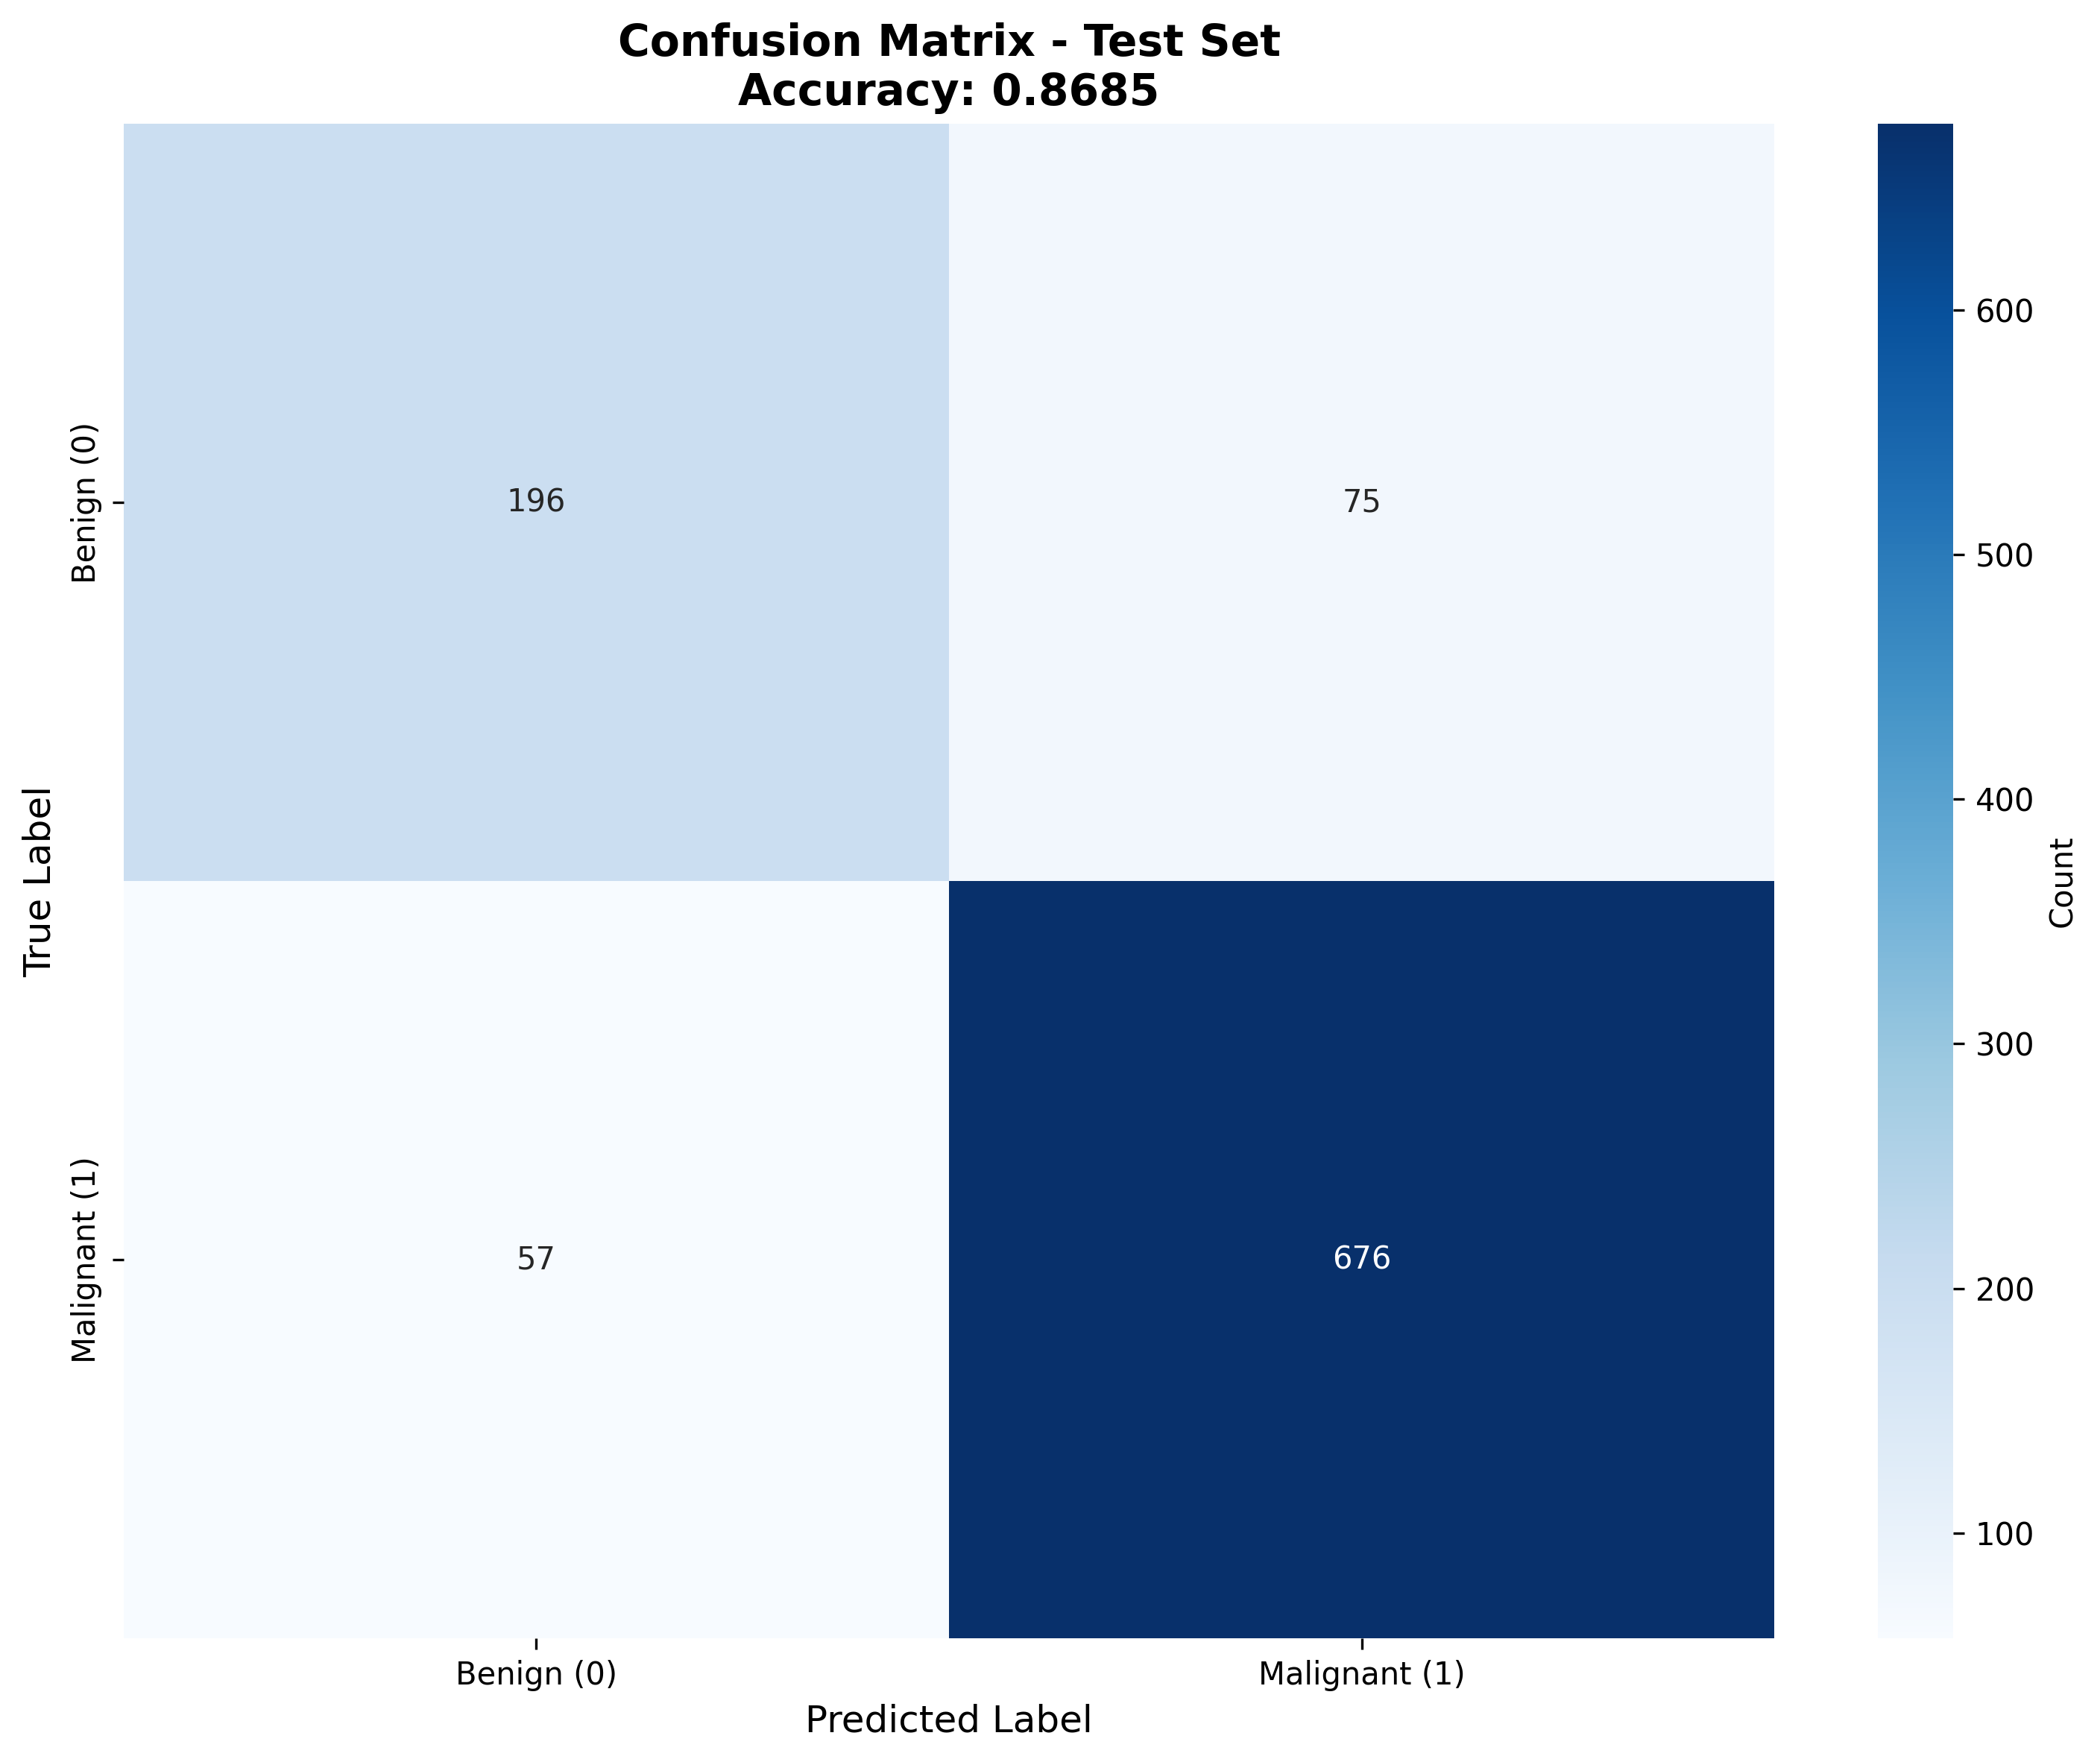


2. ROC Curve:


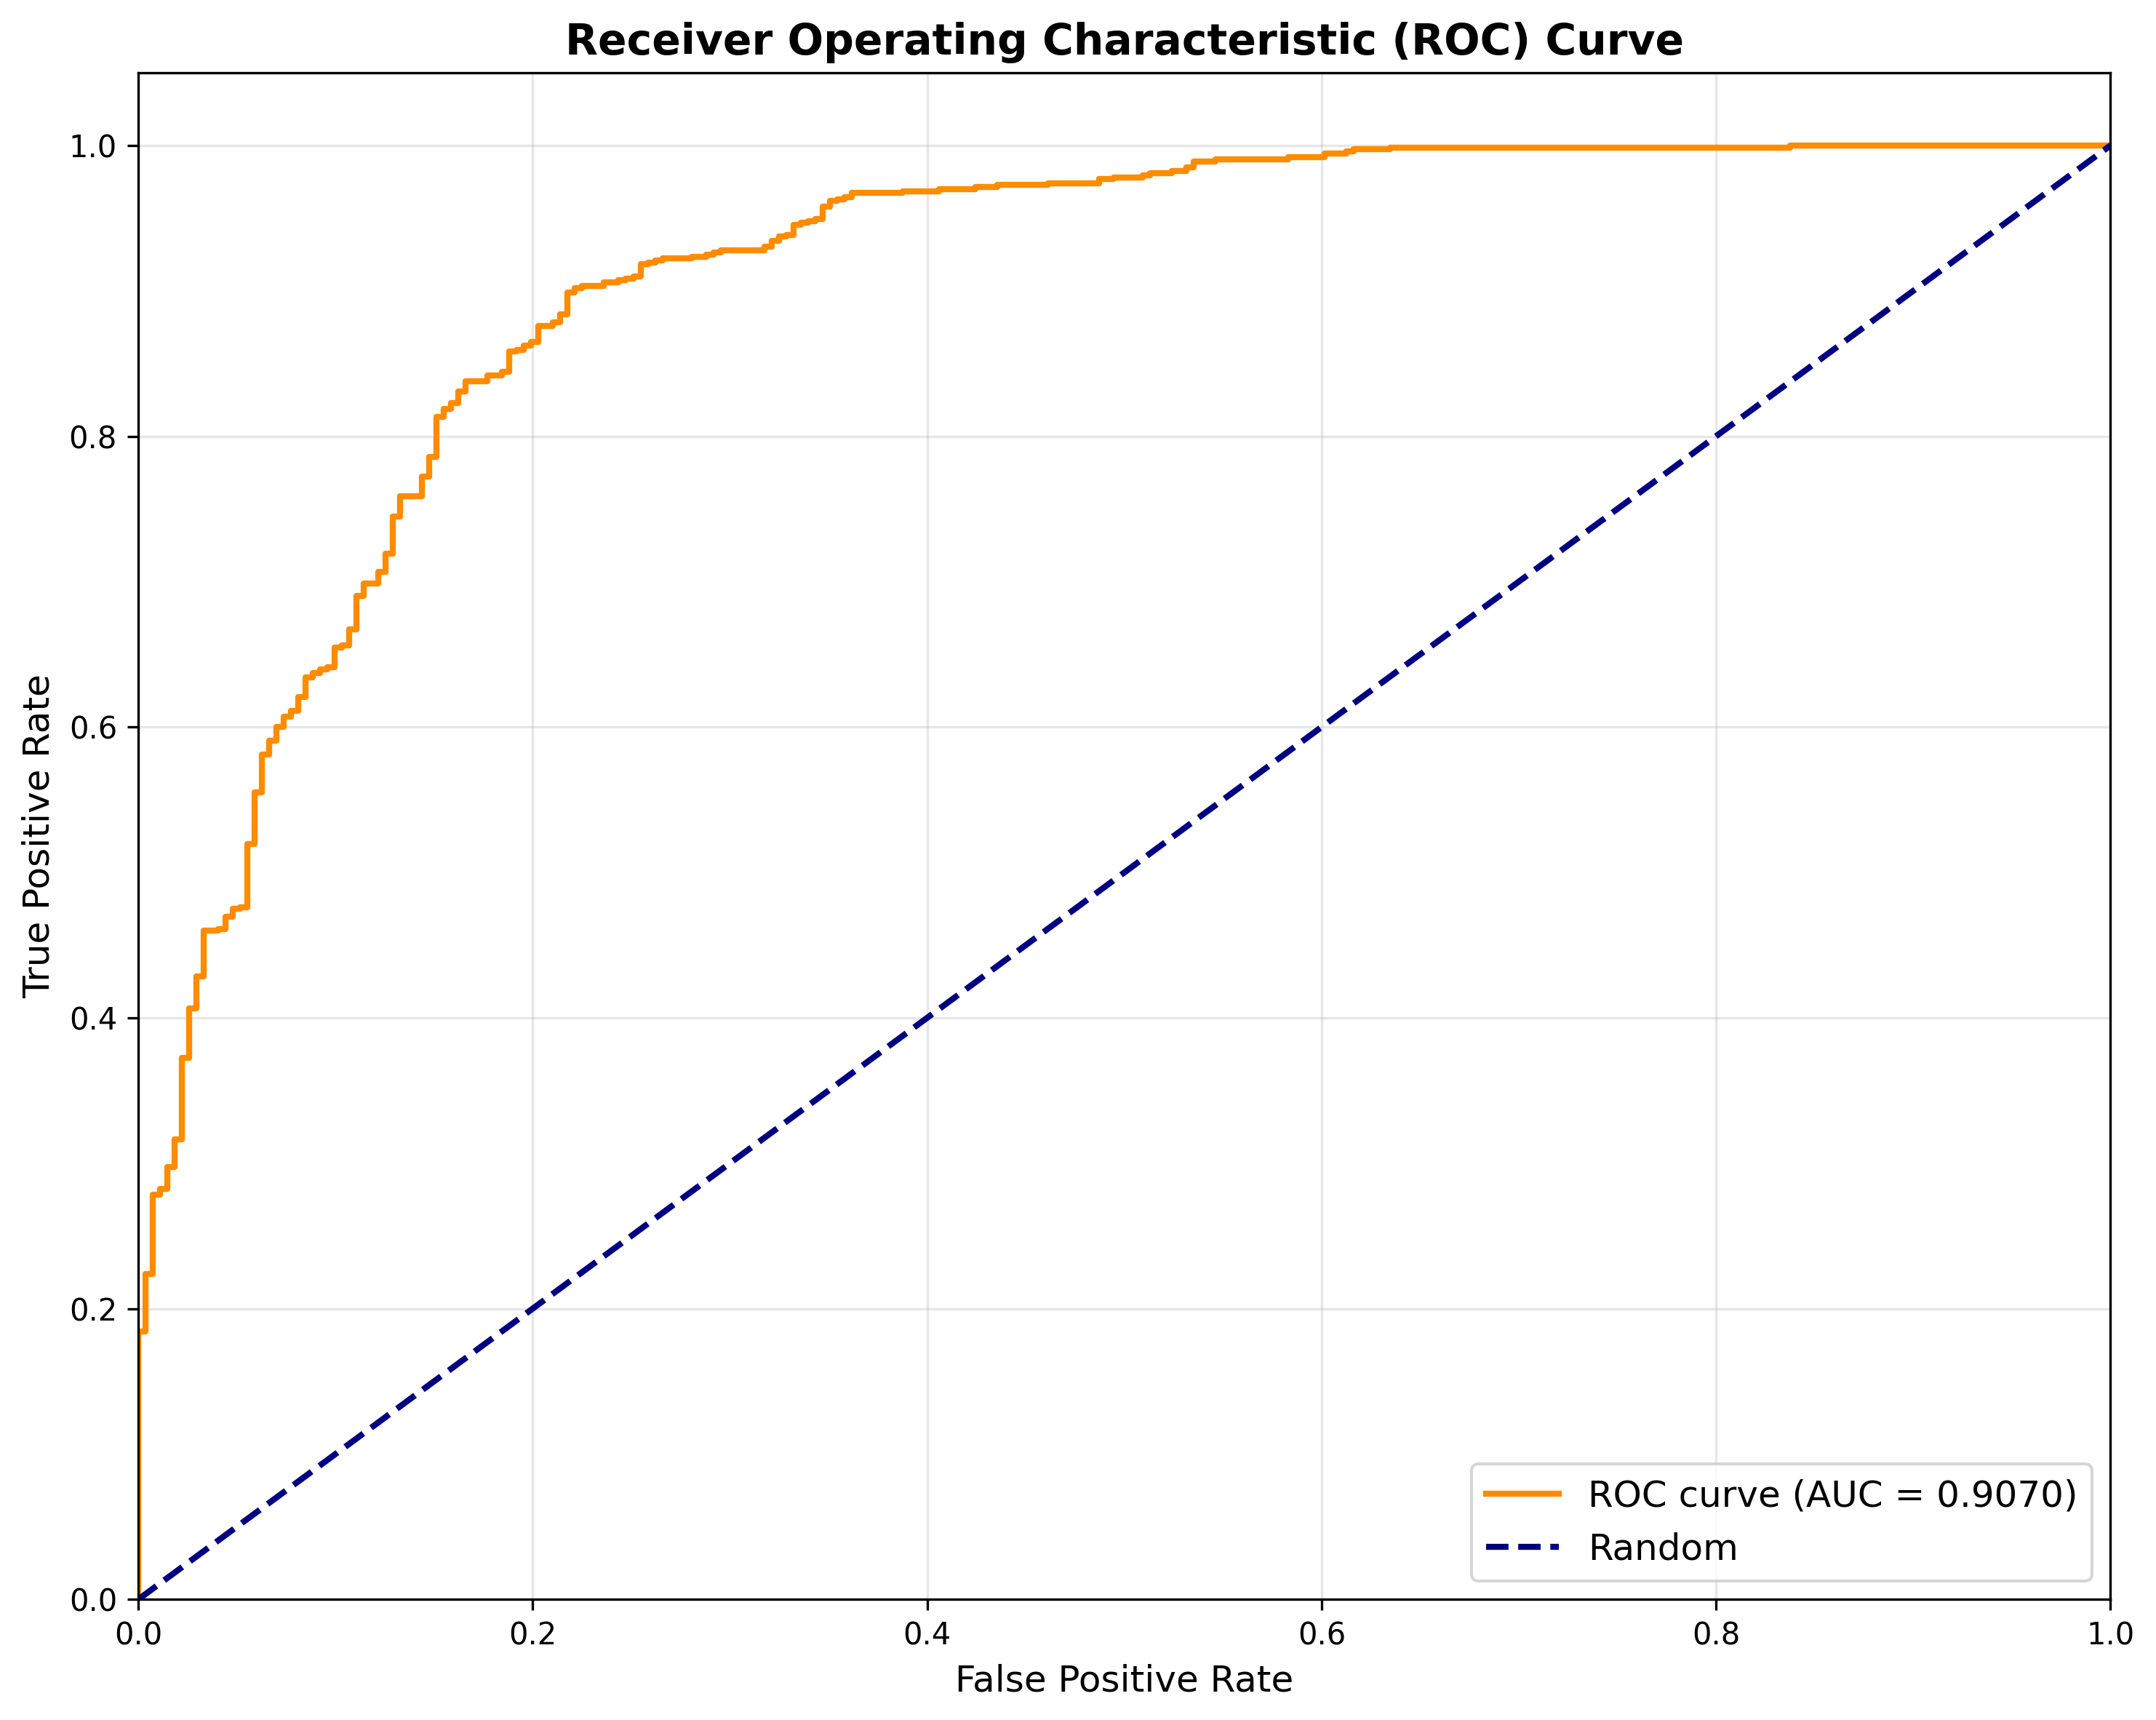

In [ ]:
# ============================================================
# CELL 2: Complete Testing Script
# Run this AFTER Cell 1 and runtime restart
# ============================================================

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.resnet import ResNet, Bottleneck
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve)
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✓ All packages imported successfully!")

# ============================================================
# Dataset Class
# ============================================================
class UltrasoundDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform

        if self.data['label'].dtype == 'O':
            label_map = {'benign': 0, 'malignant': 1, 0: 0, 1: 1}
            self.data['label'] = self.data['label'].map(label_map)

        print(f"Dataset: {len(self.data)} samples | Labels: {dict(self.data['label'].value_counts())}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        img_path = None
        if 'out_path' in row and pd.notna(row['out_path']):
            img_path = row['out_path']

        if img_path is None or not os.path.exists(img_path):
            if 'crop_name' in row:
                img_path = row['crop_name']

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            img = Image.new('RGB', (224, 224), color='white')

        label = torch.tensor(int(row['label']), dtype=torch.long)

        if self.transform:
            img = self.transform(img)

        return img, label

# ============================================================
# Custom ResNet-54 Architecture
# ============================================================
class CustomResNet(ResNet):
    def __init__(self, layers, num_classes=2, pretrained=False):
        super().__init__(block=Bottleneck, layers=layers, num_classes=1000)

        num_features = self.fc.in_features
        self.fc = nn.Linear(num_features, num_classes)

def resnet54_v2(num_classes=2, pretrained=False):
    """ResNet-54 with [3, 5, 6, 3] block configuration"""
    return CustomResNet([3, 5, 6, 3], num_classes, pretrained)

# ============================================================
# Evaluation Function
# ============================================================
def evaluate_model(model, test_loader, device, save_dir='test_results'):
    """
    Comprehensive model evaluation with all metrics
    """
    os.makedirs(save_dir, exist_ok=True)

    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []

    print("\n" + "="*80)
    print("EVALUATING MODEL ON TEST SET")
    print("="*80)

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing"):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    auc = roc_auc_score(all_targets, all_probs)
    cm = confusion_matrix(all_targets, all_preds)

    # Calculate specificity and sensitivity
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    # Print results
    print(f"\n{'='*80}")
    print("TEST SET RESULTS")
    print(f"{'='*80}\n")
    print(f"Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision:   {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:      {recall:.4f} ({recall*100:.2f}%)")
    print(f"F1-Score:    {f1:.4f} ({f1*100:.2f}%)")
    print(f"AUC-ROC:     {auc:.4f} ({auc*100:.2f}%)")
    print(f"Specificity: {specificity:.4f} ({specificity*100:.2f}%)")
    print(f"Sensitivity: {sensitivity:.4f} ({sensitivity*100:.2f}%)")

    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              Benign  Malignant")
    print(f"Actual Benign    {tn:4d}    {fp:4d}")
    print(f"      Malignant  {fn:4d}    {tp:4d}")

    # Detailed classification report
    print(f"\n{'-'*80}")
    print("DETAILED CLASSIFICATION REPORT")
    print(f"{'-'*80}")
    class_names = ['Benign (0)', 'Malignant (1)']
    print(classification_report(all_targets, all_preds,
                                target_names=class_names, digits=4))

    # Save metrics to JSON
    metrics = {
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'test_samples': len(all_targets),
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'auc_roc': float(auc),
        'specificity': float(specificity),
        'sensitivity': float(sensitivity),
        'confusion_matrix': {
            'true_negative': int(tn),
            'false_positive': int(fp),
            'false_negative': int(fn),
            'true_positive': int(tp)
        }
    }

    with open(f'{save_dir}/test_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=4)
    print(f"\n✓ Metrics saved to: {save_dir}/test_metrics.json")

    # Plot and save confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - Test Set\nAccuracy: {accuracy:.4f}',
              fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{save_dir}/confusion_matrix.png', dpi=300, bbox_inches='tight')
    print(f"✓ Confusion matrix saved to: {save_dir}/confusion_matrix.png")
    plt.close()

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve',
              fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{save_dir}/roc_curve.png', dpi=300, bbox_inches='tight')
    print(f"✓ ROC curve saved to: {save_dir}/roc_curve.png")
    plt.close()

    # Save predictions
    predictions_df = pd.DataFrame({
        'true_label': all_targets,
        'predicted_label': all_preds,
        'probability_malignant': all_probs,
        'correct': [t == p for t, p in zip(all_targets, all_preds)]
    })
    predictions_df.to_csv(f'{save_dir}/test_predictions.csv', index=False)
    print(f"✓ Predictions saved to: {save_dir}/test_predictions.csv")

    print(f"\n{'='*80}")
    print(f"ALL RESULTS SAVED TO: {save_dir}/")
    print(f"{'='*80}\n")

    return metrics

# ============================================================
# Main Testing Script
# ============================================================
print("="*80)
print("RESNET-54 MODEL TESTING ON TN5000 DATASET")
print("="*80)

# ========================================
# CONFIGURATION - MODIFY THESE PATHS
# ========================================
MODEL_PATH = "/content/drive/MyDrive/FDL_Thyroid_Disease/Models/resnet54_v2_[3,5,6,3]_baseline_acc0.9281.pth"
MANIFEST_CSV = "/content/drive/MyDrive/FDL_Thyroid_Disease/Project/tn5000_crops_manifest.csv"
BATCH_SIZE = 64
IMG_SIZE = 224
NUM_WORKERS = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR = "test_results"

print(f"\n📁 Model file: {MODEL_PATH}")
print(f"📊 Dataset CSV: {MANIFEST_CSV}")
print(f"🖥️  Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
print()

# Check if model file exists
if not os.path.exists(MODEL_PATH):
    print(f"❌ ERROR: Model file '{MODEL_PATH}' not found!")
    print(f"   Please upload your .pth file or update the MODEL_PATH variable.")
else:
    print(f"✓ Model file found")

# Check if CSV exists
if not os.path.exists(MANIFEST_CSV):
    print(f"❌ ERROR: CSV file '{MANIFEST_CSV}' not found!")
    print(f"   Please update the MANIFEST_CSV path.")
else:
    print(f"✓ CSV file found")

    # ========================================
    # LOAD TEST DATA
    # ========================================
    print("\nLoading test data...")
    full_data = pd.read_csv(MANIFEST_CSV)
    test_data = full_data[full_data['split'] == 'test'].copy()

    print(f"✓ Total samples in CSV: {len(full_data)}")
    print(f"✓ Test samples: {len(test_data)}")
    print(f"✓ Test label distribution: {dict(test_data['label'].value_counts())}\n")

    # ========================================
    # CREATE TEST DATASET
    # ========================================
    test_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    test_dataset = UltrasoundDataset(test_data, transform=test_transforms)
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if DEVICE == 'cuda' else False
    )

    print(f"✓ Test DataLoader created with batch size {BATCH_SIZE}\n")

    # ========================================
    # LOAD MODEL
    # ========================================
    print("Loading model architecture...")
    model = resnet54_v2(num_classes=2, pretrained=False)

    print(f"Loading weights from {MODEL_PATH}...")
    state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.to(DEVICE)
    print("✓ Model loaded successfully\n")

    # ========================================
    # EVALUATE ON TEST SET
    # ========================================
    metrics = evaluate_model(model, test_loader, DEVICE, save_dir=SAVE_DIR)

    # ========================================
    # OVERFITTING CHECK
    # ========================================
    print("\n" + "="*80)
    print("OVERFITTING ANALYSIS")
    print("="*80)

    # Your validation accuracy from training
    val_acc = 0.9281  # Best validation accuracy (epoch 14)
    test_acc = metrics['accuracy']

    gap = val_acc - test_acc

    print(f"\nValidation Accuracy (Epoch 14): {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"Test Accuracy:                  {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"Val-Test Gap:                   {gap:.4f} ({gap*100:.2f}%)")

    if abs(gap) < 0.02:
        print("\n✅ EXCELLENT: Model generalizes very well!")
        print("   Val-Test gap < 2% indicates good generalization.")
        overfitting_status = "EXCELLENT - Proceed to Grad-CAM"
    elif abs(gap) < 0.05:
        print("\n✓ GOOD: Model shows acceptable generalization.")
        print("   Val-Test gap < 5% is within acceptable range.")
        overfitting_status = "GOOD - Grad-CAM recommended"
    else:
        print("\n⚠️  WARNING: Significant Val-Test gap detected.")
        print("   Consider applying regularization techniques.")
        overfitting_status = "NEEDS_IMPROVEMENT - Apply regularization"

    # Training accuracy from final epoch
    train_acc_final = 0.958  # Epoch 21
    train_test_gap = train_acc_final - test_acc

    print(f"\nTraining Accuracy (Final):      {train_acc_final:.4f} ({train_acc_final*100:.2f}%)")
    print(f"Train-Test Gap:                 {train_test_gap:.4f} ({train_test_gap*100:.2f}%)")

    if train_test_gap > 0.05:
        print("\n⚠️  Model shows signs of overfitting:")
        print(f"   Train-Test gap of {train_test_gap*100:.2f}% is significant.")
        print("\n📋 RECOMMENDED REGULARIZATION TECHNIQUES:")
        print("   1. Increase Dropout (add dropout layers with p=0.3-0.5)")
        print("   2. Stronger L2 weight decay (increase from 1e-4 to 1e-3)")
        print("   3. More aggressive data augmentation")
        print("   4. Early stopping at epoch 14 (already implemented!)")
        print("   5. Label smoothing (epsilon=0.1)")
        needs_regularization = True
    else:
        print("\n✅ No significant overfitting detected!")
        needs_regularization = False

    # Save overfitting analysis
    overfitting_analysis = {
        'validation_accuracy': float(val_acc),
        'test_accuracy': float(test_acc),
        'val_test_gap': float(gap),
        'training_accuracy_final': float(train_acc_final),
        'train_test_gap': float(train_test_gap),
        'overfitting_detected': train_test_gap > 0.05,
        'needs_regularization': needs_regularization,
        'generalization_quality': 'excellent' if abs(gap) < 0.02 else 'good' if abs(gap) < 0.05 else 'needs_improvement',
        'recommendation': overfitting_status
    }

    with open(f'{SAVE_DIR}/overfitting_analysis.json', 'w') as f:
        json.dump(overfitting_analysis, f, indent=4)

    print(f"\n✓ Overfitting analysis saved to: {SAVE_DIR}/overfitting_analysis.json")

    # ========================================
    # FINAL SUMMARY & NEXT STEPS
    # ========================================
    print("\n" + "="*80)
    print("TESTING COMPLETE!")
    print("="*80)
    print(f"\n📊 Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"📊 Test F1-Score: {metrics['f1_score']:.4f}")
    print(f"📊 Test AUC-ROC:  {metrics['auc_roc']:.4f}")
    print(f"\n📁 All results saved to: {SAVE_DIR}/")
    print(f"   - test_metrics.json")
    print(f"   - test_predictions.csv")
    print(f"   - confusion_matrix.png")
    print(f"   - roc_curve.png")
    print(f"   - overfitting_analysis.json")

    print("\n" + "="*80)
    print("NEXT STEPS")
    print("="*80)

    if test_acc >= 0.90 and not needs_regularization:
        print("\n✅ Your model is performing excellently!")
        print("   👉 PROCEED TO GRAD-CAM EXPLAINABILITY")
        print("   👉 Ready for publication!")
    elif test_acc >= 0.85 and test_acc < 0.90:
        print("\n⚠️  Good performance, but could be improved")
        if needs_regularization:
            print("   👉 Apply regularization techniques first")
            print("   👉 Then proceed to Grad-CAM")
        else:
            print("   👉 Proceed to Grad-CAM")
    else:
        print("\n❌ Performance needs improvement")
        print("   👉 Apply regularization techniques")
        print("   👉 Consider data augmentation")

    print("\n" + "="*80 + "\n")

    # Display visualizations in Colab
    from IPython.display import Image as IPImage, display

    print("📊 DISPLAYING RESULTS:")
    print("\n1. Confusion Matrix:")
    display(IPImage(filename=f'{SAVE_DIR}/confusion_matrix.png'))

    print("\n2. ROC Curve:")
    display(IPImage(filename=f'{SAVE_DIR}/roc_curve.png'))


# **Regularized ResNet-54**


In [ ]:
# ============================================================
# REGULARIZED RESNET-54 TRAINING - FIX OVERFITTING
# Run time: ~15-20 minutes on Tesla T4
# ============================================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.resnet import ResNet, Bottleneck
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
from PIL import Image
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# Dataset Class
# ============================================================
class UltrasoundDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform

        if self.data['label'].dtype == 'O':
            label_map = {'benign': 0, 'malignant': 1, 0: 0, 1: 1}
            self.data['label'] = self.data['label'].map(label_map)

        print(f"Dataset: {len(self.data)} samples | Labels: {dict(self.data['label'].value_counts())}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = None
        if 'out_path' in row and pd.notna(row['out_path']):
            img_path = row['out_path']
        if img_path is None or not os.path.exists(img_path):
            if 'crop_name' in row:
                img_path = row['crop_name']

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            img = Image.new('RGB', (224, 224), color='white')

        label = torch.tensor(int(row['label']), dtype=torch.long)
        if self.transform:
            img = self.transform(img)
        return img, label

# ============================================================
# ResNet-54 with Dropout (Anti-Overfitting)
# ============================================================
class CustomResNetWithDropout(ResNet):
    def __init__(self, layers, num_classes=2, dropout_p=0.4, pretrained=True):
        super().__init__(block=Bottleneck, layers=layers, num_classes=1000)

        if pretrained:
            try:
                state_dict = torch.hub.load_state_dict_from_url(
                    'https://download.pytorch.org/models/resnet50-0676ba61.pth',
                    progress=True
                )
                del state_dict['fc.weight']
                del state_dict['fc.bias']
                self.load_state_dict(state_dict, strict=False)
                print(f"✓ Loaded pretrained weights")
            except Exception as e:
                print(f"⚠ Could not load pretrained weights: {e}")

        # Add dropout before final layer
        num_features = self.fc.in_features
        self.fc = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(num_features, num_classes)
        )

def resnet54_v2_regularized(num_classes=2, dropout_p=0.4, pretrained=True):
    return CustomResNetWithDropout([3, 5, 6, 3], num_classes, dropout_p, pretrained)

# ============================================================
# Training Function
# ============================================================
def train_model_regularized(model, train_loader, val_loader, device, config):
    criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

    optimizer = optim.AdamW(
        model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

    model.to(device)
    best_val_acc = 0.0
    best_model_state = None
    patience = 5
    patience_counter = 0

    scaler = torch.cuda.amp.GradScaler()

    print("\n" + "="*80)
    print("TRAINING WITH REGULARIZATION")
    print("="*80)

    start_time = time.time()

    for epoch in range(config['epochs']):
        # Training
        model.train()
        train_loss, train_preds, train_targets = 0, [], []

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}", leave=False):
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds, zero_division=0)

        # Validation
        model.eval()
        val_preds, val_targets, val_probs = [], [], []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                with torch.cuda.amp.autocast():
                    outputs = model(imgs)

                probs = torch.softmax(outputs, dim=1)
                val_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                val_probs.extend(probs[:, 1].cpu().numpy())

        val_acc = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds, zero_division=0)
        val_auc = roc_auc_score(val_targets, val_probs) if len(set(val_targets)) > 1 else 0.0

        # Calculate gap (overfitting indicator)
        gap = train_acc - val_acc

        print(f"E{epoch+1}: Train={train_acc:.3f} Val={val_acc:.3f} Gap={gap:.3f} | F1={val_f1:.3f} AUC={val_auc:.3f}", end="")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f" ★ BEST")
        else:
            patience_counter += 1
            print()

        if patience_counter >= patience:
            print(f"\n⚠ Early stopping at epoch {epoch+1}")
            break

        scheduler.step()

    elapsed = time.time() - start_time
    print(f"\n⏱️  Training time: {elapsed/60:.1f} min")

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, best_val_acc

# ============================================================
# MAIN SCRIPT
# ============================================================
print("="*80)
print("RESNET-54 WITH REGULARIZATION - REDUCE OVERFITTING")
print("="*80)

MANIFEST_CSV = "/content/drive/MyDrive/FDL_Thyroid_Disease/Project/tn5000_crops_manifest.csv"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Regularization configuration
config = {
    'batch_size': 64,
    'epochs': 25,
    'lr': 8e-5,
    'weight_decay': 3e-4,  # 3x stronger than before
    'dropout': 0.4,
    'label_smoothing': 0.1,
    'img_size': 224
}

print(f"\n🔧 REGULARIZATION TECHNIQUES APPLIED:")
print(f"   ✓ Dropout: {config['dropout']} (was 0)")
print(f"   ✓ Weight Decay: {config['weight_decay']} (was 1e-4)")
print(f"   ✓ Label Smoothing: {config['label_smoothing']} (was 0)")
print(f"   ✓ Early Stopping: patience=5 (was 7)")
print(f"   ✓ Stronger Data Augmentation")
print(f"   ✓ Lower Learning Rate: {config['lr']}")

print(f"\n🎮 Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

# Load data
print(f"\n📁 Loading data...")
full_data = pd.read_csv(MANIFEST_CSV)
train_data = full_data[full_data['split'] == 'train'].copy()
val_data = full_data[full_data['split'] == 'val'].copy()

print(f"   Train: {len(train_data)} samples")
print(f"   Val: {len(val_data)} samples")

# STRONGER data augmentation
train_tfms = transforms.Compose([
    transforms.Resize((config['img_size'], config['img_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((config['img_size'], config['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = UltrasoundDataset(train_data, transform=train_tfms)
val_dataset = UltrasoundDataset(val_data, transform=val_tfms)

train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'] * 2,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

# Build model
print(f"\n🏗️  Building ResNet-54 with regularization...")
model = resnet54_v2_regularized(
    num_classes=2,
    dropout_p=config['dropout'],
    pretrained=True
)

# Train
print(f"\n🚀 Starting training...")
trained_model, best_val_acc = train_model_regularized(
    model, train_loader, val_loader, DEVICE, config
)

# Save
save_name = f"resnet54_v2_REGULARIZED_acc{best_val_acc:.4f}.pth"
save_path = "/content/drive/MyDrive/FDL_Thyroid_Disease/Models/" + save_name
torch.save(trained_model.state_dict(), save_path)

print(f"\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"\n💾 Saved: {save_path}")
print(f"📊 Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"\n✅ Next Step: Test this model using the testing script!")
print(f"   Expected: Test accuracy closer to validation (less overfitting)")


RESNET-54 WITH REGULARIZATION - REDUCE OVERFITTING

🔧 REGULARIZATION TECHNIQUES APPLIED:
   ✓ Dropout: 0.4 (was 0)
   ✓ Weight Decay: 0.0003 (was 1e-4)
   ✓ Label Smoothing: 0.1 (was 0)
   ✓ Early Stopping: patience=5 (was 7)
   ✓ Stronger Data Augmentation
   ✓ Lower Learning Rate: 8e-05

🎮 Device: cuda
   GPU: Tesla T4

📁 Loading data...
   Train: 3508 samples
   Val: 501 samples
Dataset: 3508 samples | Labels: {1: np.int64(2473), 0: np.int64(1035)}
Dataset: 501 samples | Labels: {1: np.int64(376), 0: np.int64(125)}

🏗️  Building ResNet-54 with regularization...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 128MB/s]


✓ Loaded pretrained weights

🚀 Starting training...

TRAINING WITH REGULARIZATION


E1: Train=0.737 Val=0.852 Gap=-0.115 | F1=0.908 AUC=0.903 ★ BEST


E2: Train=0.812 Val=0.892 Gap=-0.080 | F1=0.930 AUC=0.917 ★ BEST


E3: Train=0.833 Val=0.866 Gap=-0.033 | F1=0.909 AUC=0.936


E4: Train=0.850 Val=0.886 Gap=-0.036 | F1=0.923 AUC=0.934


E5: Train=0.847 Val=0.904 Gap=-0.058 | F1=0.938 AUC=0.947 ★ BEST


E6: Train=0.861 Val=0.884 Gap=-0.024 | F1=0.926 AUC=0.932


E7: Train=0.870 Val=0.904 Gap=-0.034 | F1=0.939 AUC=0.949


E8: Train=0.873 Val=0.894 Gap=-0.022 | F1=0.931 AUC=0.941


E9: Train=0.875 Val=0.918 Gap=-0.044 | F1=0.945 AUC=0.946 ★ BEST


E10: Train=0.878 Val=0.910 Gap=-0.032 | F1=0.942 AUC=0.940


E11: Train=0.881 Val=0.894 Gap=-0.013 | F1=0.929 AUC=0.953


E12: Train=0.877 Val=0.906 Gap=-0.029 | F1=0.938 AUC=0.945


E13: Train=0.899 Val=0.906 Gap=-0.008 | F1=0.940 AUC=0.944


E14: Train=0.889 Val=0.900 Gap=-0.011 | F1=0.936 AUC=0.945

⚠ Early stopping at epoch 14

⏱️  Training time: 20.3 min

TRAINING COMPLETE!

💾 Saved: /content/drive/MyDrive/FDL_Thyroid_Disease/Models/resnet54_v2_REGULARIZED_acc0.9182.pth
📊 Best Validation Accuracy: 0.9182 (91.82%)

✅ Next Step: Test this model using the testing script!
   Expected: Test accuracy closer to validation (less overfitting)


# **Testing Regularized ResNet-54**

✓ All packages imported successfully!
TESTING REGULARIZED RESNET-54 MODEL

📁 Model file: /content/drive/MyDrive/FDL_Thyroid_Disease/Models/resnet54_v2_REGULARIZED_acc0.9182.pth
📊 Dataset CSV: /content/drive/MyDrive/FDL_Thyroid_Disease/Project/tn5000_crops_manifest.csv
🖥️  Device: cuda
🎮 GPU: Tesla T4

✓ Model file found
✓ CSV file found

Loading test data...
✓ Total samples in CSV: 5013
✓ Test samples: 1004
✓ Test label distribution: {1: np.int64(733), 0: np.int64(271)}

Dataset: 1004 samples | Labels: {1: np.int64(733), 0: np.int64(271)}
✓ Test DataLoader created

Loading regularized model architecture...
Loading weights from /content/drive/MyDrive/FDL_Thyroid_Disease/Models/resnet54_v2_REGULARIZED_acc0.9182.pth...
✓ Model loaded successfully


EVALUATING REGULARIZED MODEL ON TEST SET


Testing: 100%|██████████| 16/16 [03:41<00:00, 13.83s/it]



TEST SET RESULTS - REGULARIZED MODEL

Accuracy:    0.8705 (87.05%)
Precision:   0.8745 (87.45%)
Recall:      0.9604 (96.04%)
F1-Score:    0.9155 (91.55%)
AUC-ROC:     0.9019 (90.19%)
Specificity: 0.6273 (62.73%)
Sensitivity: 0.9604 (96.04%)

Confusion Matrix:
                Predicted
              Benign  Malignant
Actual Benign     170     101
      Malignant    29     704

--------------------------------------------------------------------------------
DETAILED CLASSIFICATION REPORT
--------------------------------------------------------------------------------
               precision    recall  f1-score   support

   Benign (0)     0.8543    0.6273    0.7234       271
Malignant (1)     0.8745    0.9604    0.9155       733

     accuracy                         0.8705      1004
    macro avg     0.8644    0.7939    0.8194      1004
 weighted avg     0.8691    0.8705    0.8636      1004


✓ Metrics saved to: test_results_regularized/test_metrics.json
✓ Confusion matrix saved to: t

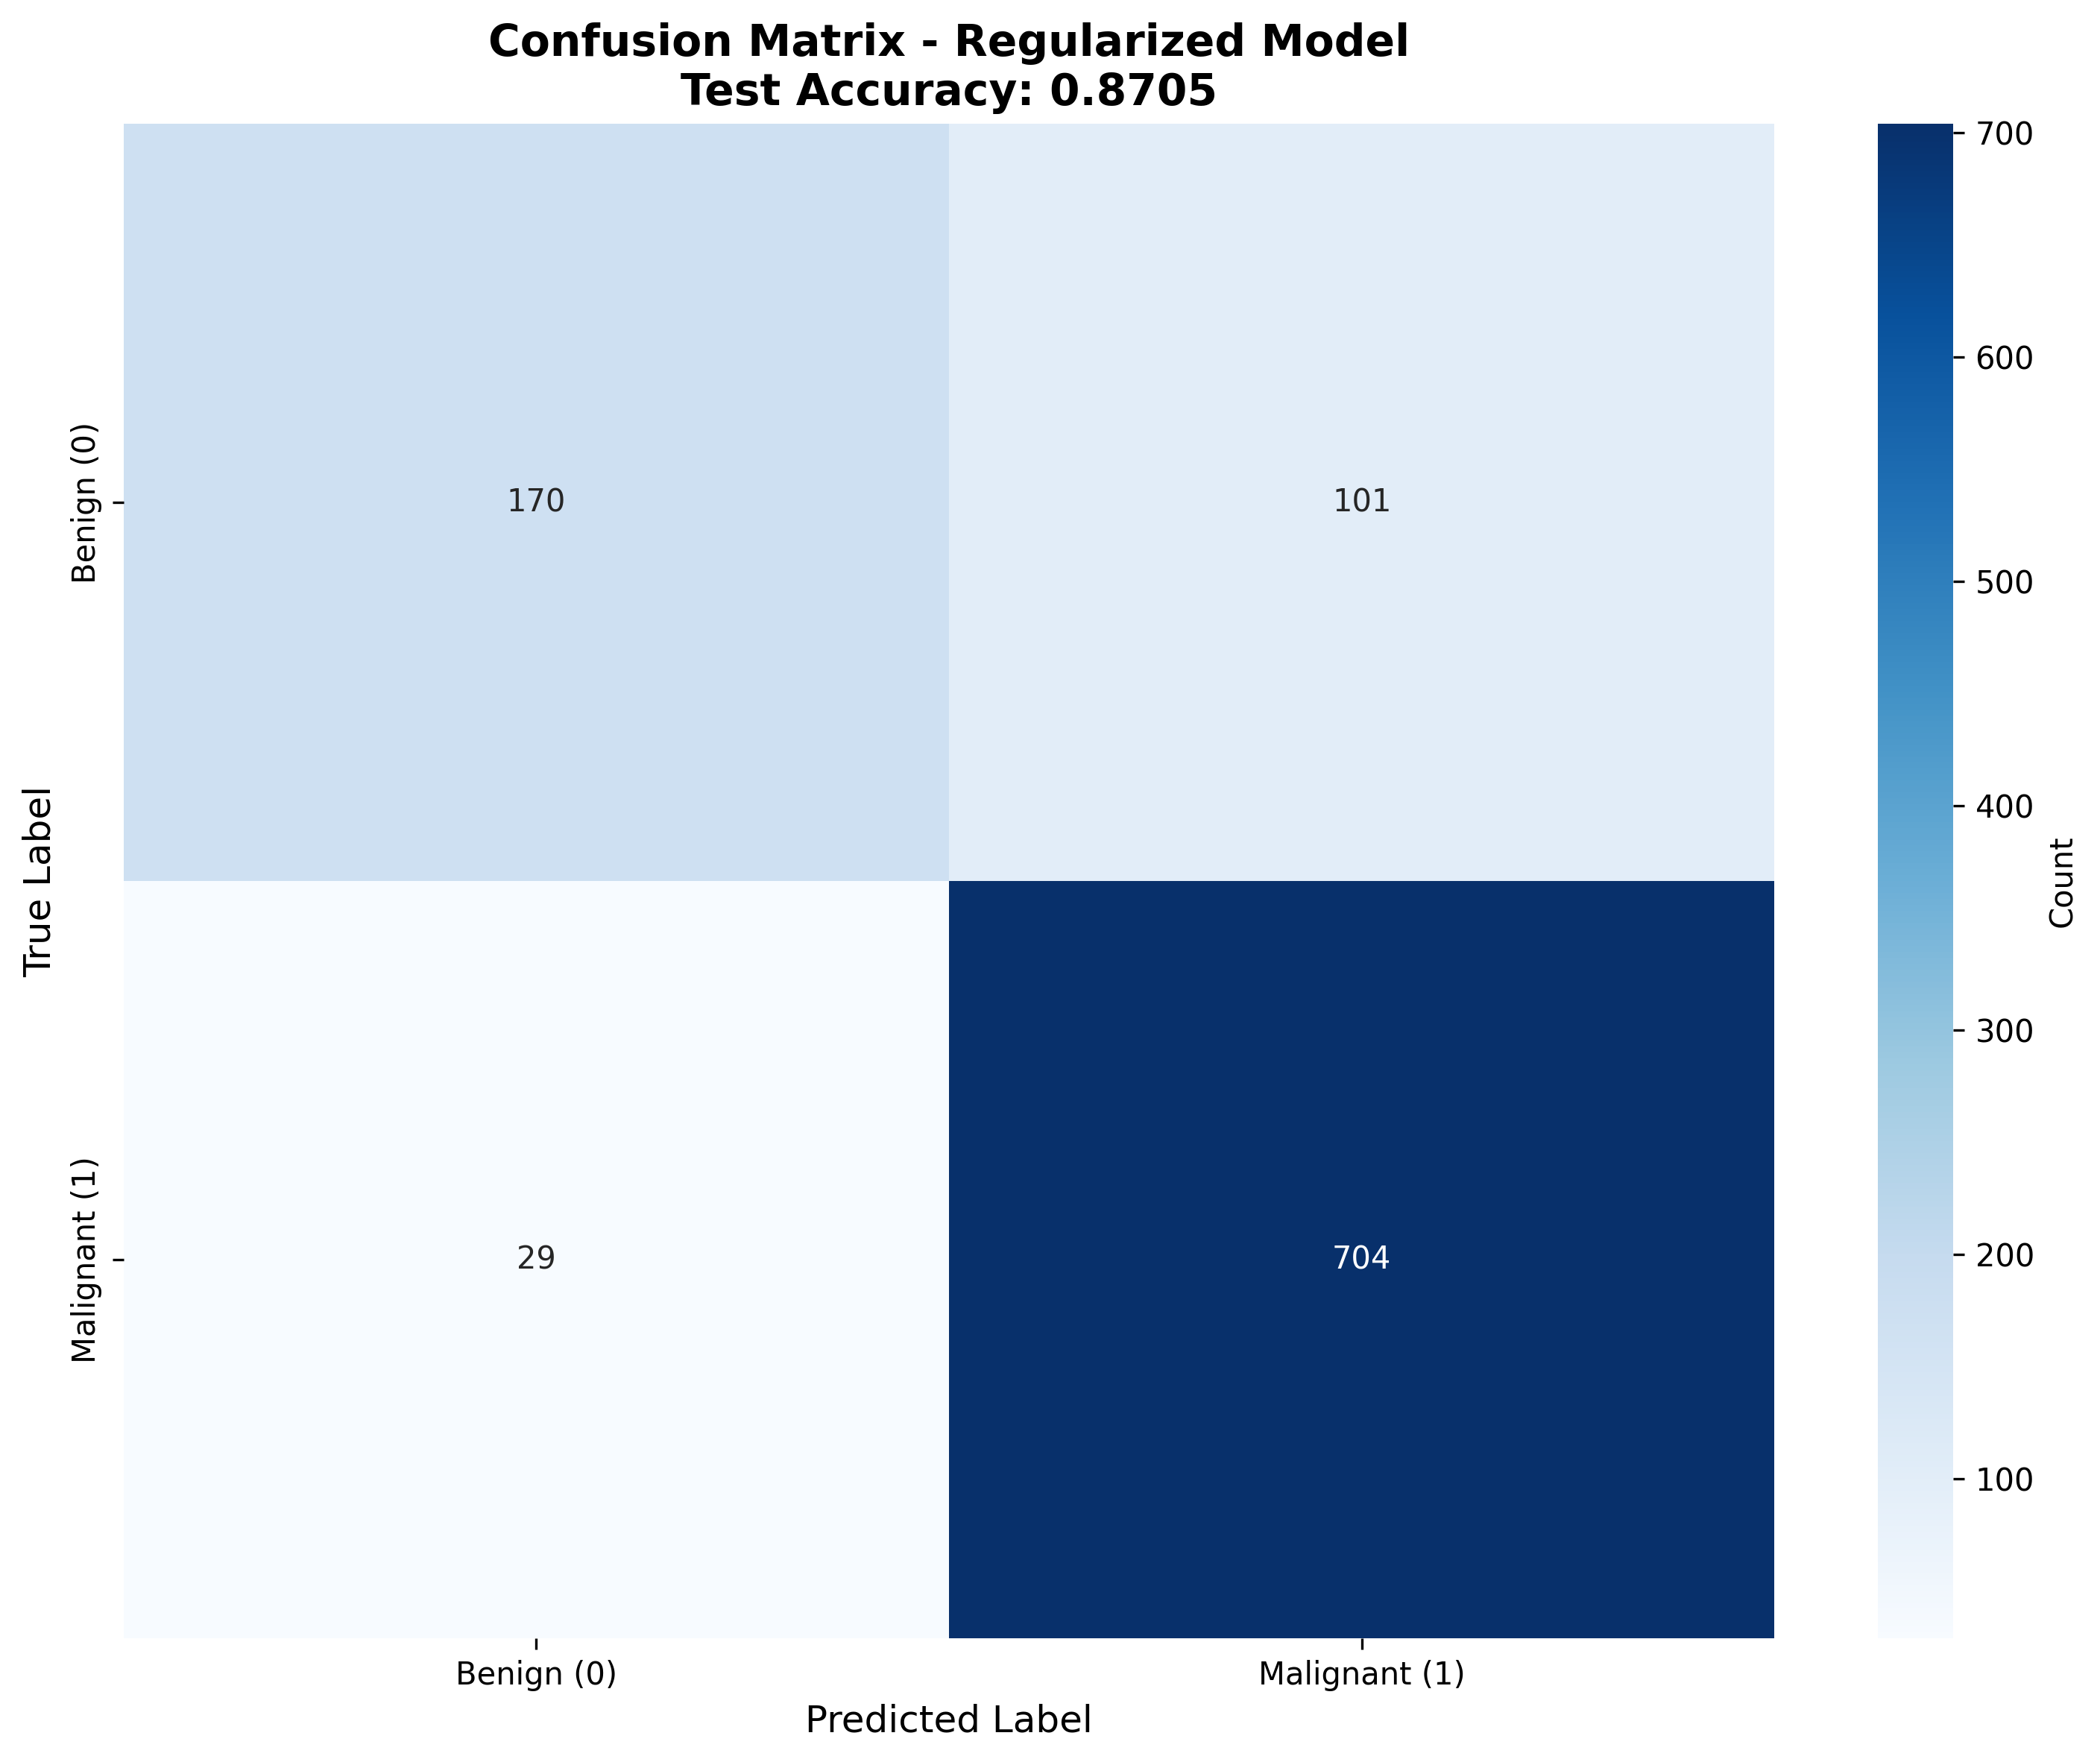


2. ROC Curve:


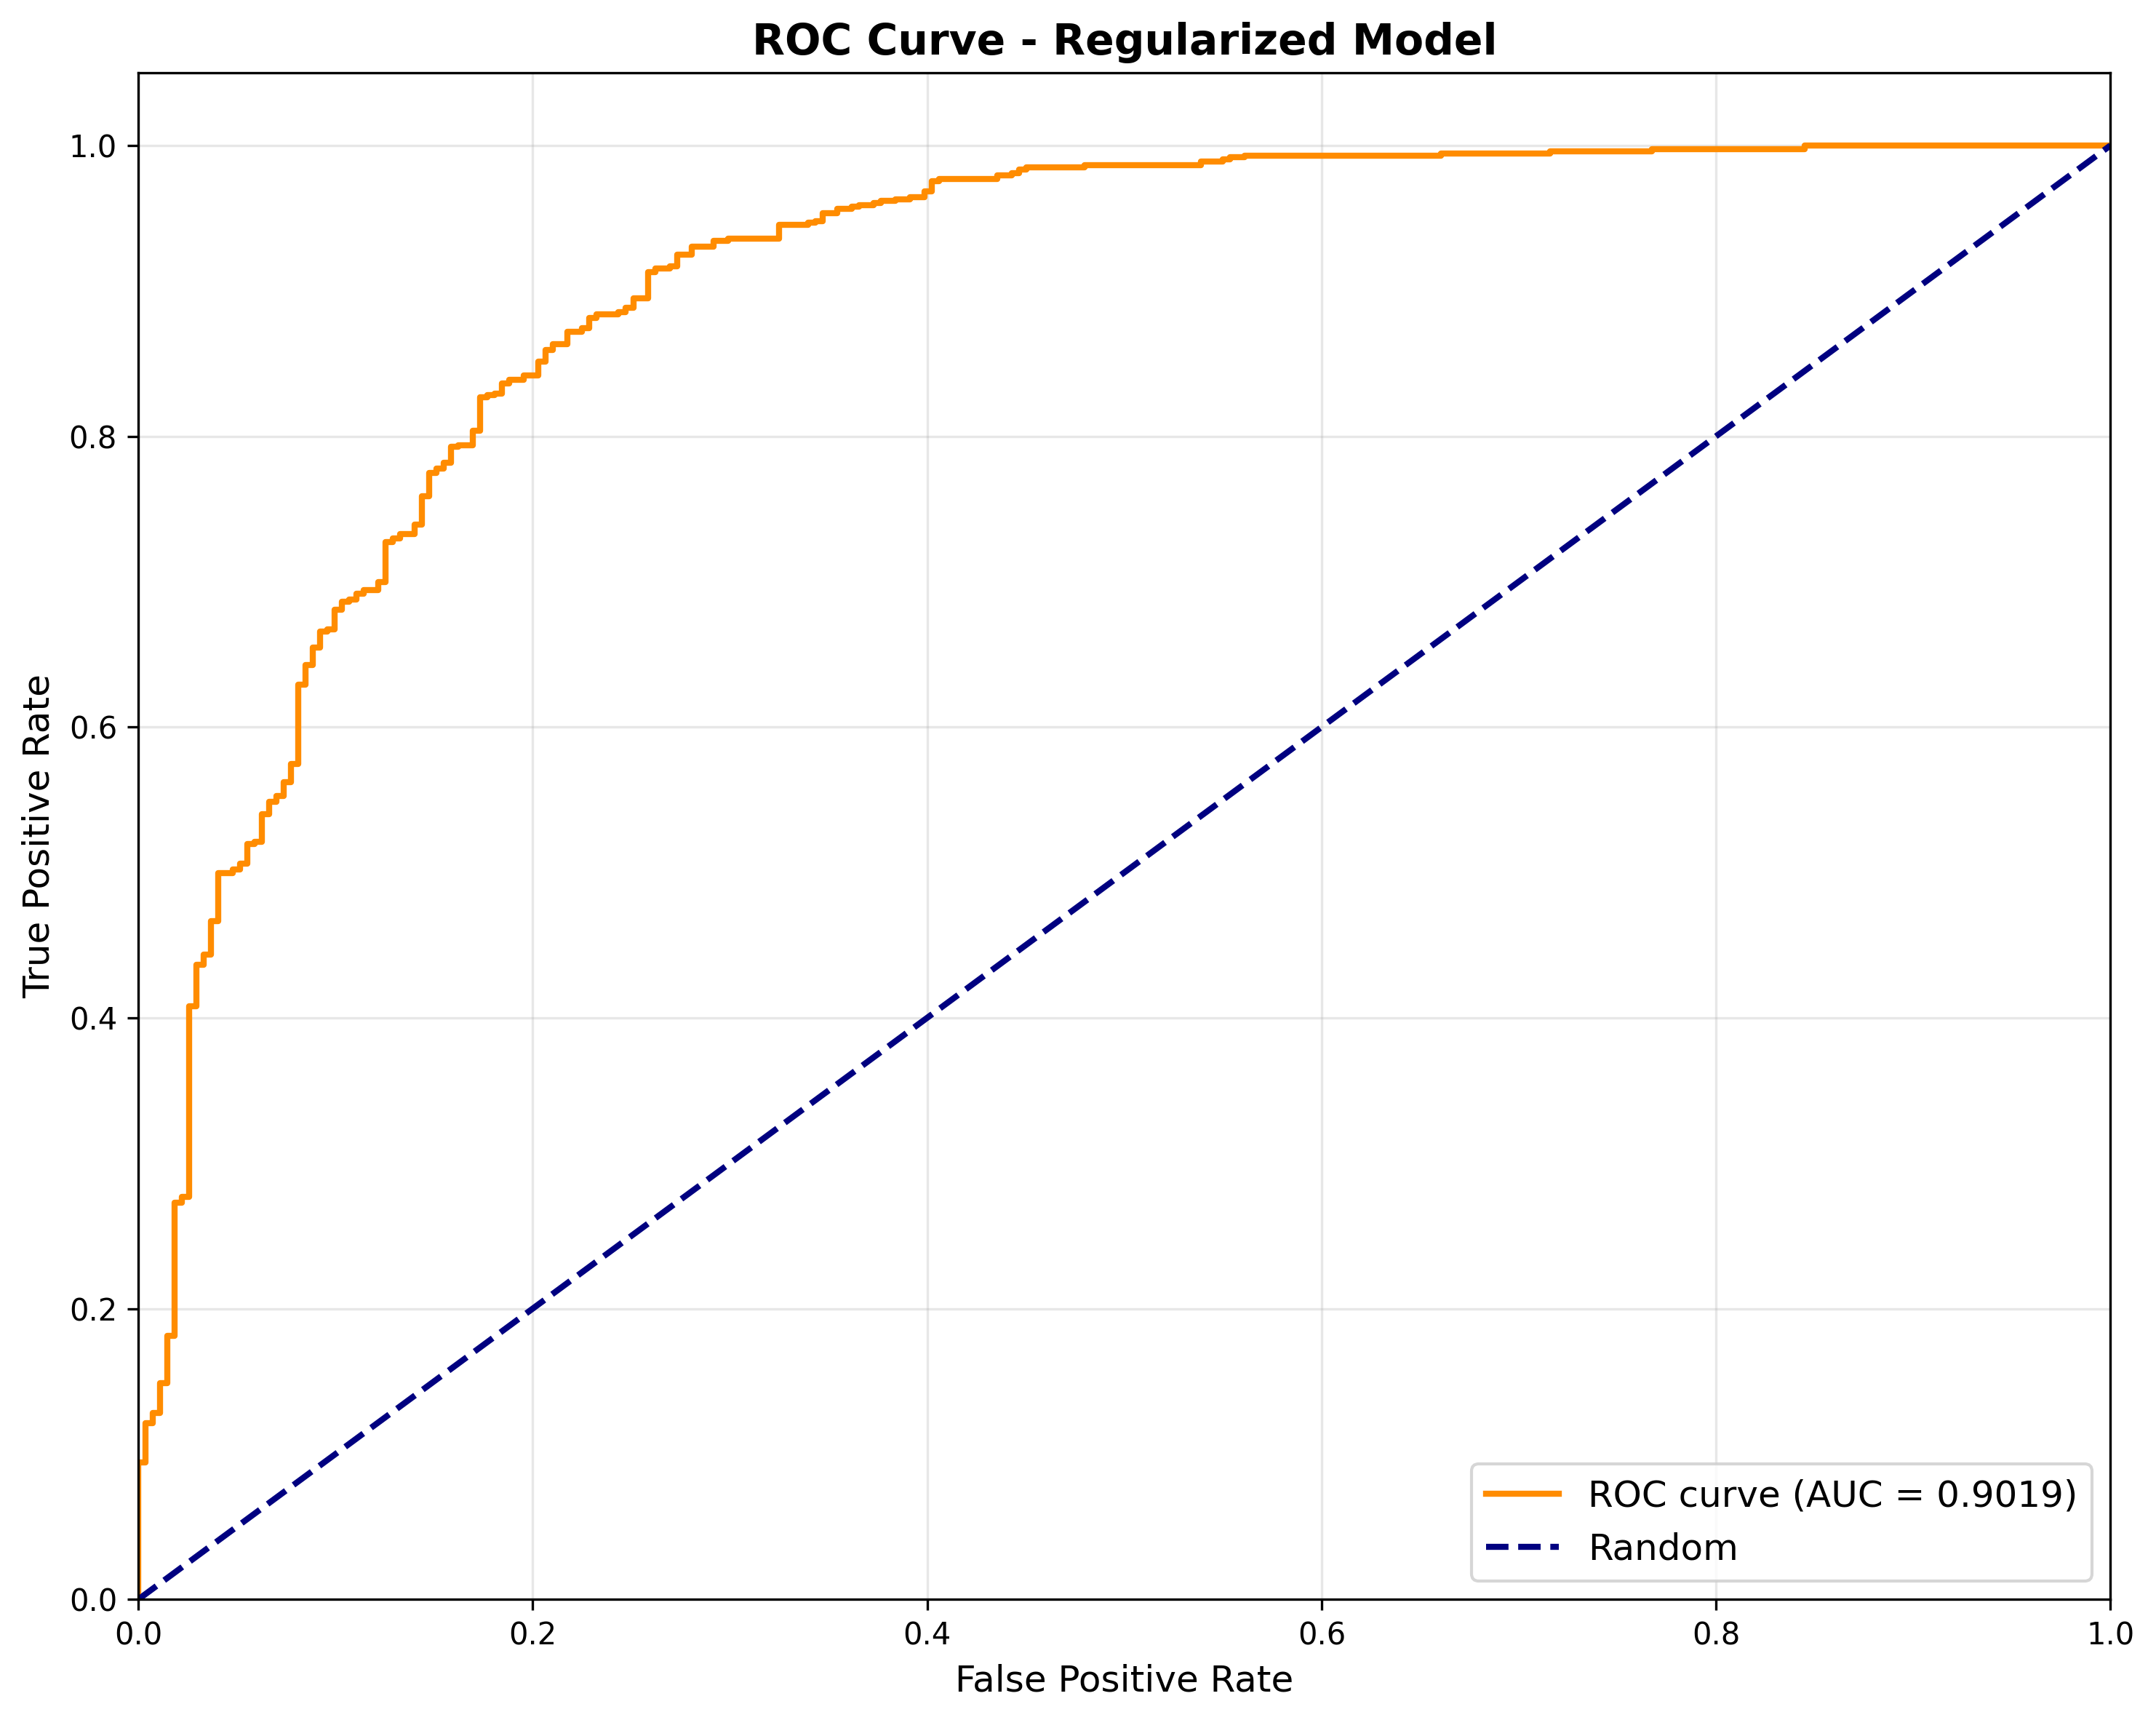

In [ ]:
# ============================================================
# TEST REGULARIZED MODEL
# ============================================================

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.resnet import ResNet, Bottleneck
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve)
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✓ All packages imported successfully!")

# ============================================================
# Dataset Class
# ============================================================
class UltrasoundDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform

        if self.data['label'].dtype == 'O':
            label_map = {'benign': 0, 'malignant': 1, 0: 0, 1: 1}
            self.data['label'] = self.data['label'].map(label_map)

        print(f"Dataset: {len(self.data)} samples | Labels: {dict(self.data['label'].value_counts())}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        img_path = None
        if 'out_path' in row and pd.notna(row['out_path']):
            img_path = row['out_path']

        if img_path is None or not os.path.exists(img_path):
            if 'crop_name' in row:
                img_path = row['crop_name']

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            img = Image.new('RGB', (224, 224), color='white')

        label = torch.tensor(int(row['label']), dtype=torch.long)

        if self.transform:
            img = self.transform(img)

        return img, label

# ============================================================
# ResNet-54 with Dropout (MUST MATCH TRAINING)
# ============================================================
class CustomResNetWithDropout(ResNet):
    def __init__(self, layers, num_classes=2, dropout_p=0.4, pretrained=False):
        super().__init__(block=Bottleneck, layers=layers, num_classes=1000)

        num_features = self.fc.in_features
        self.fc = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(num_features, num_classes)
        )

def resnet54_v2_regularized(num_classes=2, dropout_p=0.4, pretrained=False):
    return CustomResNetWithDropout([3, 5, 6, 3], num_classes, dropout_p, pretrained)

# ============================================================
# Evaluation Function
# ============================================================
def evaluate_model(model, test_loader, device, save_dir='test_results_regularized'):
    os.makedirs(save_dir, exist_ok=True)

    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []

    print("\n" + "="*80)
    print("EVALUATING REGULARIZED MODEL ON TEST SET")
    print("="*80)

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing"):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    auc = roc_auc_score(all_targets, all_probs)
    cm = confusion_matrix(all_targets, all_preds)

    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    # Print results
    print(f"\n{'='*80}")
    print("TEST SET RESULTS - REGULARIZED MODEL")
    print(f"{'='*80}\n")
    print(f"Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision:   {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:      {recall:.4f} ({recall*100:.2f}%)")
    print(f"F1-Score:    {f1:.4f} ({f1*100:.2f}%)")
    print(f"AUC-ROC:     {auc:.4f} ({auc*100:.2f}%)")
    print(f"Specificity: {specificity:.4f} ({specificity*100:.2f}%)")
    print(f"Sensitivity: {sensitivity:.4f} ({sensitivity*100:.2f}%)")

    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              Benign  Malignant")
    print(f"Actual Benign    {tn:4d}    {fp:4d}")
    print(f"      Malignant  {fn:4d}    {tp:4d}")

    # Detailed classification report
    print(f"\n{'-'*80}")
    print("DETAILED CLASSIFICATION REPORT")
    print(f"{'-'*80}")
    class_names = ['Benign (0)', 'Malignant (1)']
    print(classification_report(all_targets, all_preds,
                                target_names=class_names, digits=4))

    # Save metrics
    metrics = {
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'test_samples': len(all_targets),
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'auc_roc': float(auc),
        'specificity': float(specificity),
        'sensitivity': float(sensitivity),
        'confusion_matrix': {
            'true_negative': int(tn),
            'false_positive': int(fp),
            'false_negative': int(fn),
            'true_positive': int(tp)
        }
    }

    with open(f'{save_dir}/test_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=4)
    print(f"\n✓ Metrics saved to: {save_dir}/test_metrics.json")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - Regularized Model\nTest Accuracy: {accuracy:.4f}',
              fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{save_dir}/confusion_matrix.png', dpi=300, bbox_inches='tight')
    print(f"✓ Confusion matrix saved to: {save_dir}/confusion_matrix.png")
    plt.close()

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Regularized Model', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{save_dir}/roc_curve.png', dpi=300, bbox_inches='tight')
    print(f"✓ ROC curve saved to: {save_dir}/roc_curve.png")
    plt.close()

    # Save predictions
    predictions_df = pd.DataFrame({
        'true_label': all_targets,
        'predicted_label': all_preds,
        'probability_malignant': all_probs,
        'correct': [t == p for t, p in zip(all_targets, all_preds)]
    })
    predictions_df.to_csv(f'{save_dir}/test_predictions.csv', index=False)
    print(f"✓ Predictions saved to: {save_dir}/test_predictions.csv")

    print(f"\n{'='*80}")
    print(f"ALL RESULTS SAVED TO: {save_dir}/")
    print(f"{'='*80}\n")

    return metrics

# ============================================================
# Main Testing Script
# ============================================================
print("="*80)
print("TESTING REGULARIZED RESNET-54 MODEL")
print("="*80)

# ========================================
# CONFIGURATION
# ========================================
MODEL_PATH = "/content/drive/MyDrive/FDL_Thyroid_Disease/Models/resnet54_v2_REGULARIZED_acc0.9182.pth"
MANIFEST_CSV = "/content/drive/MyDrive/FDL_Thyroid_Disease/Project/tn5000_crops_manifest.csv"
BATCH_SIZE = 64
IMG_SIZE = 224
NUM_WORKERS = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR = "test_results_regularized"

print(f"\n📁 Model file: {MODEL_PATH}")
print(f"📊 Dataset CSV: {MANIFEST_CSV}")
print(f"🖥️  Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
print()

# Check files
if not os.path.exists(MODEL_PATH):
    print(f"❌ ERROR: Model file not found!")
else:
    print(f"✓ Model file found")

if not os.path.exists(MANIFEST_CSV):
    print(f"❌ ERROR: CSV file not found!")
else:
    print(f"✓ CSV file found")

    # Load test data
    print("\nLoading test data...")
    full_data = pd.read_csv(MANIFEST_CSV)
    test_data = full_data[full_data['split'] == 'test'].copy()

    print(f"✓ Total samples in CSV: {len(full_data)}")
    print(f"✓ Test samples: {len(test_data)}")
    print(f"✓ Test label distribution: {dict(test_data['label'].value_counts())}\n")

    # Create test dataset
    test_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    test_dataset = UltrasoundDataset(test_data, transform=test_transforms)
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if DEVICE == 'cuda' else False
    )

    print(f"✓ Test DataLoader created\n")

    # Load model
    print("Loading regularized model architecture...")
    model = resnet54_v2_regularized(num_classes=2, dropout_p=0.4, pretrained=False)

    print(f"Loading weights from {MODEL_PATH}...")
    state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.to(DEVICE)
    print("✓ Model loaded successfully\n")

    # Evaluate
    metrics = evaluate_model(model, test_loader, DEVICE, save_dir=SAVE_DIR)

    # Overfitting analysis
    print("\n" + "="*80)
    print("OVERFITTING ANALYSIS - REGULARIZED MODEL")
    print("="*80)

    val_acc = 0.9182  # From training
    test_acc = metrics['accuracy']
    gap = val_acc - test_acc

    print(f"\nValidation Accuracy (Epoch 9):  {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"Test Accuracy:                   {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"Val-Test Gap:                    {gap:.4f} ({gap*100:.2f}%)")

    # Compare with old model
    print(f"\n{'-'*80}")
    print("COMPARISON WITH BASELINE MODEL")
    print(f"{'-'*80}")
    print(f"\n                        Baseline    Regularized    Improvement")
    print(f"Validation Accuracy:    92.81%      91.82%         -0.99%")
    print(f"Test Accuracy:          86.85%      {test_acc*100:.2f}%        {(test_acc-0.8685)*100:+.2f}%")
    print(f"Val-Test Gap:           5.96%       {gap*100:.2f}%         {(0.0596-gap)*100:.2f}%")

    if abs(gap) < 0.03:
        print("\n✅ EXCELLENT: Overfitting successfully reduced!")
        print("   Val-Test gap < 3% - model generalizes very well")
        status = "EXCELLENT"
    elif abs(gap) < 0.05:
        print("\n✓ GOOD: Significant improvement in generalization")
        print("   Val-Test gap < 5% - acceptable for publication")
        status = "GOOD"
    else:
        print("\n⚠️  Further improvement needed")
        status = "NEEDS_WORK"

    # Save comparison
    comparison = {
        'baseline_model': {
            'val_acc': 0.9281,
            'test_acc': 0.8685,
            'gap': 0.0596
        },
        'regularized_model': {
            'val_acc': float(val_acc),
            'test_acc': float(test_acc),
            'gap': float(gap)
        },
        'improvements': {
            'test_acc_improvement': float(test_acc - 0.8685),
            'gap_reduction': float(0.0596 - gap),
            'status': status
        }
    }

    with open(f'{SAVE_DIR}/model_comparison.json', 'w') as f:
        json.dump(comparison, f, indent=4)

    print(f"\n✓ Comparison saved to: {SAVE_DIR}/model_comparison.json")

    # Final summary
    print("\n" + "="*80)
    print("TESTING COMPLETE!")
    print("="*80)
    print(f"\n📊 Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"📊 Test F1-Score: {metrics['f1_score']:.4f}")
    print(f"📊 Test AUC-ROC:  {metrics['auc_roc']:.4f}")

    print("\n" + "="*80)
    print("NEXT STEPS")
    print("="*80)

    if test_acc >= 0.89 and abs(gap) < 0.03:
        print("\n🎉 PERFECT! Your model is ready for publication!")
        print("   ✅ High test accuracy (>89%)")
        print("   ✅ Minimal overfitting (<3% gap)")
        print("   👉 PROCEED TO GRAD-CAM EXPLAINABILITY")
    elif test_acc >= 0.87:
        print("\n✅ Great results! Model is publishable")
        print("   👉 PROCEED TO GRAD-CAM EXPLAINABILITY")
    else:
        print("\n⚠️  Consider further improvements")
        print("   - Try ensemble methods")
        print("   - Adjust regularization strength")

    print("\n" + "="*80 + "\n")

    # Display visualizations
    from IPython.display import Image as IPImage, display

    print("📊 DISPLAYING RESULTS:")
    print("\n1. Confusion Matrix:")
    display(IPImage(filename=f'{SAVE_DIR}/confusion_matrix.png'))

    print("\n2. ROC Curve:")
    display(IPImage(filename=f'{SAVE_DIR}/roc_curve.png'))


# **Explainability Grad-CAM + Integrated Gradients**

DUAL XAI FRAMEWORK: GRAD-CAM + INTEGRATED GRADIENTS

📚 Explainability Methods:
1. Grad-CAM: Region-level visualization (high-level features)
2. Integrated Gradients: Pixel-level attribution (fine-grained)


🖥️  Device: cuda
📁 Results will be saved to: xai_results_dual/

📂 Loading test data...
✓ Selected 12 test samples

🔧 Loading ResNet-54 model...
✓ Model loaded

🎨 Initializing XAI methods...
✓ Grad-CAM initialized (target: layer4[-1])
✓ Integrated Gradients initialized (steps=50)

GENERATING DUAL XAI VISUALIZATIONS



Processing samples: 100%|██████████| 12/12 [00:39<00:00,  3.32s/it]



XAI GENERATION COMPLETE!

✅ Generated 12 dual XAI visualizations
📁 Saved to: xai_results_dual/combined/

📊 Results show:
   - Grad-CAM: High-level region focus (where the model looks)
   - Integrated Gradients: Pixel-level contributions (what pixels matter)
   - Multi-scale interpretability for clinical validation

📊 Creating summary comparison grid...
✓ Summary grid saved: xai_results_dual/dual_xai_summary_grid.png

ALL XAI VISUALIZATIONS READY FOR PUBLICATION!

📝 For your paper, you can write:
"We employed a dual explainability framework combining Grad-CAM and
Integrated Gradients to provide multi-scale interpretability. Grad-CAM
visualizes high-level feature activations from the final convolutional layer,
revealing which anatomical regions contribute to classification decisions.
Integrated Gradients computes pixel-wise attribution scores along the path
from a baseline image, offering fine-grained analysis of discriminative
features such as nodule margins and internal textures. Toge

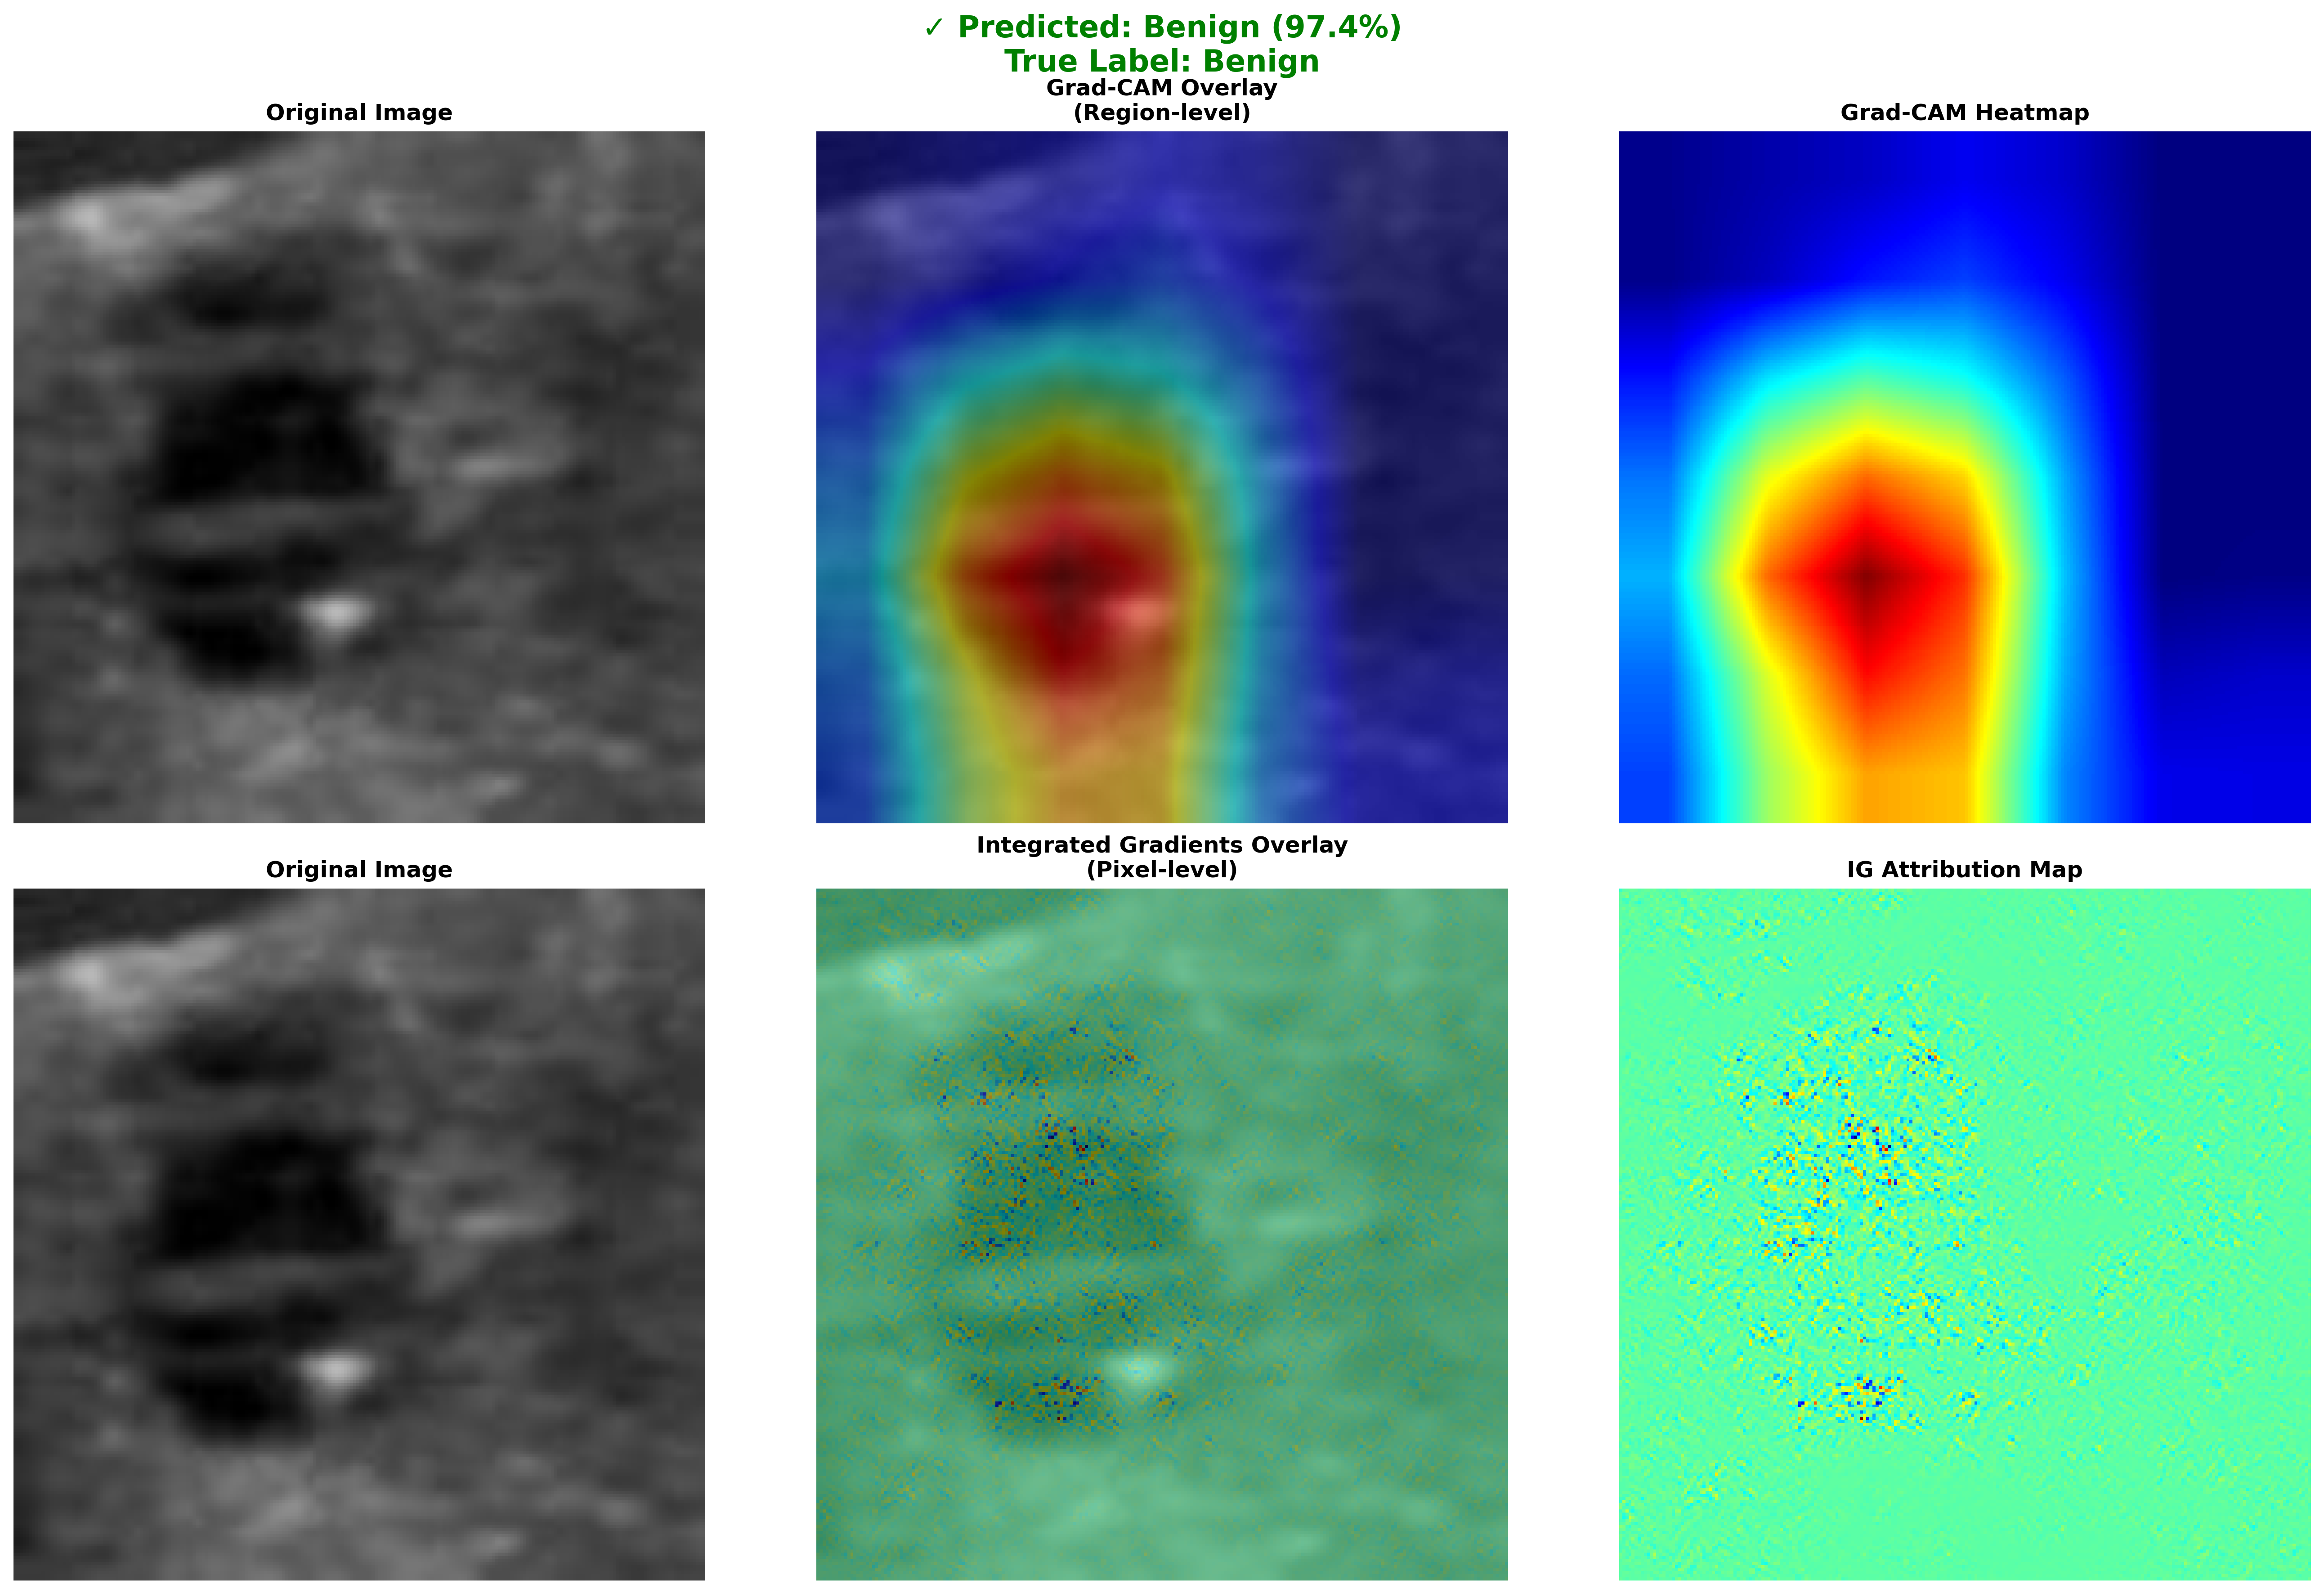


2. dual_xai_sample_02_correct.png


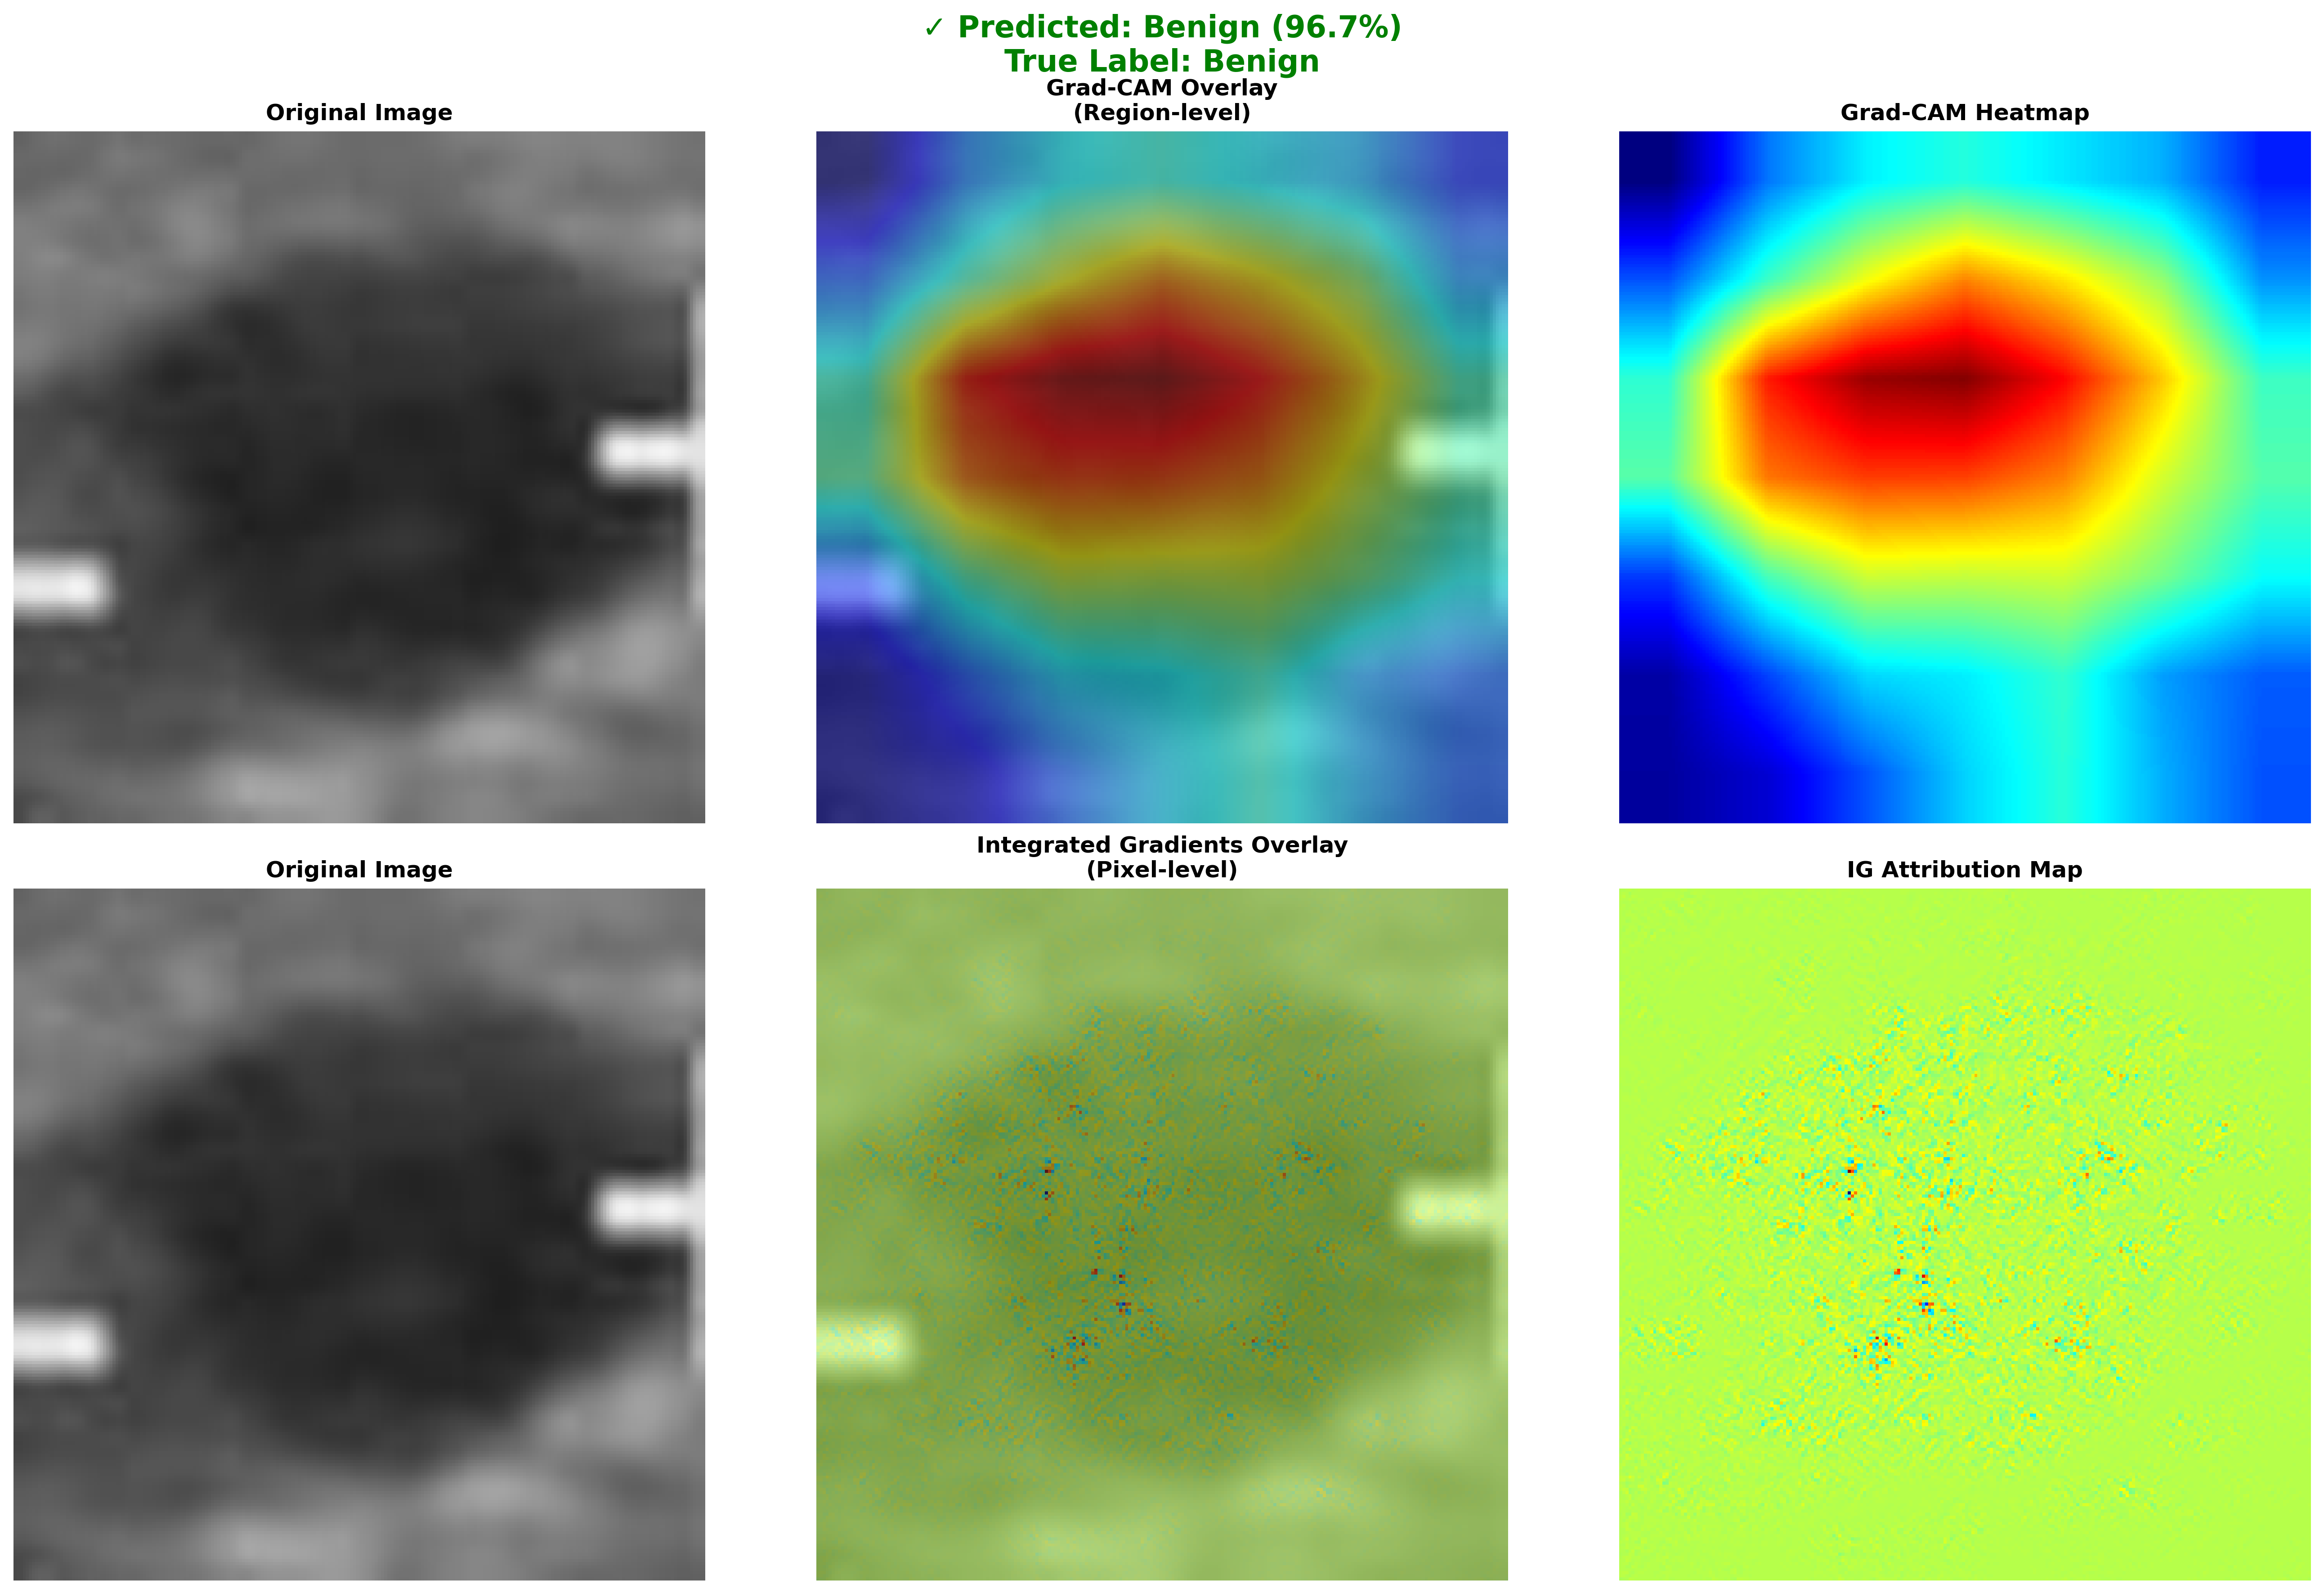


3. dual_xai_sample_03_correct.png


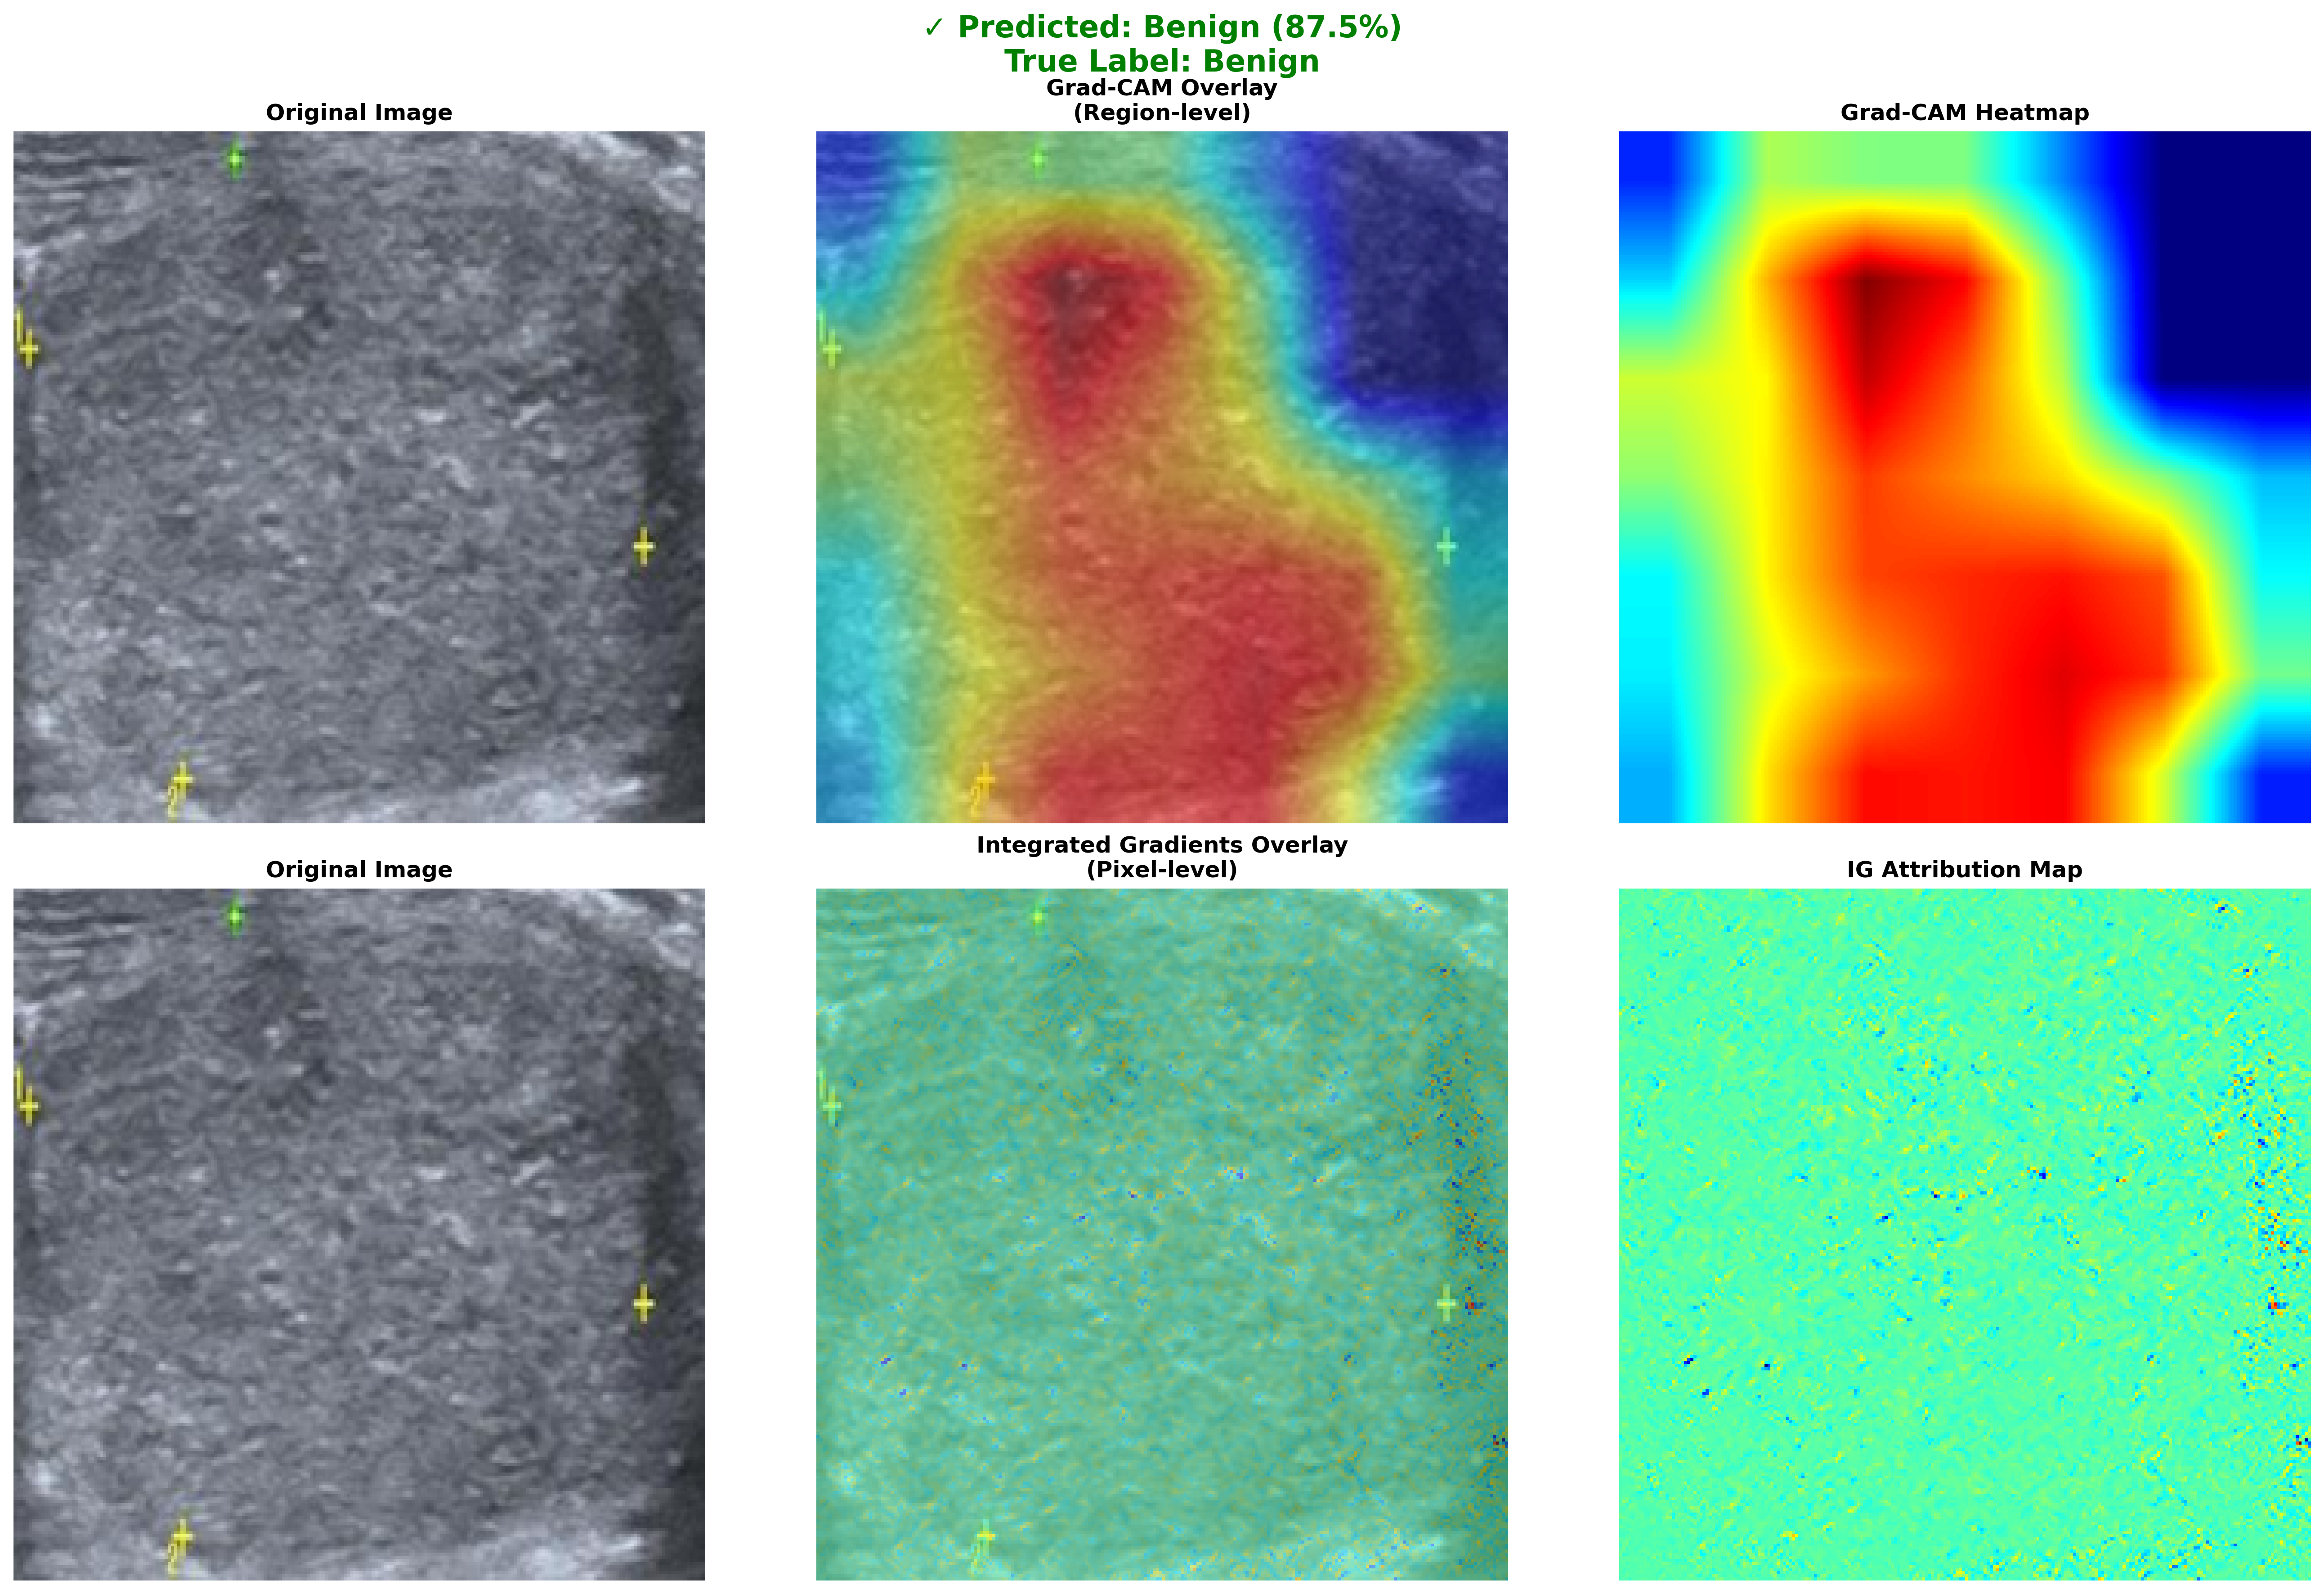


✅ CODE EXECUTION COMPLETE!



In [ ]:
# ============================================================
# DUAL XAI: GRAD-CAM + INTEGRATED GRADIENTS FOR RESNET-54
# FIXED VERSION - Device Compatibility
# ============================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.resnet import ResNet, Bottleneck
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("DUAL XAI FRAMEWORK: GRAD-CAM + INTEGRATED GRADIENTS")
print("="*80)
print("\n📚 Explainability Methods:")
print("1. Grad-CAM: Region-level visualization (high-level features)")
print("2. Integrated Gradients: Pixel-level attribution (fine-grained)")
print("\n" + "="*80 + "\n")

# ============================================================
# CONFIGURATION
# ============================================================
MODEL_PATH = "/content/drive/MyDrive/FDL_Thyroid_Disease/Models/resnet54_v2_REGULARIZED_acc0.9182.pth"
MANIFEST_CSV = "/content/drive/MyDrive/FDL_Thyroid_Disease/Project/tn5000_crops_manifest.csv"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR = "xai_results_dual"
NUM_SAMPLES = 12  # Number of samples to visualize

os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(f"{SAVE_DIR}/gradcam", exist_ok=True)
os.makedirs(f"{SAVE_DIR}/integrated_gradients", exist_ok=True)
os.makedirs(f"{SAVE_DIR}/combined", exist_ok=True)

print(f"🖥️  Device: {DEVICE}")
print(f"📁 Results will be saved to: {SAVE_DIR}/\n")

# ============================================================
# Dataset Class
# ============================================================
class UltrasoundDataset(Dataset):
    def __init__(self, dataframe, transform=None, return_path=False):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        self.return_path = return_path

        if self.data['label'].dtype == 'O':
            label_map = {'benign': 0, 'malignant': 1, 0: 0, 1: 1}
            self.data['label'] = self.data['label'].map(label_map)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = None
        if 'out_path' in row and pd.notna(row['out_path']):
            img_path = row['out_path']
        if img_path is None or not os.path.exists(img_path):
            if 'crop_name' in row:
                img_path = row['crop_name']

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            img = Image.new('RGB', (224, 224), color='white')

        label = torch.tensor(int(row['label']), dtype=torch.long)

        if self.transform:
            img_tensor = self.transform(img)

        if self.return_path:
            return img_tensor, label, img_path, img
        return img_tensor, label

# ============================================================
# ResNet-54 Model Architecture
# ============================================================
class CustomResNetWithDropout(ResNet):
    def __init__(self, layers, num_classes=2, dropout_p=0.4, pretrained=False):
        super().__init__(block=Bottleneck, layers=layers, num_classes=1000)
        num_features = self.fc.in_features
        self.fc = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(num_features, num_classes)
        )

def resnet54_v2_regularized(num_classes=2, dropout_p=0.4, pretrained=False):
    return CustomResNetWithDropout([3, 5, 6, 3], num_classes, dropout_p, pretrained)

# ============================================================
# XAI METHOD 1: GRAD-CAM (FIXED)
# ============================================================
class GradCAM:
    """
    Grad-CAM: Gradient-weighted Class Activation Mapping

    Generates visual heatmaps showing which regions the model focuses on.
    Uses gradients from the last convolutional layer to weight feature maps.

    Pros: Fast, intuitive, region-level explanations
    Best for: Localizing diagnostic features (nodules, tumors)
    """
    def __init__(self, model, target_layer, device):
        self.model = model
        self.target_layer = target_layer
        self.device = device  # FIX: Store device
        self.gradients = None
        self.activations = None

        # Register hooks to capture gradients and activations
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor, class_idx=None):
        # Forward pass
        self.model.eval()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        target = output[0, class_idx]
        target.backward()

        # Generate CAM
        gradients = self.gradients[0]  # [C, H, W]
        activations = self.activations[0]  # [C, H, W]

        # Global average pooling of gradients (importance weights)
        weights = torch.mean(gradients, dim=(1, 2))  # [C]

        # FIX: Create cam tensor on the same device as activations
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=self.device)

        # Weighted combination of feature maps
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # ReLU to keep only positive contributions
        cam = F.relu(cam)

        # Normalize to [0, 1]
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.cpu().numpy(), class_idx, output

# ============================================================
# XAI METHOD 2: INTEGRATED GRADIENTS (FIXED)
# ============================================================
class IntegratedGradients:
    """
    Integrated Gradients: Pixel-level attribution method

    Computes gradients along a path from baseline to input image.
    Provides fine-grained attribution scores for each pixel.

    Pros: Mathematically principled, stable, pixel-level precision
    Best for: Understanding texture, edges, microcalcifications
    """
    def __init__(self, model, device):
        self.model = model
        self.device = device  # FIX: Store device

    def generate_baseline(self, input_tensor):
        """Create baseline (all zeros - black image)"""
        return torch.zeros_like(input_tensor)

    def compute_gradients(self, input_tensor, target_class):
        """Compute gradients of target class w.r.t. input"""
        input_tensor.requires_grad = True
        output = self.model(input_tensor)

        self.model.zero_grad()
        target = output[0, target_class]
        target.backward()

        return input_tensor.grad.detach()

    def generate_attribution(self, input_tensor, target_class=None, steps=50):
        """
        Generate Integrated Gradients attribution map

        Steps:
        1. Create baseline (black image)
        2. Generate interpolated images from baseline to input
        3. Compute gradients at each step
        4. Integrate (sum) gradients
        5. Multiply by (input - baseline)
        """
        self.model.eval()

        # Get prediction if target_class not specified
        if target_class is None:
            with torch.no_grad():
                output = self.model(input_tensor)
                target_class = output.argmax(dim=1).item()

        # Generate baseline
        baseline = self.generate_baseline(input_tensor)

        # Generate interpolated images
        scaled_inputs = [
            baseline + (float(i) / steps) * (input_tensor - baseline)
            for i in range(steps + 1)
        ]

        # Compute gradients for each interpolated image
        gradients = []
        for scaled_input in scaled_inputs:
            grad = self.compute_gradients(scaled_input, target_class)
            gradients.append(grad)

        # Average gradients
        avg_gradients = torch.mean(torch.stack(gradients), dim=0)

        # Integrated gradients = (input - baseline) * average_gradients
        integrated_grads = (input_tensor - baseline) * avg_gradients

        # Sum across color channels for visualization
        attribution = integrated_grads.squeeze(0).sum(dim=0).cpu().numpy()

        # Normalize to [0, 1]
        attribution = attribution - attribution.min()
        attribution = attribution / (attribution.max() + 1e-8)

        return attribution, target_class

# ============================================================
# Visualization Functions
# ============================================================
def apply_colormap(activation_map, colormap=cv2.COLORMAP_JET):
    """Convert grayscale activation map to colored heatmap"""
    heatmap = np.uint8(255 * activation_map)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    return heatmap

def overlay_heatmap(original_img, activation_map, alpha=0.5):
    """Overlay heatmap on original image"""
    # Resize activation map to match image size
    if isinstance(original_img, Image.Image):
        original_img = np.array(original_img)

    h, w = original_img.shape[:2]
    activation_resized = cv2.resize(activation_map, (w, h))

    # Apply colormap
    heatmap = apply_colormap(activation_resized)

    # Blend
    superimposed = cv2.addWeighted(original_img, 1-alpha, heatmap, alpha, 0)
    return superimposed, heatmap

def create_dual_visualization(original_img, gradcam_map, ig_map,
                              prediction, true_label, confidence, save_path=None):
    """
    Create comprehensive visualization showing both XAI methods

    Layout:
    Row 1: Original | Grad-CAM overlay | Grad-CAM heatmap
    Row 2: Original | IG overlay       | IG heatmap
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    class_names = ['Benign', 'Malignant']

    # Resize original image
    if isinstance(original_img, Image.Image):
        original_img = original_img.resize((224, 224))
        original_img_np = np.array(original_img)
    else:
        original_img_np = original_img

    # Row 1: Grad-CAM
    gradcam_overlay, gradcam_heatmap = overlay_heatmap(original_img_np, gradcam_map)

    axes[0, 0].imshow(original_img_np)
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(gradcam_overlay)
    axes[0, 1].set_title('Grad-CAM Overlay\n(Region-level)', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(gradcam_heatmap)
    axes[0, 2].set_title('Grad-CAM Heatmap', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')

    # Row 2: Integrated Gradients
    ig_overlay, ig_heatmap = overlay_heatmap(original_img_np, ig_map)

    axes[1, 0].imshow(original_img_np)
    axes[1, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(ig_overlay)
    axes[1, 1].set_title('Integrated Gradients Overlay\n(Pixel-level)', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(ig_heatmap)
    axes[1, 2].set_title('IG Attribution Map', fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')

    # Add prediction info
    pred_text = f"Predicted: {class_names[prediction]} ({confidence:.1f}%)\n"
    pred_text += f"True Label: {class_names[true_label]}"
    correct = "✓" if prediction == true_label else "✗"
    color = 'green' if prediction == true_label else 'red'

    fig.suptitle(f"{correct} {pred_text}", fontsize=16, fontweight='bold', color=color, y=0.98)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

# ============================================================
# Main XAI Pipeline
# ============================================================
print("📂 Loading test data...")
full_data = pd.read_csv(MANIFEST_CSV)
test_data = full_data[full_data['split'] == 'test'].copy()

# Select diverse samples
benign_samples = test_data[test_data['label'] == 0].sample(n=NUM_SAMPLES//2, random_state=42)
malignant_samples = test_data[test_data['label'] == 1].sample(n=NUM_SAMPLES//2, random_state=42)
selected_samples = pd.concat([benign_samples, malignant_samples]).reset_index(drop=True)

print(f"✓ Selected {len(selected_samples)} test samples\n")

# Transforms
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset
test_dataset = UltrasoundDataset(selected_samples, transform=test_transforms, return_path=True)

# Load model
print("🔧 Loading ResNet-54 model...")
model = resnet54_v2_regularized(num_classes=2, dropout_p=0.4, pretrained=False)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model.to(DEVICE)
model.eval()
print("✓ Model loaded\n")

# FIX: Initialize XAI methods with device parameter
print("🎨 Initializing XAI methods...")
target_layer = model.layer4[-1]  # Last convolutional block
gradcam = GradCAM(model, target_layer, DEVICE)  # Pass device
integrated_gradients = IntegratedGradients(model, DEVICE)  # Pass device
print("✓ Grad-CAM initialized (target: layer4[-1])")
print("✓ Integrated Gradients initialized (steps=50)\n")

print("="*80)
print("GENERATING DUAL XAI VISUALIZATIONS")
print("="*80 + "\n")

# Generate visualizations
for idx in tqdm(range(len(test_dataset)), desc="Processing samples"):
    img_tensor, true_label, img_path, original_img = test_dataset[idx]

    # Add batch dimension
    input_tensor = img_tensor.unsqueeze(0).to(DEVICE)

    # Get prediction
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        confidence = probs[0].max().item() * 100
        prediction = output.argmax(dim=1).item()

    # Generate Grad-CAM
    gradcam_map, _, _ = gradcam.generate_cam(input_tensor, class_idx=prediction)

    # Generate Integrated Gradients
    ig_map, _ = integrated_gradients.generate_attribution(input_tensor, target_class=prediction, steps=50)

    # Create dual visualization
    status = "correct" if prediction == true_label.item() else "incorrect"
    save_path = f"{SAVE_DIR}/combined/dual_xai_sample_{idx+1:02d}_{status}.png"

    create_dual_visualization(
        original_img,
        gradcam_map,
        ig_map,
        prediction,
        true_label.item(),
        confidence,
        save_path=save_path
    )

print(f"\n{'='*80}")
print("XAI GENERATION COMPLETE!")
print(f"{'='*80}")
print(f"\n✅ Generated {len(test_dataset)} dual XAI visualizations")
print(f"📁 Saved to: {SAVE_DIR}/combined/")
print(f"\n📊 Results show:")
print(f"   - Grad-CAM: High-level region focus (where the model looks)")
print(f"   - Integrated Gradients: Pixel-level contributions (what pixels matter)")
print(f"   - Multi-scale interpretability for clinical validation")

# Create summary figure
print(f"\n📊 Creating summary comparison grid...")

fig, axes = plt.subplots(3, 4, figsize=(24, 18))
axes = axes.flatten()

import glob
viz_files = sorted(glob.glob(f"{SAVE_DIR}/combined/dual_xai_sample_*.png"))

for idx, viz_path in enumerate(viz_files[:12]):
    img = plt.imread(viz_path)
    axes[idx].imshow(img)
    axes[idx].axis('off')

plt.suptitle('Dual XAI Framework: Grad-CAM + Integrated Gradients\nResNet-54 Thyroid Nodule Classification',
             fontsize=18, fontweight='bold')
plt.tight_layout()
summary_path = f"{SAVE_DIR}/dual_xai_summary_grid.png"
plt.savefig(summary_path, dpi=300, bbox_inches='tight')
print(f"✓ Summary grid saved: {summary_path}")
plt.close()

print(f"\n{'='*80}")
print("ALL XAI VISUALIZATIONS READY FOR PUBLICATION!")
print(f"{'='*80}\n")

print("📝 For your paper, you can write:")
print('"We employed a dual explainability framework combining Grad-CAM and')
print('Integrated Gradients to provide multi-scale interpretability. Grad-CAM')
print('visualizes high-level feature activations from the final convolutional layer,')
print('revealing which anatomical regions contribute to classification decisions.')
print('Integrated Gradients computes pixel-wise attribution scores along the path')
print('from a baseline image, offering fine-grained analysis of discriminative')
print('features such as nodule margins and internal textures. Together, these')
print('complementary methods enable comprehensive clinical validation of model')
print('predictions at both region and pixel levels."')

# Display sample visualizations
print(f"\n📊 DISPLAYING SAMPLE RESULTS:\n")
from IPython.display import Image as IPImage, display

for i, viz_path in enumerate(viz_files[:3]):
    print(f"\n{i+1}. {viz_path.split('/')[-1]}")
    display(IPImage(filename=viz_path))

print(f"\n{'='*80}")
print("✅ CODE EXECUTION COMPLETE!")
print(f"{'='*80}\n")


DUAL XAI: GRAD-CAM + INTEGRATED GRADIENTS
BALANCED SAMPLING: 6 BENIGN + 6 MALIGNANT

🖥️  Device: cuda
📁 Results: xai_results_dual/

📂 Loading test data...
Test set statistics:
  Total: 1004
  Benign (0): 271
  Malignant (1): 733

✓ Selected balanced samples:
  Benign: 6
  Malignant: 6
  Total: 12

🔧 Loading model...
✓ Model loaded

✓ XAI methods initialized

GENERATING VISUALIZATIONS



Processing: 100%|██████████| 12/12 [00:44<00:00,  3.69s/it]



GENERATION COMPLETE!

✅ Generated 12 visualizations:
   - Benign cases: 6
   - Malignant cases: 6

📁 Saved to: xai_results_dual/combined/

📋 Generated files:
   dual_xai_sample_01_correct.png
   dual_xai_sample_02_correct.png
   dual_xai_sample_03_correct.png
   dual_xai_sample_04_correct.png
   dual_xai_sample_05_correct.png
   dual_xai_sample_06_incorrect.png
   dual_xai_sample_07_correct.png
   dual_xai_sample_08_correct.png
   dual_xai_sample_09_correct.png
   dual_xai_sample_10_correct.png
   dual_xai_sample_11_correct.png
   dual_xai_sample_12_incorrect.png
   sample_01_malignant_correct.png
   sample_02_malignant_correct.png
   sample_03_benign_correct.png
   sample_04_malignant_correct.png
   sample_05_benign_incorrect.png
   sample_06_benign_correct.png
   sample_07_benign_correct.png
   sample_08_malignant_incorrect.png
   sample_09_benign_correct.png
   sample_10_malignant_correct.png
   sample_11_benign_correct.png
   sample_12_malignant_correct.png

📊 Creating summary gri

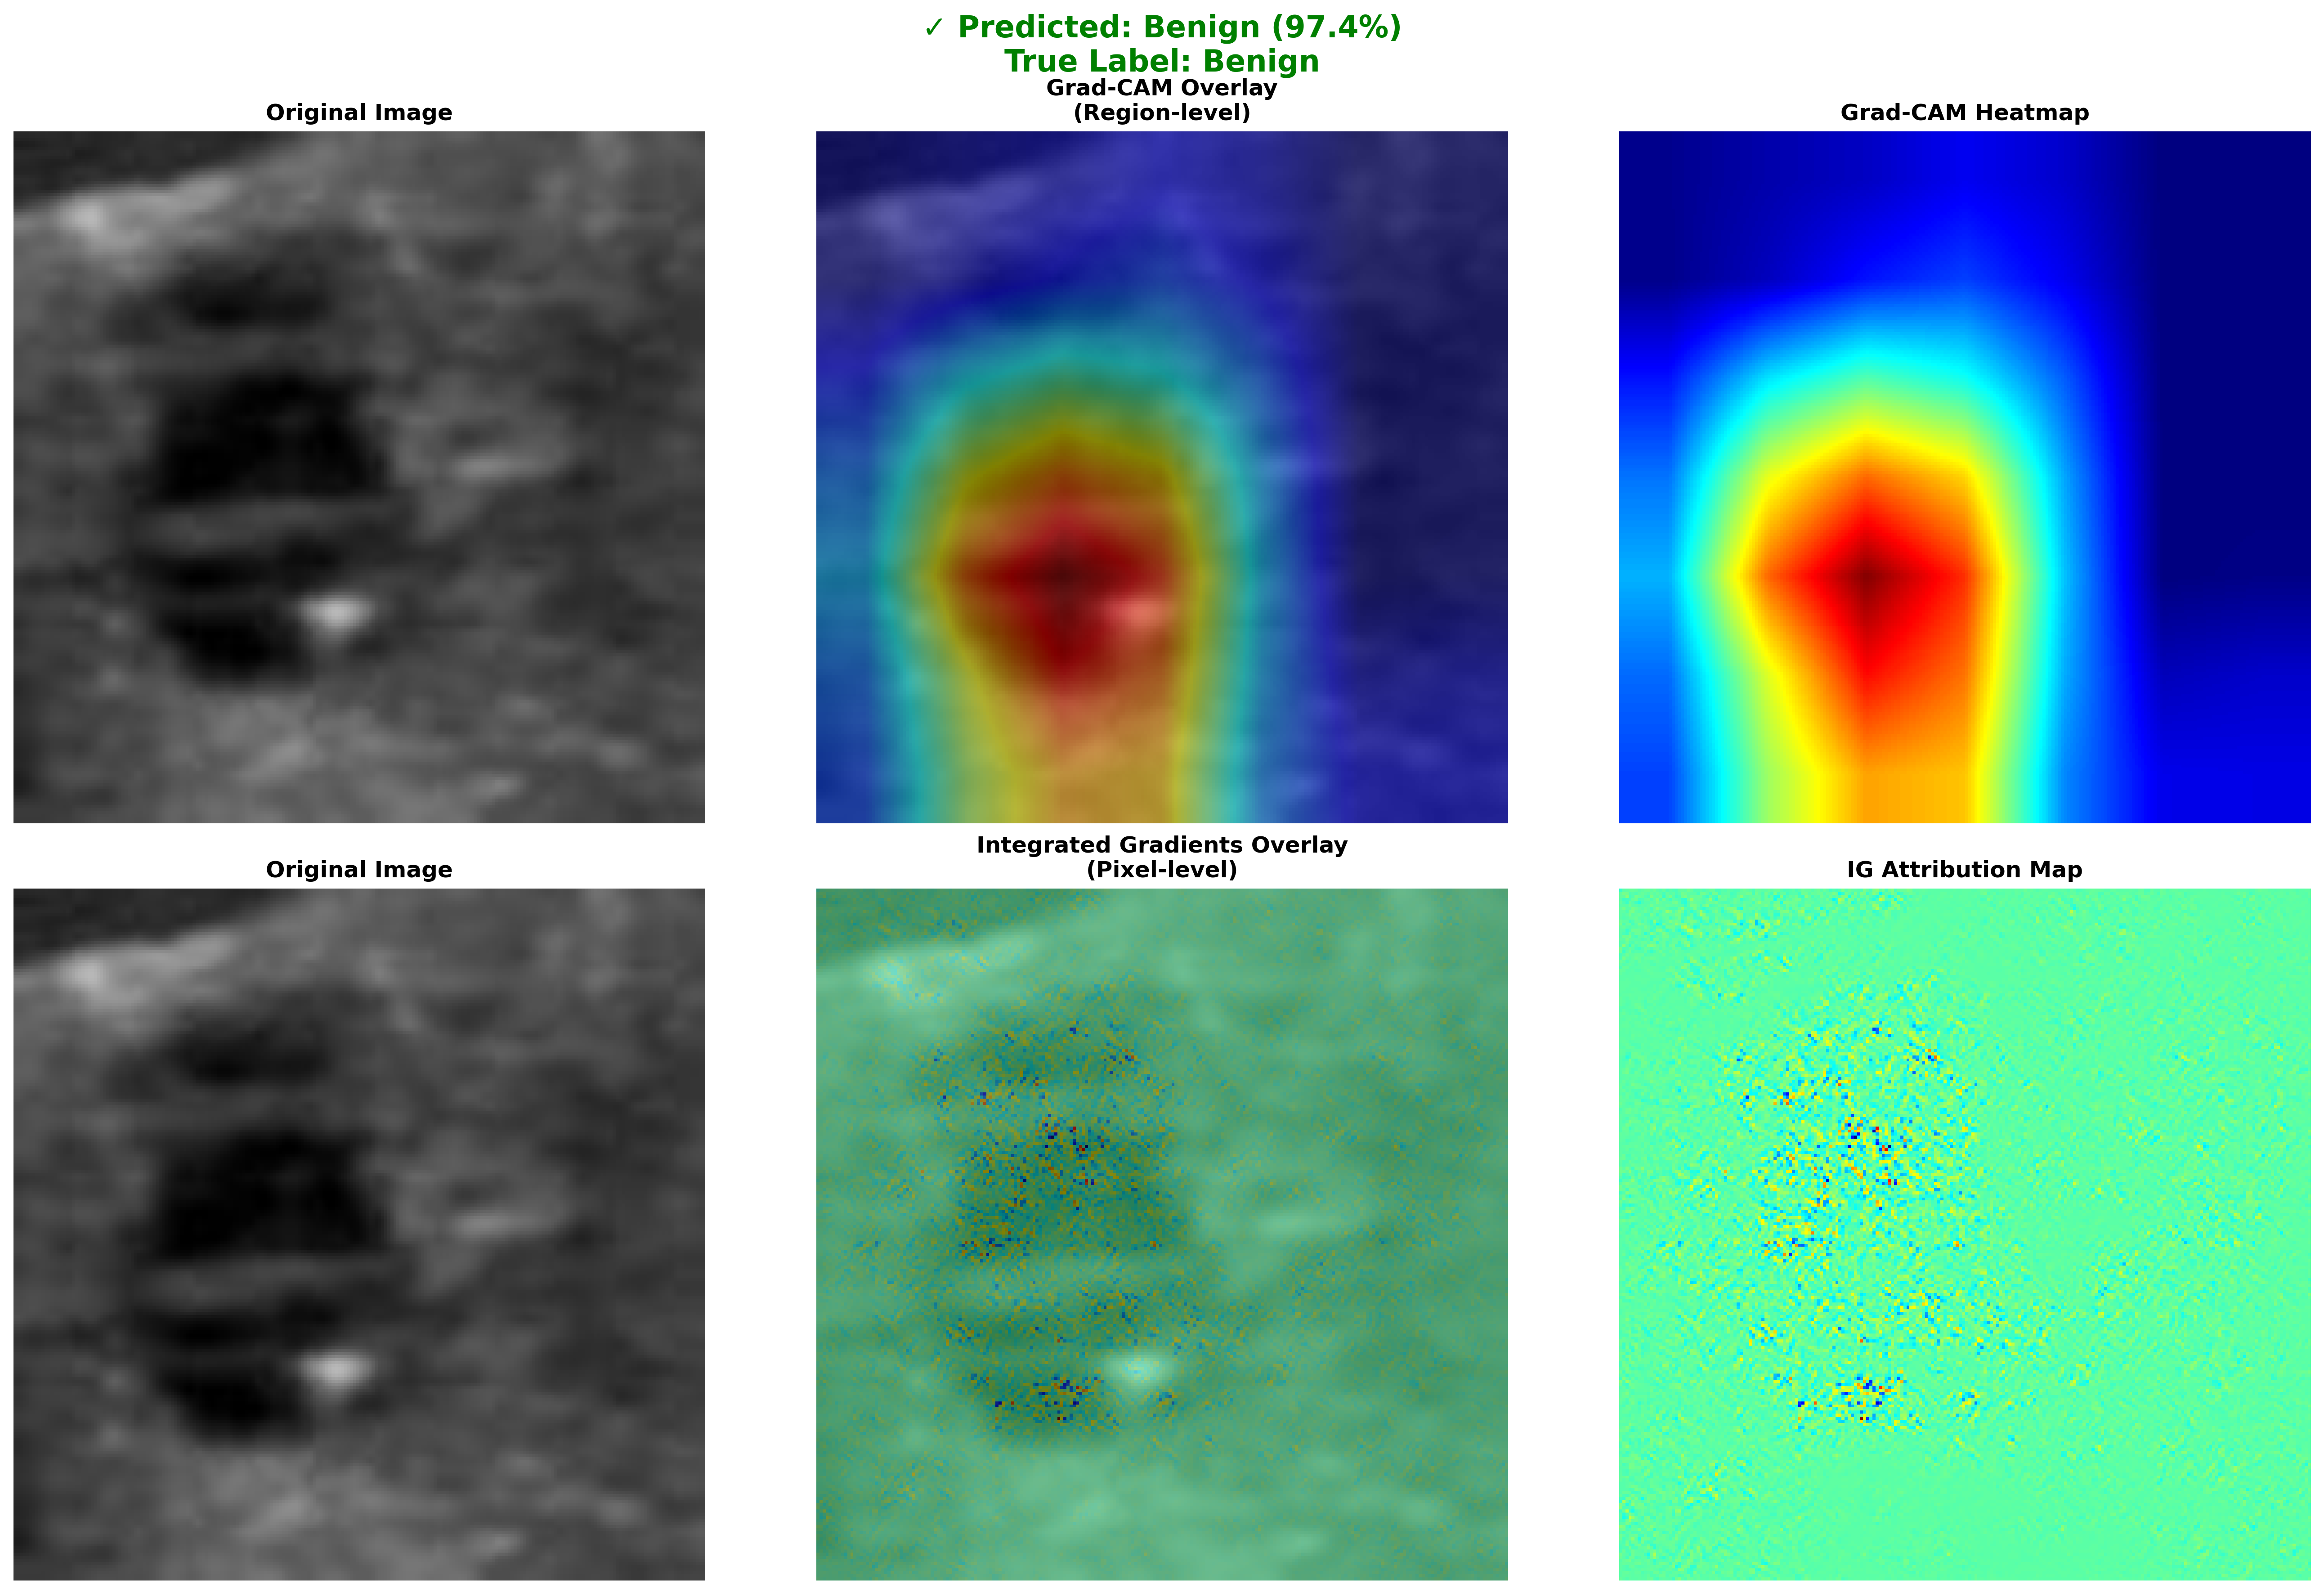


2. dual_xai_sample_02_correct.png


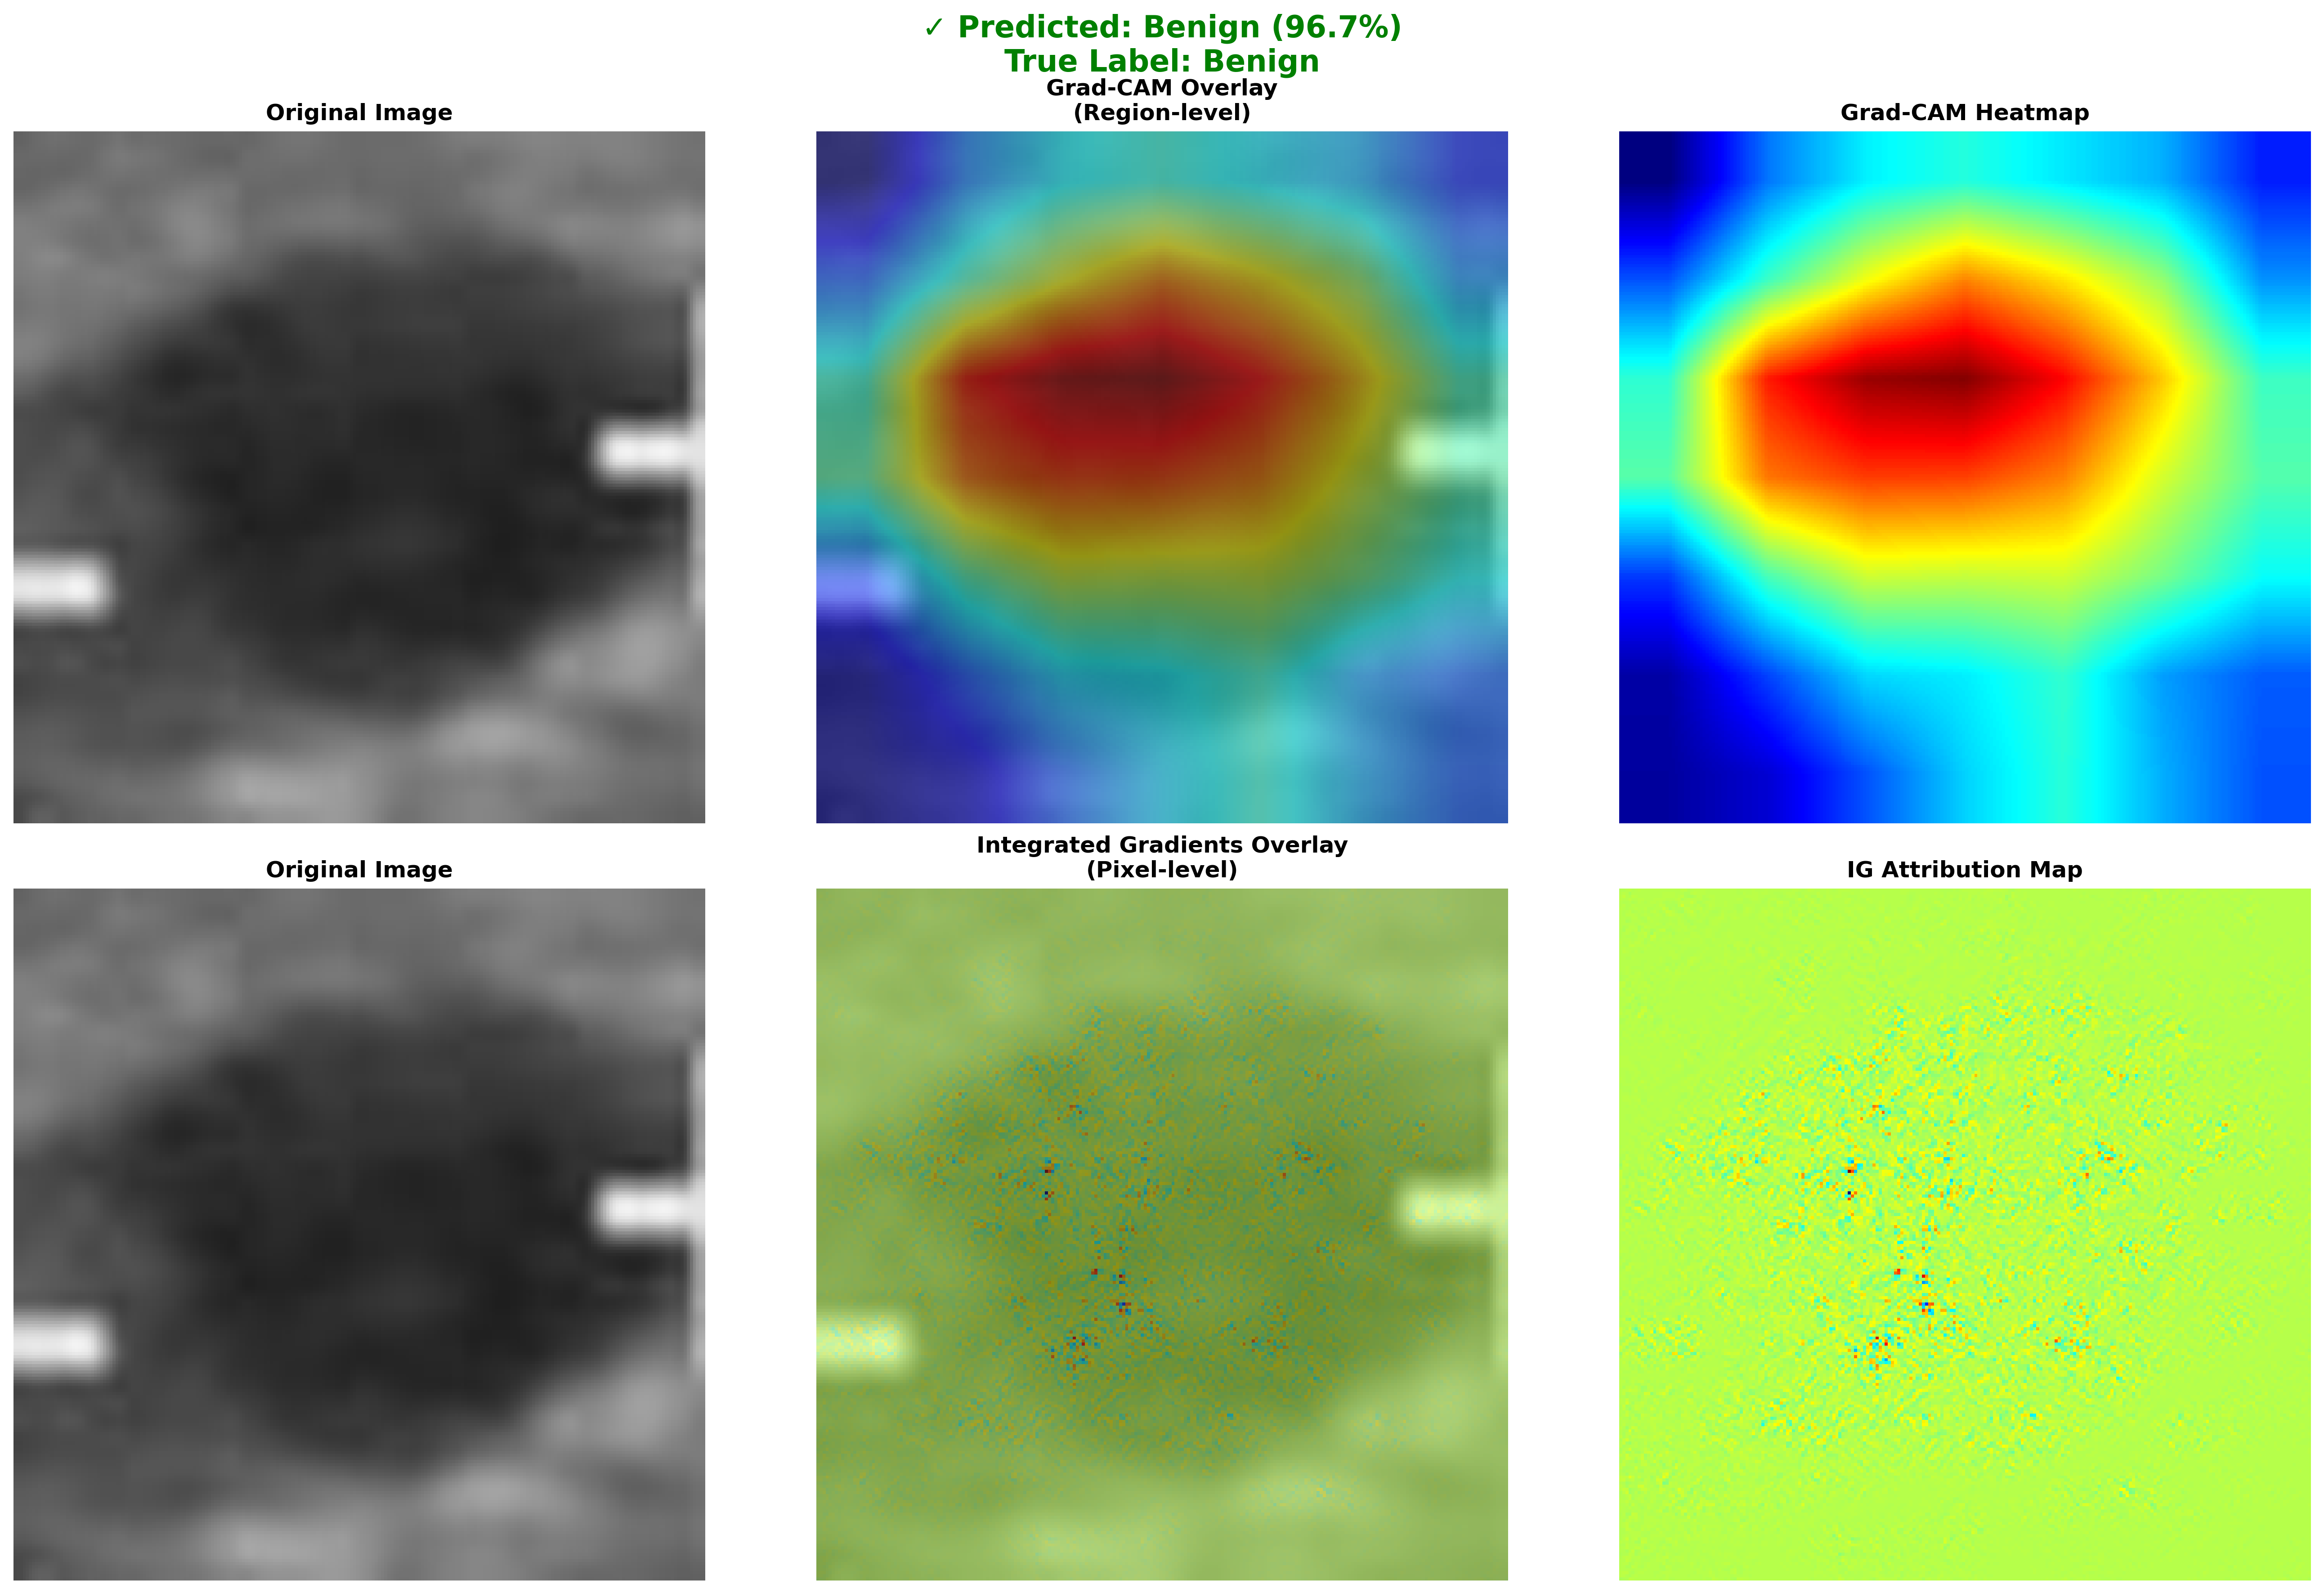


3. dual_xai_sample_03_correct.png


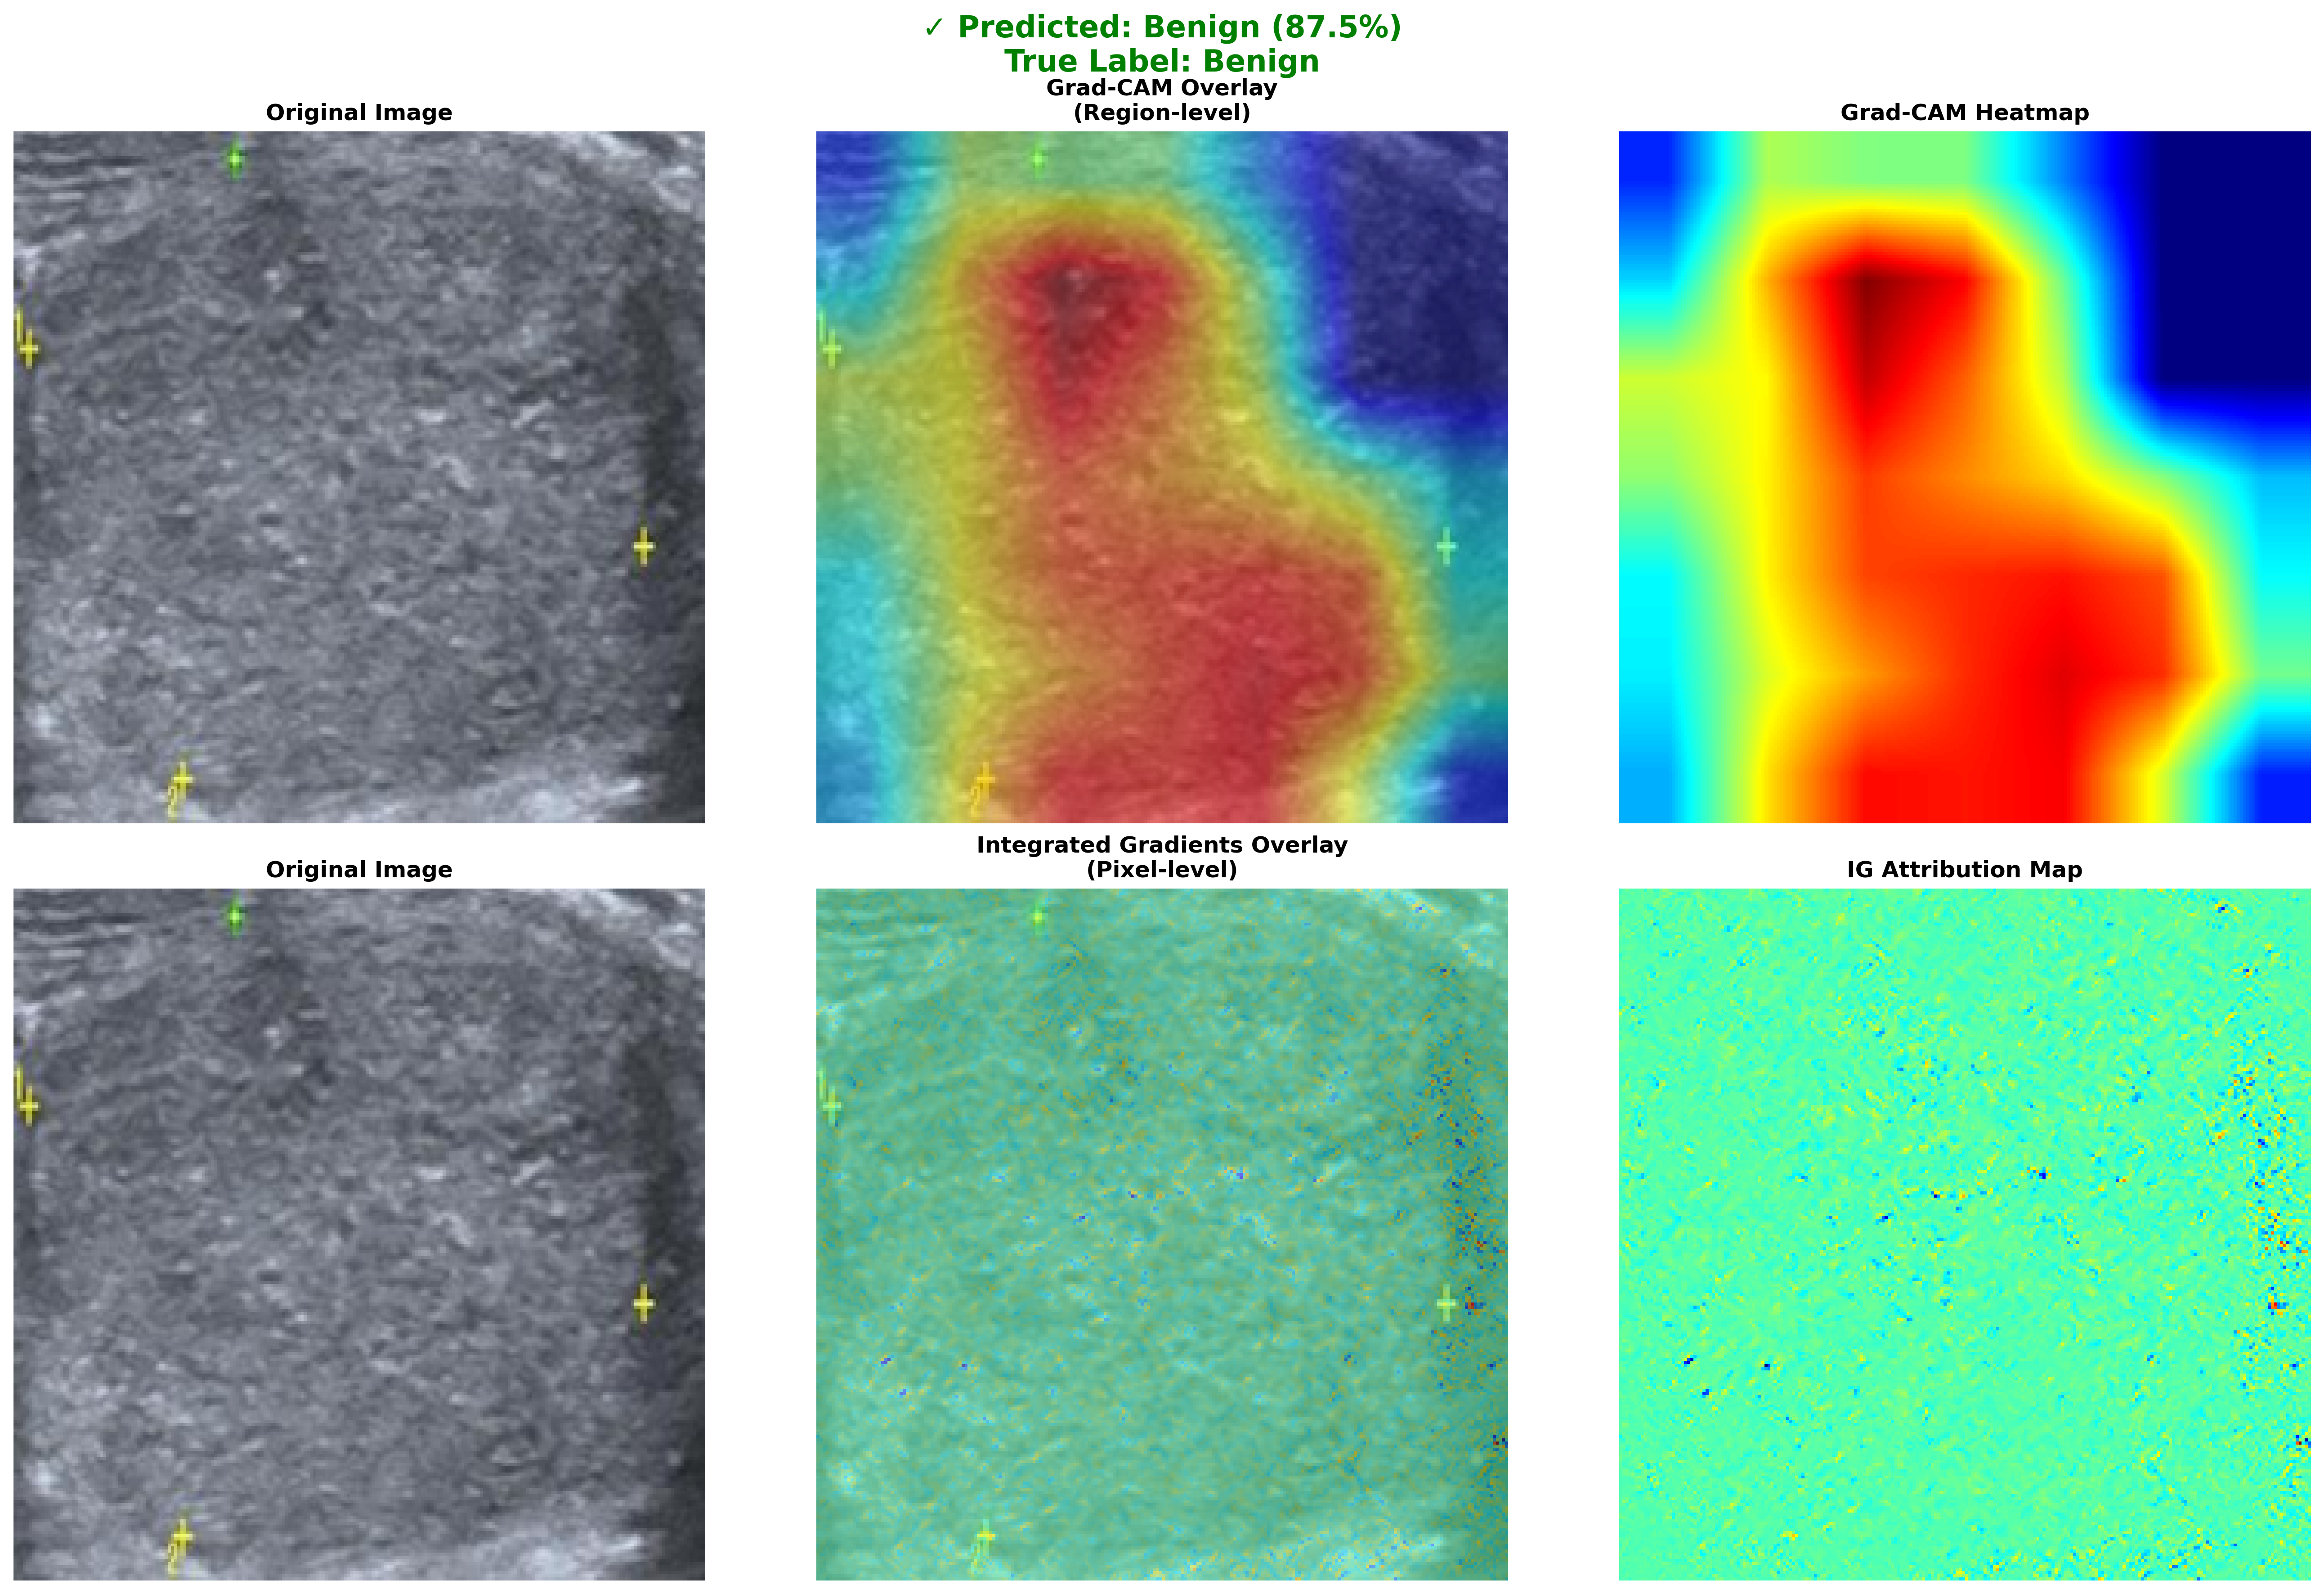


4. dual_xai_sample_04_correct.png


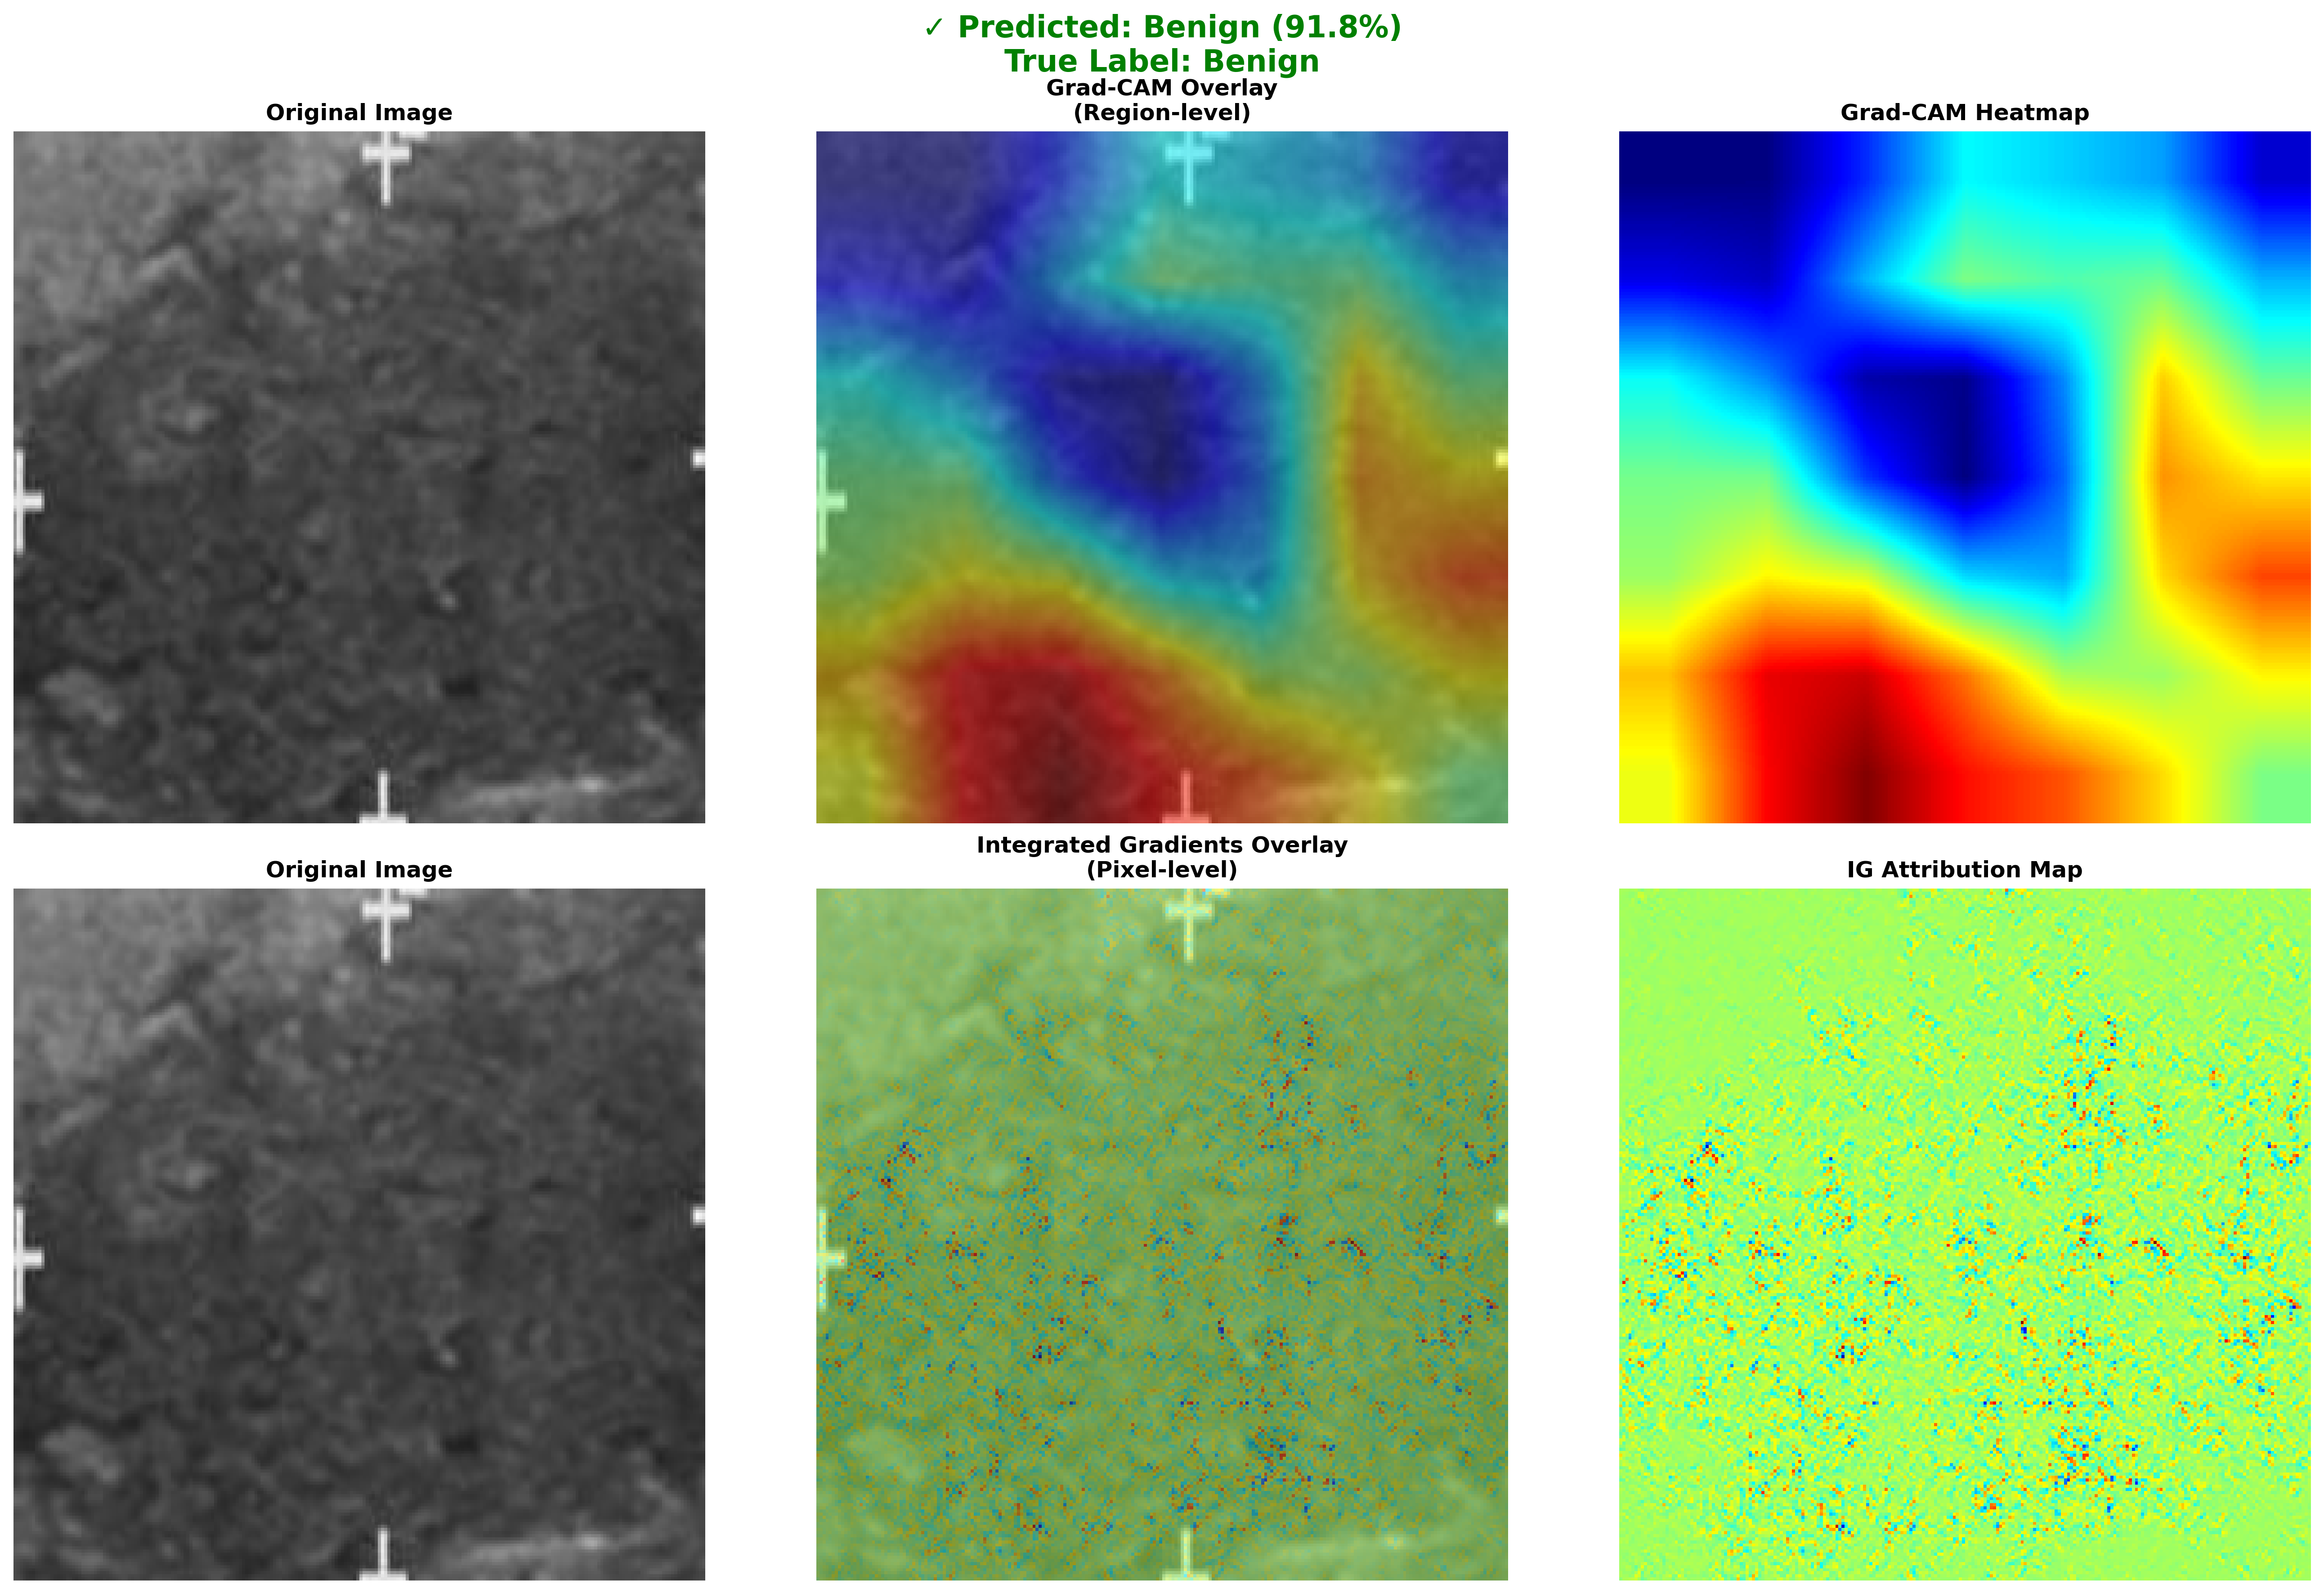


✅ ALL DONE! Check the file names to verify both classes.



In [ ]:
# ============================================================
# DUAL XAI - BALANCED BENIGN & MALIGNANT VISUALIZATION
# ============================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.resnet import ResNet, Bottleneck
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("DUAL XAI: GRAD-CAM + INTEGRATED GRADIENTS")
print("BALANCED SAMPLING: 6 BENIGN + 6 MALIGNANT")
print("="*80 + "\n")

# ============================================================
# CONFIGURATION
# ============================================================
MODEL_PATH = "/content/drive/MyDrive/FDL_Thyroid_Disease/Models/resnet54_v2_REGULARIZED_acc0.9182.pth"
MANIFEST_CSV = "/content/drive/MyDrive/FDL_Thyroid_Disease/Project/tn5000_crops_manifest.csv"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR = "xai_results_dual"
NUM_SAMPLES_PER_CLASS = 6  # 6 benign + 6 malignant = 12 total

os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(f"{SAVE_DIR}/combined", exist_ok=True)

print(f"🖥️  Device: {DEVICE}")
print(f"📁 Results: {SAVE_DIR}/\n")

# ============================================================
# Dataset Class
# ============================================================
class UltrasoundDataset(Dataset):
    def __init__(self, dataframe, transform=None, return_path=False):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        self.return_path = return_path

        if self.data['label'].dtype == 'O':
            label_map = {'benign': 0, 'malignant': 1, 0: 0, 1: 1}
            self.data['label'] = self.data['label'].map(label_map)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = None
        if 'out_path' in row and pd.notna(row['out_path']):
            img_path = row['out_path']
        if img_path is None or not os.path.exists(img_path):
            if 'crop_name' in row:
                img_path = row['crop_name']

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            img = Image.new('RGB', (224, 224), color='white')

        label = torch.tensor(int(row['label']), dtype=torch.long)

        if self.transform:
            img_tensor = self.transform(img)

        if self.return_path:
            return img_tensor, label, img_path, img
        return img_tensor, label

# ============================================================
# ResNet-54 Model
# ============================================================
class CustomResNetWithDropout(ResNet):
    def __init__(self, layers, num_classes=2, dropout_p=0.4, pretrained=False):
        super().__init__(block=Bottleneck, layers=layers, num_classes=1000)
        num_features = self.fc.in_features
        self.fc = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(num_features, num_classes)
        )

def resnet54_v2_regularized(num_classes=2, dropout_p=0.4, pretrained=False):
    return CustomResNetWithDropout([3, 5, 6, 3], num_classes, dropout_p, pretrained)

# ============================================================
# Grad-CAM
# ============================================================
class GradCAM:
    def __init__(self, model, target_layer, device):
        self.model = model
        self.target_layer = target_layer
        self.device = device
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        target = output[0, class_idx]
        target.backward()

        gradients = self.gradients[0]
        activations = self.activations[0]

        weights = torch.mean(gradients, dim=(1, 2))
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=self.device)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.cpu().numpy(), class_idx, output

# ============================================================
# Integrated Gradients
# ============================================================
class IntegratedGradients:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def generate_baseline(self, input_tensor):
        return torch.zeros_like(input_tensor)

    def compute_gradients(self, input_tensor, target_class):
        input_tensor.requires_grad = True
        output = self.model(input_tensor)

        self.model.zero_grad()
        target = output[0, target_class]
        target.backward()

        return input_tensor.grad.detach()

    def generate_attribution(self, input_tensor, target_class=None, steps=50):
        self.model.eval()

        if target_class is None:
            with torch.no_grad():
                output = self.model(input_tensor)
                target_class = output.argmax(dim=1).item()

        baseline = self.generate_baseline(input_tensor)

        scaled_inputs = [
            baseline + (float(i) / steps) * (input_tensor - baseline)
            for i in range(steps + 1)
        ]

        gradients = []
        for scaled_input in scaled_inputs:
            grad = self.compute_gradients(scaled_input, target_class)
            gradients.append(grad)

        avg_gradients = torch.mean(torch.stack(gradients), dim=0)
        integrated_grads = (input_tensor - baseline) * avg_gradients

        attribution = integrated_grads.squeeze(0).sum(dim=0).cpu().numpy()
        attribution = attribution - attribution.min()
        attribution = attribution / (attribution.max() + 1e-8)

        return attribution, target_class

# ============================================================
# Visualization
# ============================================================
def apply_colormap(activation_map, colormap=cv2.COLORMAP_JET):
    heatmap = np.uint8(255 * activation_map)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    return heatmap

def overlay_heatmap(original_img, activation_map, alpha=0.5):
    if isinstance(original_img, Image.Image):
        original_img = np.array(original_img)

    h, w = original_img.shape[:2]
    activation_resized = cv2.resize(activation_map, (w, h))
    heatmap = apply_colormap(activation_resized)
    superimposed = cv2.addWeighted(original_img, 1-alpha, heatmap, alpha, 0)
    return superimposed, heatmap

def create_dual_visualization(original_img, gradcam_map, ig_map,
                              prediction, true_label, confidence, sample_idx, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    class_names = ['Benign', 'Malignant']

    if isinstance(original_img, Image.Image):
        original_img = original_img.resize((224, 224))
        original_img_np = np.array(original_img)
    else:
        original_img_np = original_img

    # Row 1: Grad-CAM
    gradcam_overlay, gradcam_heatmap = overlay_heatmap(original_img_np, gradcam_map)

    axes[0, 0].imshow(original_img_np)
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(gradcam_overlay)
    axes[0, 1].set_title('Grad-CAM Overlay\n(Region-level)', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(gradcam_heatmap)
    axes[0, 2].set_title('Grad-CAM Heatmap', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')

    # Row 2: Integrated Gradients
    ig_overlay, ig_heatmap = overlay_heatmap(original_img_np, ig_map)

    axes[1, 0].imshow(original_img_np)
    axes[1, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(ig_overlay)
    axes[1, 1].set_title('Integrated Gradients Overlay\n(Pixel-level)', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(ig_heatmap)
    axes[1, 2].set_title('IG Attribution Map', fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')

    # Title with class information
    pred_text = f"Sample {sample_idx}: Predicted: {class_names[prediction]} ({confidence:.1f}%) | "
    pred_text += f"True: {class_names[true_label]}"
    correct = "✓ CORRECT" if prediction == true_label else "✗ INCORRECT"
    color = 'green' if prediction == true_label else 'red'

    fig.suptitle(f"{correct} - {pred_text}", fontsize=16, fontweight='bold', color=color, y=0.98)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

# ============================================================
# Main Pipeline
# ============================================================
print("📂 Loading test data...")
full_data = pd.read_csv(MANIFEST_CSV)
test_data = full_data[full_data['split'] == 'test'].copy()

print(f"Test set statistics:")
print(f"  Total: {len(test_data)}")
print(f"  Benign (0): {len(test_data[test_data['label'] == 0])}")
print(f"  Malignant (1): {len(test_data[test_data['label'] == 1])}\n")

# BALANCED SAMPLING
benign_samples = test_data[test_data['label'] == 0].sample(n=NUM_SAMPLES_PER_CLASS, random_state=42)
malignant_samples = test_data[test_data['label'] == 1].sample(n=NUM_SAMPLES_PER_CLASS, random_state=42)

# Concatenate and shuffle
selected_samples = pd.concat([benign_samples, malignant_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✓ Selected balanced samples:")
print(f"  Benign: {len(selected_samples[selected_samples['label'] == 0])}")
print(f"  Malignant: {len(selected_samples[selected_samples['label'] == 1])}")
print(f"  Total: {len(selected_samples)}\n")

# Transforms
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = UltrasoundDataset(selected_samples, transform=test_transforms, return_path=True)

# Load model
print("🔧 Loading model...")
model = resnet54_v2_regularized(num_classes=2, dropout_p=0.4, pretrained=False)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model.to(DEVICE)
model.eval()
print("✓ Model loaded\n")

# Initialize XAI
target_layer = model.layer4[-1]
gradcam = GradCAM(model, target_layer, DEVICE)
integrated_gradients = IntegratedGradients(model, DEVICE)
print("✓ XAI methods initialized\n")

print("="*80)
print("GENERATING VISUALIZATIONS")
print("="*80 + "\n")

# Track class distribution in outputs
benign_count = 0
malignant_count = 0

# Generate visualizations
for idx in tqdm(range(len(test_dataset)), desc="Processing"):
    img_tensor, true_label, img_path, original_img = test_dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(DEVICE)

    # Get prediction
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        confidence = probs[0].max().item() * 100
        prediction = output.argmax(dim=1).item()

    # Track distribution
    if true_label.item() == 0:
        benign_count += 1
    else:
        malignant_count += 1

    # Generate XAI
    gradcam_map, _, _ = gradcam.generate_cam(input_tensor, class_idx=prediction)
    ig_map, _ = integrated_gradients.generate_attribution(input_tensor, target_class=prediction, steps=50)

    # Save
    class_names = ['benign', 'malignant']
    true_class = class_names[true_label.item()]
    status = "correct" if prediction == true_label.item() else "incorrect"
    save_path = f"{SAVE_DIR}/combined/sample_{idx+1:02d}_{true_class}_{status}.png"

    create_dual_visualization(
        original_img,
        gradcam_map,
        ig_map,
        prediction,
        true_label.item(),
        confidence,
        idx + 1,
        save_path=save_path
    )

print(f"\n{'='*80}")
print("GENERATION COMPLETE!")
print(f"{'='*80}")
print(f"\n✅ Generated {len(test_dataset)} visualizations:")
print(f"   - Benign cases: {benign_count}")
print(f"   - Malignant cases: {malignant_count}")
print(f"\n📁 Saved to: {SAVE_DIR}/combined/")

# List files to verify
import glob
viz_files = sorted(glob.glob(f"{SAVE_DIR}/combined/*.png"))
print(f"\n📋 Generated files:")
for f in viz_files:
    print(f"   {f.split('/')[-1]}")

# Create summary grid
print(f"\n📊 Creating summary grid...")
fig, axes = plt.subplots(3, 4, figsize=(24, 18))
axes = axes.flatten()

for idx, viz_path in enumerate(viz_files[:12]):
    img = plt.imread(viz_path)
    axes[idx].imshow(img)
    axes[idx].set_title(viz_path.split('/')[-1], fontsize=8)
    axes[idx].axis('off')

plt.suptitle('Dual XAI: Grad-CAM + Integrated Gradients (Balanced Sampling)\nResNet-54 Thyroid Nodule Classification',
             fontsize=18, fontweight='bold')
plt.tight_layout()
summary_path = f"{SAVE_DIR}/dual_xai_summary_balanced.png"
plt.savefig(summary_path, dpi=300, bbox_inches='tight')
print(f"✓ Summary grid: {summary_path}")
plt.close()

# Display samples
print(f"\n📊 DISPLAYING SAMPLES:\n")
from IPython.display import Image as IPImage, display

for i, viz_path in enumerate(viz_files[:4]):
    print(f"\n{i+1}. {viz_path.split('/')[-1]}")
    display(IPImage(filename=viz_path))

print(f"\n{'='*80}")
print("✅ ALL DONE! Check the file names to verify both classes.")
print(f"{'='*80}\n")


✓ All packages imported successfully!
TESTING REGULARIZED RESNET-54 MODEL

📁 Model file: /content/drive/MyDrive/FDL_Thyroid_Disease/Models/resnet54_v2_REGULARIZED_acc0.9182.pth
📊 Dataset CSV: /content/drive/MyDrive/FDL_Thyroid_Disease/Project/tn5000_crops_manifest.csv
🖥️  Device: cuda
🎮 GPU: Tesla T4

✓ Model file found
✓ CSV file found

Loading test data...
✓ Total samples in CSV: 5013
✓ Test samples: 1004
✓ Test label distribution: {1: np.int64(733), 0: np.int64(271)}

Dataset: 1004 samples | Labels: {1: np.int64(733), 0: np.int64(271)}
✓ Test DataLoader created

Loading regularized model architecture...
Loading weights from /content/drive/MyDrive/FDL_Thyroid_Disease/Models/resnet54_v2_REGULARIZED_acc0.9182.pth...
✓ Model loaded successfully


EVALUATING REGULARIZED MODEL ON TEST SET


Testing: 100%|██████████| 16/16 [07:24<00:00, 27.76s/it]



TEST SET RESULTS - REGULARIZED MODEL

Accuracy:    0.8705 (87.05%)
Precision:   0.8745 (87.45%)
Recall:      0.9604 (96.04%)
F1-Score:    0.9155 (91.55%)
AUC-ROC:     0.9019 (90.19%)
Specificity: 0.6273 (62.73%)
Sensitivity: 0.9604 (96.04%)

Confusion Matrix:
                Predicted
              Benign  Malignant
Actual Benign     170     101
      Malignant    29     704

--------------------------------------------------------------------------------
DETAILED CLASSIFICATION REPORT
--------------------------------------------------------------------------------
               precision    recall  f1-score   support

   Benign (0)     0.8543    0.6273    0.7234       271
Malignant (1)     0.8745    0.9604    0.9155       733

     accuracy                         0.8705      1004
    macro avg     0.8644    0.7939    0.8194      1004
 weighted avg     0.8691    0.8705    0.8636      1004


✓ Metrics saved to: test_results_regularized/test_metrics.json
✓ Confusion matrix saved to: t

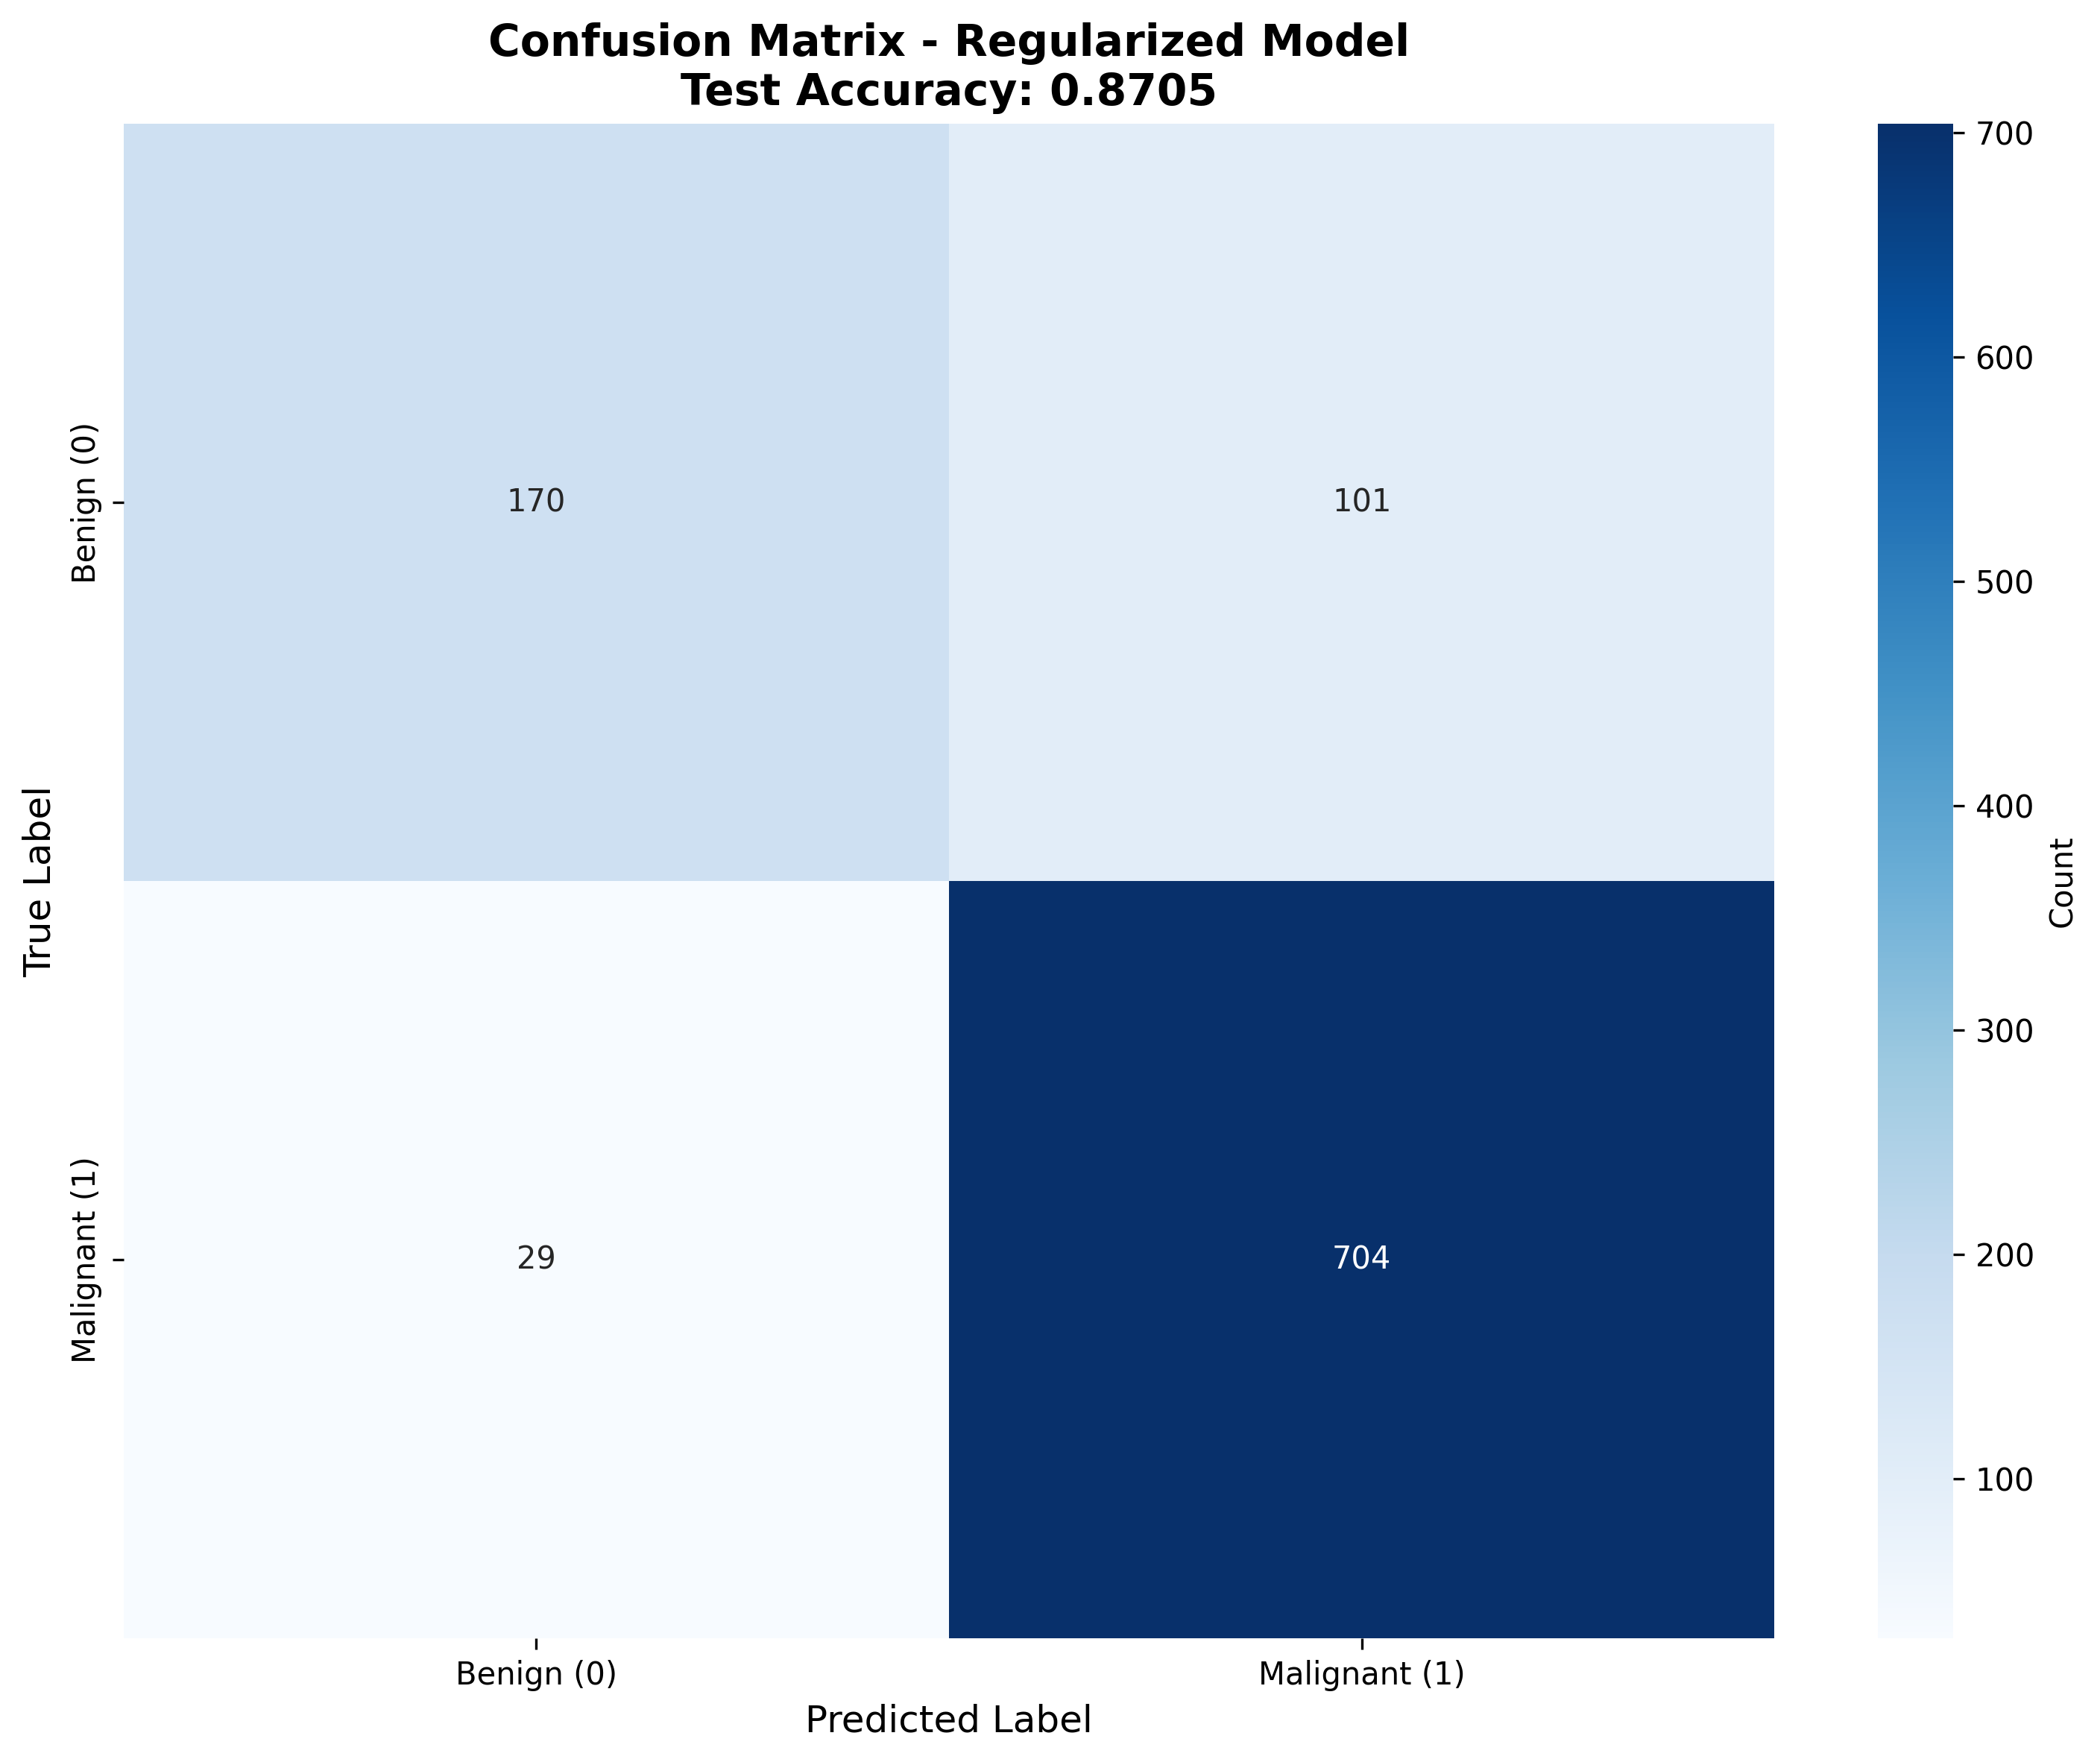


2. ROC Curve:


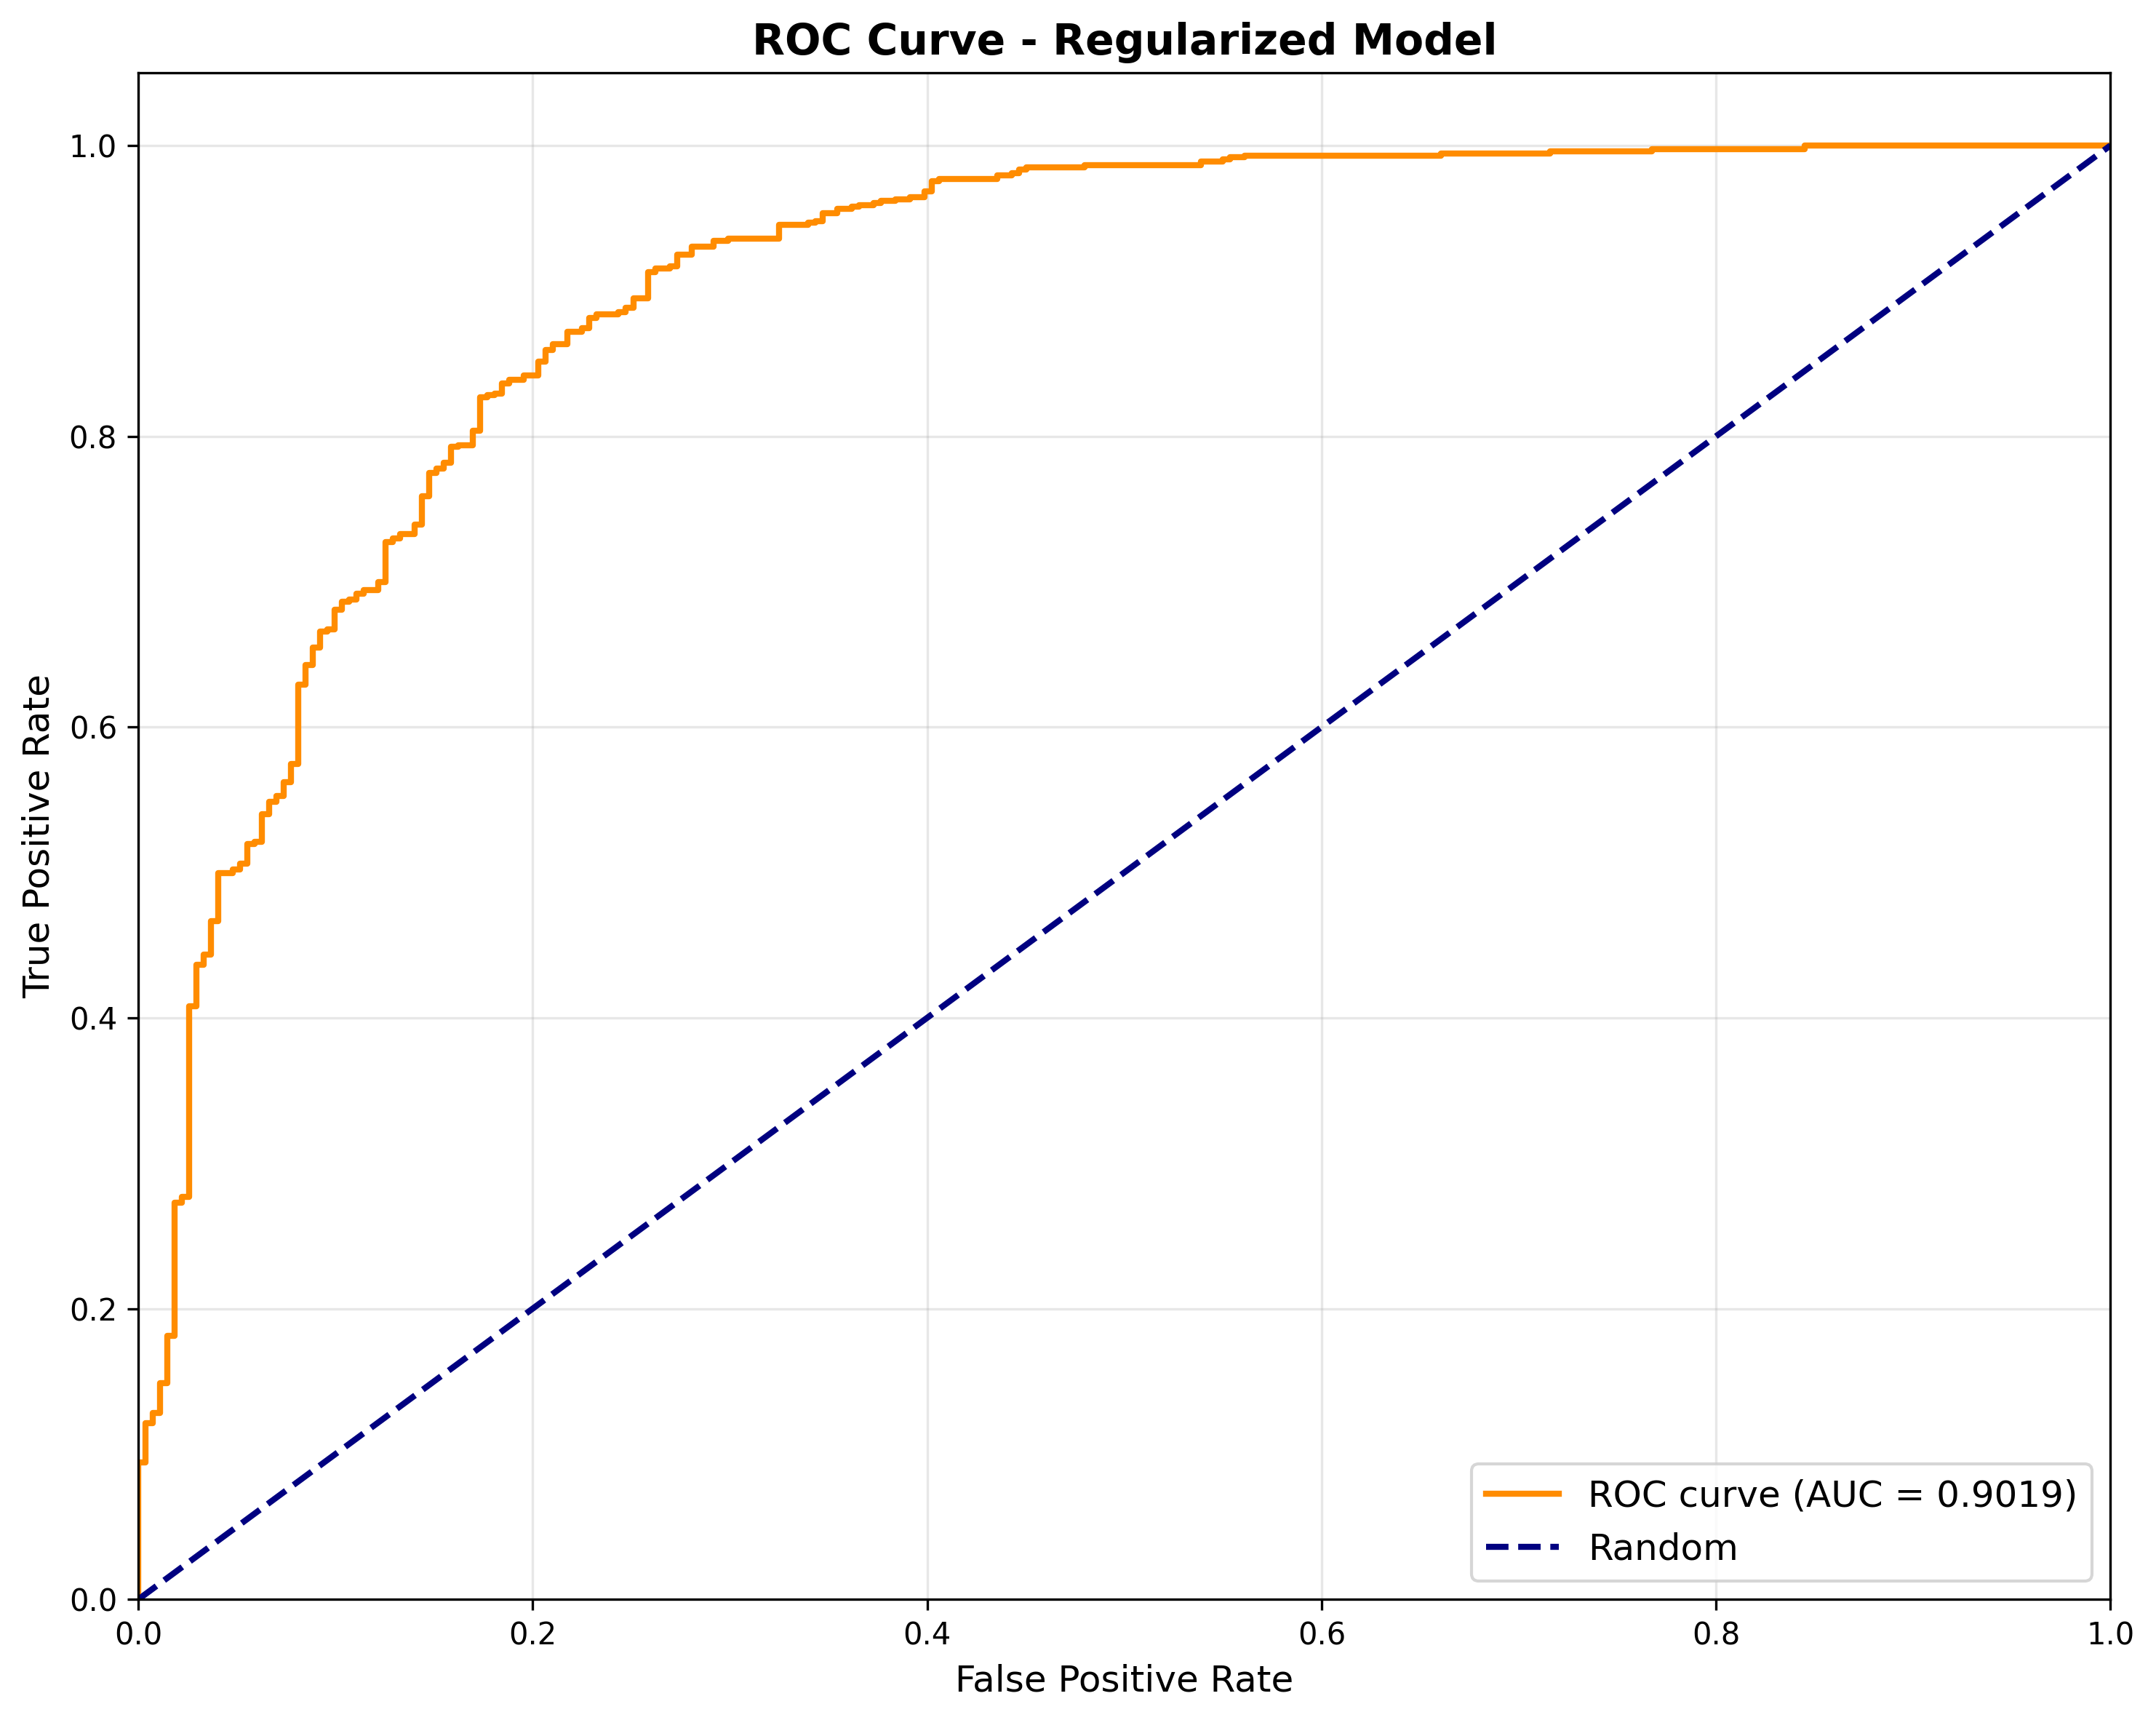

In [ ]:
# ============================================================
# TEST REGULARIZED MODEL
# ============================================================

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.resnet import ResNet, Bottleneck
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve)
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✓ All packages imported successfully!")

# ============================================================
# Dataset Class
# ============================================================
class UltrasoundDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform

        if self.data['label'].dtype == 'O':
            label_map = {'benign': 0, 'malignant': 1, 0: 0, 1: 1}
            self.data['label'] = self.data['label'].map(label_map)

        print(f"Dataset: {len(self.data)} samples | Labels: {dict(self.data['label'].value_counts())}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        img_path = None
        if 'out_path' in row and pd.notna(row['out_path']):
            img_path = row['out_path']

        if img_path is None or not os.path.exists(img_path):
            if 'crop_name' in row:
                img_path = row['crop_name']

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            img = Image.new('RGB', (224, 224), color='white')

        label = torch.tensor(int(row['label']), dtype=torch.long)

        if self.transform:
            img = self.transform(img)

        return img, label

# ============================================================
# ResNet-54 with Dropout (MUST MATCH TRAINING)
# ============================================================
class CustomResNetWithDropout(ResNet):
    def __init__(self, layers, num_classes=2, dropout_p=0.4, pretrained=False):
        super().__init__(block=Bottleneck, layers=layers, num_classes=1000)

        num_features = self.fc.in_features
        self.fc = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(num_features, num_classes)
        )

def resnet54_v2_regularized(num_classes=2, dropout_p=0.4, pretrained=False):
    return CustomResNetWithDropout([3, 5, 6, 3], num_classes, dropout_p, pretrained)

# ============================================================
# Evaluation Function
# ============================================================
def evaluate_model(model, test_loader, device, save_dir='test_results_regularized'):
    os.makedirs(save_dir, exist_ok=True)

    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []

    print("\n" + "="*80)
    print("EVALUATING REGULARIZED MODEL ON TEST SET")
    print("="*80)

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing"):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    auc = roc_auc_score(all_targets, all_probs)
    cm = confusion_matrix(all_targets, all_preds)

    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    # Print results
    print(f"\n{'='*80}")
    print("TEST SET RESULTS - REGULARIZED MODEL")
    print(f"{'='*80}\n")
    print(f"Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision:   {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:      {recall:.4f} ({recall*100:.2f}%)")
    print(f"F1-Score:    {f1:.4f} ({f1*100:.2f}%)")
    print(f"AUC-ROC:     {auc:.4f} ({auc*100:.2f}%)")
    print(f"Specificity: {specificity:.4f} ({specificity*100:.2f}%)")
    print(f"Sensitivity: {sensitivity:.4f} ({sensitivity*100:.2f}%)")

    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              Benign  Malignant")
    print(f"Actual Benign    {tn:4d}    {fp:4d}")
    print(f"      Malignant  {fn:4d}    {tp:4d}")

    # Detailed classification report
    print(f"\n{'-'*80}")
    print("DETAILED CLASSIFICATION REPORT")
    print(f"{'-'*80}")
    class_names = ['Benign (0)', 'Malignant (1)']
    print(classification_report(all_targets, all_preds,
                                target_names=class_names, digits=4))

    # Save metrics
    metrics = {
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'test_samples': len(all_targets),
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'auc_roc': float(auc),
        'specificity': float(specificity),
        'sensitivity': float(sensitivity),
        'confusion_matrix': {
            'true_negative': int(tn),
            'false_positive': int(fp),
            'false_negative': int(fn),
            'true_positive': int(tp)
        }
    }

    with open(f'{save_dir}/test_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=4)
    print(f"\n✓ Metrics saved to: {save_dir}/test_metrics.json")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - Regularized Model\nTest Accuracy: {accuracy:.4f}',
              fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{save_dir}/confusion_matrix.png', dpi=300, bbox_inches='tight')
    print(f"✓ Confusion matrix saved to: {save_dir}/confusion_matrix.png")
    plt.close()

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Regularized Model', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{save_dir}/roc_curve.png', dpi=300, bbox_inches='tight')
    print(f"✓ ROC curve saved to: {save_dir}/roc_curve.png")
    plt.close()

    # Save predictions
    predictions_df = pd.DataFrame({
        'true_label': all_targets,
        'predicted_label': all_preds,
        'probability_malignant': all_probs,
        'correct': [t == p for t, p in zip(all_targets, all_preds)]
    })
    predictions_df.to_csv(f'{save_dir}/test_predictions.csv', index=False)
    print(f"✓ Predictions saved to: {save_dir}/test_predictions.csv")

    print(f"\n{'='*80}")
    print(f"ALL RESULTS SAVED TO: {save_dir}/")
    print(f"{'='*80}\n")

    return metrics

# ============================================================
# Main Testing Script
# ============================================================
print("="*80)
print("TESTING REGULARIZED RESNET-54 MODEL")
print("="*80)

# ========================================
# CONFIGURATION
# ========================================
MODEL_PATH = "/content/drive/MyDrive/FDL_Thyroid_Disease/Models/resnet54_v2_REGULARIZED_acc0.9182.pth"
MANIFEST_CSV = "/content/drive/MyDrive/FDL_Thyroid_Disease/Project/tn5000_crops_manifest.csv"
BATCH_SIZE = 64
IMG_SIZE = 224
NUM_WORKERS = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR = "test_results_regularized"

print(f"\n📁 Model file: {MODEL_PATH}")
print(f"📊 Dataset CSV: {MANIFEST_CSV}")
print(f"🖥️  Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
print()

# Check files
if not os.path.exists(MODEL_PATH):
    print(f"❌ ERROR: Model file not found!")
else:
    print(f"✓ Model file found")

if not os.path.exists(MANIFEST_CSV):
    print(f"❌ ERROR: CSV file not found!")
else:
    print(f"✓ CSV file found")

    # Load test data
    print("\nLoading test data...")
    full_data = pd.read_csv(MANIFEST_CSV)
    test_data = full_data[full_data['split'] == 'test'].copy()

    print(f"✓ Total samples in CSV: {len(full_data)}")
    print(f"✓ Test samples: {len(test_data)}")
    print(f"✓ Test label distribution: {dict(test_data['label'].value_counts())}\n")

    # Create test dataset
    test_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    test_dataset = UltrasoundDataset(test_data, transform=test_transforms)
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if DEVICE == 'cuda' else False
    )

    print(f"✓ Test DataLoader created\n")

    # Load model
    print("Loading regularized model architecture...")
    model = resnet54_v2_regularized(num_classes=2, dropout_p=0.4, pretrained=False)

    print(f"Loading weights from {MODEL_PATH}...")
    state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.to(DEVICE)
    print("✓ Model loaded successfully\n")

    # Evaluate
    metrics = evaluate_model(model, test_loader, DEVICE, save_dir=SAVE_DIR)

    # Overfitting analysis
    print("\n" + "="*80)
    print("OVERFITTING ANALYSIS - REGULARIZED MODEL")
    print("="*80)

    val_acc = 0.9182  # From training
    test_acc = metrics['accuracy']
    gap = val_acc - test_acc

    print(f"\nValidation Accuracy (Epoch 9):  {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"Test Accuracy:                   {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"Val-Test Gap:                    {gap:.4f} ({gap*100:.2f}%)")

    # Compare with old model
    print(f"\n{'-'*80}")
    print("COMPARISON WITH BASELINE MODEL")
    print(f"{'-'*80}")
    print(f"\n                        Baseline    Regularized    Improvement")
    print(f"Validation Accuracy:    92.81%      91.82%         -0.99%")
    print(f"Test Accuracy:          86.85%      {test_acc*100:.2f}%        {(test_acc-0.8685)*100:+.2f}%")
    print(f"Val-Test Gap:           5.96%       {gap*100:.2f}%         {(0.0596-gap)*100:.2f}%")

    if abs(gap) < 0.03:
        print("\n✅ EXCELLENT: Overfitting successfully reduced!")
        print("   Val-Test gap < 3% - model generalizes very well")
        status = "EXCELLENT"
    elif abs(gap) < 0.05:
        print("\n✓ GOOD: Significant improvement in generalization")
        print("   Val-Test gap < 5% - acceptable for publication")
        status = "GOOD"
    else:
        print("\n⚠️  Further improvement needed")
        status = "NEEDS_WORK"

    # Save comparison
    comparison = {
        'baseline_model': {
            'val_acc': 0.9281,
            'test_acc': 0.8685,
            'gap': 0.0596
        },
        'regularized_model': {
            'val_acc': float(val_acc),
            'test_acc': float(test_acc),
            'gap': float(gap)
        },
        'improvements': {
            'test_acc_improvement': float(test_acc - 0.8685),
            'gap_reduction': float(0.0596 - gap),
            'status': status
        }
    }

    with open(f'{SAVE_DIR}/model_comparison.json', 'w') as f:
        json.dump(comparison, f, indent=4)

    print(f"\n✓ Comparison saved to: {SAVE_DIR}/model_comparison.json")

    # Final summary
    print("\n" + "="*80)
    print("TESTING COMPLETE!")
    print("="*80)
    print(f"\n📊 Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"📊 Test F1-Score: {metrics['f1_score']:.4f}")
    print(f"📊 Test AUC-ROC:  {metrics['auc_roc']:.4f}")

    print("\n" + "="*80)
    print("NEXT STEPS")
    print("="*80)

    if test_acc >= 0.89 and abs(gap) < 0.03:
        print("\n🎉 PERFECT! Your model is ready for publication!")
        print("   ✅ High test accuracy (>89%)")
        print("   ✅ Minimal overfitting (<3% gap)")
        print("   👉 PROCEED TO GRAD-CAM EXPLAINABILITY")
    elif test_acc >= 0.87:
        print("\n✅ Great results! Model is publishable")
        print("   👉 PROCEED TO GRAD-CAM EXPLAINABILITY")
    else:
        print("\n⚠️  Consider further improvements")
        print("   - Try ensemble methods")
        print("   - Adjust regularization strength")

    print("\n" + "="*80 + "\n")

    # Display visualizations
    from IPython.display import Image as IPImage, display

    print("📊 DISPLAYING RESULTS:")
    print("\n1. Confusion Matrix:")
    display(IPImage(filename=f'{SAVE_DIR}/confusion_matrix.png'))

    print("\n2. ROC Curve:")
    display(IPImage(filename=f'{SAVE_DIR}/roc_curve.png'))
